<a href="https://colab.research.google.com/github/Mandred009/Freelance-Gigs/blob/main/Meta_Learning_Using_Genetic_Algorithm_Freelan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

In [ ]:
import os
path_train='/content/drive/MyDrive/Freelancing/Pneumo Train'
path_test='/content/drive/MyDrive/Freelancing/Pneumo Test'

In [ ]:
import cv2 as cv

In [ ]:
# 0 for Normal Lungs
# 1 for Bacterial Lungs

In [ ]:
y_tr=[]
data_train=[]
for img in os.listdir(path_train):
  img_arr = cv.imread(os.path.join(path_train, img)) #[...,::-1] #convert BGR to RGB format #optional
  resized_arr = cv.resize(img_arr, (32,32)) #reshape
  im_rgb = cv.cvtColor(resized_arr, cv.COLOR_BGR2RGB)
  data_train.append(im_rgb)
  if img[0]=='n':
    y_tr.append(0)
  else:
    y_tr.append(1)
  

In [ ]:
y_t=[]
data_test=[]
for img in os.listdir(path_test):
  img_arr = cv.imread(os.path.join(path_test, img)) #[...,::-1] #convert BGR to RGB format #optional
  resized_arr = cv.resize(img_arr, (32,32)) #reshape
  im_rgb = cv.cvtColor(resized_arr, cv.COLOR_BGR2RGB)
  data_test.append(im_rgb)
  if img[0]=='n':
    y_t.append(0)
  else:
    y_t.append(1)

In [ ]:
"""
Generic setup of the data sources and the model training. 
"""

#import keras
from keras.models         import Sequential
from keras.layers         import Dense, Dropout, Flatten
from keras.utils.np_utils import to_categorical
from keras.callbacks      import EarlyStopping, Callback
from keras.layers         import Conv2D, MaxPooling2D
from keras                import backend as K

import logging

# Helper: Early stopping.
early_stopper = EarlyStopping( monitor='val_loss', min_delta=0.1, patience=2, verbose=0, mode='auto' )

#patience=5)
#monitor='val_loss',patience=2,verbose=0
#In your case, you can see that your training loss is not dropping - which means you are learning nothing after each epoch. 
#It look like there's nothing to learn in this model, aside from some trivial linear-like fit or cutoff value.

def get_images():
    """Retrieve the dataset and process the data."""
    # Set defaults.
    nb_classes  = 2 #dataset dependent 
    batch_size  = 25
    epochs      = 3
    input_shape = (32, 32, 3) #because it's RGB

    # Get the data.
    x_train=np.array(data_train)
    x_test=np.array(data_test)
    x_train = x_train.astype('float32')
    x_test  = x_test.astype('float32')
    y_train=np.array(y_tr)
    y_test=np.array(y_t)
    x_train /= 255
    x_test  /= 255

    return (nb_classes, batch_size, input_shape, x_train, x_test, y_train, y_test, epochs)

def compile_model_cnn(genome, nb_classes, input_shape):
    """Compile a sequential model.
    Args:
        genome (dict): the parameters of the genome
    Returns:
        a compiled network.
    """
    # Get our network parameters.
    nb_layers  = genome.geneparam['nb_layers' ]
    nb_neurons = genome.nb_neurons()
    activation = genome.geneparam['activation']
    optimizer  = genome.geneparam['optimizer' ]

    logging.info("Architecture:%s,%s,%s,%d" % (str(nb_neurons), activation, optimizer, nb_layers))

    model = Sequential()

    # Add each layer.
    for i in range(0,nb_layers):
        # Need input shape for first layer.
        if i == 0:
            model.add(Conv2D(nb_neurons[i], kernel_size = (3, 3), activation = activation, padding='same', input_shape = input_shape))
        else:
            model.add(Conv2D(nb_neurons[i], kernel_size = (3, 3), activation = activation))
        
        if i < 2: #otherwise we hit zero
            model.add(MaxPooling2D(pool_size=(2, 2)))
        
        model.add(Dropout(0.2))

    model.add(Flatten())
    # always use last nb_neurons value for dense layer
    model.add(Dense(nb_neurons[len(nb_neurons) - 1], activation = activation))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes, activation = 'softmax'))

    #BAYESIAN CONVOLUTIONAL NEURAL NETWORKS WITH BERNOULLI APPROXIMATE VARIATIONAL INFERENCE
    #need to read this paper

    model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

    return model

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

def train_and_score(genome, dataset):
    """Train the model, return test loss.
    Args:
        network (dict): the parameters of the network
        dataset (str): Dataset to use for training/evaluating
    """
    logging.info("Getting Keras datasets")

    nb_classes, batch_size, input_shape, x_train, x_test, y_train, y_test, epochs = get_images()

    logging.info("Compling Keras model")

    model = compile_model_cnn(genome, nb_classes, input_shape)

    history = LossHistory()

    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,  
              # using early stopping so no real limit - don't want to waste time on horrible architectures
              verbose=1,
              validation_data=(x_test, y_test),
              #callbacks=[history])
              callbacks=[early_stopper])

    score = model.evaluate(x_test, y_test, verbose=0)

    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    K.clear_session()
    #we do not care about keeping any of this in memory - 
    #we just need to know the final scores and the architecture
    
    return score[1]  # 1 is accuracy. 0 is loss.

In [ ]:
import random
import logging
import hashlib
import copy


class Genome():
    """
    Represents one genome and all relevant utility functions (add, mutate, etc.).
    """

    def __init__( self, all_possible_genes = None, geneparam = {}, u_ID = 0, mom_ID = 0, dad_ID = 0, gen = 0 ):
        """Initialize a genome.
        Args:
            all_possible_genes (dict): Parameters for the genome, includes:
                gene_nb_neurons_i (list): [64, 128, 256]      for (i=1,...,6)
                gene_nb_layers (list):  [1, 2, 3, 4]
                gene_activation (list): ['relu', 'elu']
                gene_optimizer (list):  ['rmsprop', 'adam']
        """
        self.accuracy         = 0.0
        self.all_possible_genes = all_possible_genes
        self.geneparam        = geneparam #(dict): represents actual genome parameters
        self.u_ID             = u_ID
        self.parents          = [mom_ID, dad_ID]
        self.generation       = gen
        
        #hash only makes sense when we have specified the genes
        if not geneparam:
            self.hash = 0
        else:
            self.update_hash()
        
    def update_hash(self):
        """
        Refesh each genome's unique hash - needs to run after any genome changes.
        """
        genh = str(self.nb_neurons()) + self.geneparam['activation'] \
                + str(self.geneparam['nb_layers']) + self.geneparam['optimizer']

        self.hash = hashlib.md5(genh.encode("UTF-8")).hexdigest()

        self.accuracy = 0.0
            
    def set_genes_random(self):
        """Create a random genome."""
        #print("set_genes_random")
        self.parents = [0,0] #very sad - no parents :(

        for key in self.all_possible_genes:
            self.geneparam[key] = random.choice(self.all_possible_genes[key])
                
        self.update_hash()
        
    def mutate_one_gene(self):
        """Randomly mutate one gene in the genome.
        Args:
            network (dict): The genome parameters to mutate
        Returns:
            (Genome): A randomly mutated genome object
        """
        # Which gene shall we mutate? Choose one of N possible keys/genes.
        gene_to_mutate = random.choice( list(self.all_possible_genes.keys()) )

        # And then let's mutate one of the genes.
        # Make sure that this actually creates mutation
        current_value    = self.geneparam[gene_to_mutate]
        possible_choices = copy.deepcopy(self.all_possible_genes[gene_to_mutate])
        
        possible_choices.remove(current_value)
        
        self.geneparam[gene_to_mutate] = random.choice( possible_choices )

        self.update_hash()
    
    def set_generation(self, generation):
        """needed when a genome is passed on from one generation to the next.
        the id stays the same, but the generation is increased"""   

        self.generation = generation
        #logging.info("Setting Generation to %d" % self.generation)

    def set_genes_to(self, geneparam, mom_ID, dad_ID):
        """Set genome properties.
        this is used when breeding kids
        Args:
            genome (dict): The genome parameters
        IMPROVE
        """
        self.parents  = [mom_ID, dad_ID]
        
        self.geneparam = geneparam

        self.update_hash()

    def train(self, trainingset):
        """Train the genome and record the accuracy.
        Args:
            dataset (str): Name of dataset to use.
        """
        if self.accuracy == 0.0: #don't bother retraining ones we already trained 
            self.accuracy = train_and_score(self, trainingset)

    def print_genome(self):
        """Print out a genome."""
        self.print_geneparam()
        logging.info("Acc: %.2f%%" % (self.accuracy * 100))
        logging.info("UniID: %d" % self.u_ID)
        logging.info("Mom and Dad: %d %d" % (self.parents[0], self.parents[1]))
        logging.info("Gen: %d" % self.generation)
        logging.info("Hash: %s" % self.hash)

    def print_genome_ma(self):
        """Print out a genome."""
        self.print_geneparam()
        logging.info("Acc: %.2f%% UniID: %d Mom and Dad: %d %d Gen: %d" % (self.accuracy * 100, self.u_ID, self.parents[0], self.parents[1], self.generation))
        logging.info("Hash: %s" % self.hash)

    # print nb_neurons as single list
    def print_geneparam(self):
        g = self.geneparam.copy()
        nb_neurons = self.nb_neurons()
        for i in range(1,7):
          g.pop('nb_neurons_' + str(i))
        # replace individual layer numbers with single list
        g['nb_neurons'] = nb_neurons
        logging.info(g)
    
    # convert nb_neurons_i at each layer to a single list
    def nb_neurons(self):
      nb_neurons = [None] * 6
      for i in range(0,6):
        nb_neurons[i] = self.geneparam['nb_neurons_' + str(i+1)]

      return nb_neurons

In [ ]:
"""Provide unique genome IDs."""

import logging

class IDgen():
    """Generate unique IDs.
    """

    def __init__(self):
        """Keep track of IDs.
        """
        self.currentID  = 0
        self.currentGen = 1

    def get_next_ID(self):

        self.currentID += 1

        return self.currentID
  
    def increase_Gen(self):

        self.currentGen += 1
        
    def get_Gen(self):

        return self.currentGen
        

In [ ]:
""" Class that keeps track of all genomes trained so far, and their scores.
    Among other things, ensures that genomes are unique.
"""

import random
import logging

class AllGenomes():
    """Store all genomes
    """

    def __init__(self, firstgenome):
        """Initialize
        """

        self.population = []
        self.population.append(firstgenome)
        
    def add_genome(self, genome):
        """Add the genome to our population.
        """

        for i in range(0,len(self.population)):
            if (genome.hash == self.population[i].hash):
                logging.info("add_genome() ERROR: hash clash - duplicate genome")
                return False

        self.population.append(genome)

        return True
        
    def set_accuracy(self, genome):
        """Add the genome to our population.
        """
        
        for i in range(0,len(self.population)):
            if (genome.hash == self.population[i].hash):
                self.population[i].accuracy = genome.accuracy
                return
    
        logging.info("set_accuracy() ERROR: Genome not found")

    def is_duplicate(self, genome):
        """Add the genome to our population.
        """

        for i in range(0,len(self.population)):
            if (genome.hash == self.population[i].hash):
                return True
    
        return False

    def print_all_genomes(self):
        """Print out a genome.
        """

        for genome in self.population:
            genome.print_genome_ma()

In [ ]:
"""
Class that holds a genetic algorithm for evolving a network.
"""
from __future__ import print_function

import random
import logging
import copy

from functools  import reduce


class Evolver():
    """Class that implements genetic algorithm."""

    def __init__(self, all_possible_genes, retain=0.15, random_select=0.1, mutate_chance=0.3):
        """Create an optimizer.
        Args:
            all_possible_genes (dict): Possible genome parameters
            retain (float): Percentage of population to retain after
                each generation
            random_select (float): Probability of a rejected genome
                remaining in the population
            mutate_chance (float): Probability a genome will be
                randomly mutated
        """

        self.all_possible_genes = all_possible_genes
        self.retain             = retain
        self.random_select      = random_select
        self.mutate_chance      = mutate_chance

        #set the ID gen
        self.ids = IDgen()
        
    def create_population(self, count):
        """Create a population of random networks.
        Args:
            count (int): Number of networks to generate, aka the
                size of the population
        Returns:
            (list): Population of network objects
        """
        pop = []

        i = 0

        while i < count:
            
            # Initialize a new genome.
            genome = Genome( self.all_possible_genes, {}, self.ids.get_next_ID(), 0, 0, self.ids.get_Gen() )

            # Set it to random parameters.
            genome.set_genes_random()

            if i == 0:
                #this is where we will store all genomes
                self.master = AllGenomes( genome )
            else:
                # Make sure it is unique....
                while self.master.is_duplicate( genome ):
                    genome.mutate_one_gene()

            # Add the genome to our population.
            pop.append(genome)

            # and add to the master list
            if i > 0:
                self.master.add_genome(genome)

            i += 1

        #self.master.print_all_genomes()
        
        #exit()

        return pop

    @staticmethod
    def fitness(genome):
        """Return the accuracy, which is our fitness function."""
        return genome.accuracy

    def grade(self, pop):
        """Find average fitness for a population.
        Args:
            pop (list): The population of networks/genome
        Returns:
            (float): The average accuracy of the population
        """
        summed = reduce(add, (self.fitness(genome) for genome in pop))
        return summed / float((len(pop)))

    def breed(self, mom, dad):
        """Make two children from parental genes.
        Args:
            mother (dict): genome parameters
            father (dict): genome parameters
        Returns:
            (list): Two network objects
        """
        children = []

        #where do we recombine? 0, 1, 2, 3, 4... N?
        #with four genes, there are three choices for the recombination
        # ___ * ___ * ___ * ___ 
        #0 -> no recombination, and N == length of dictionary -> no recombination
        #0 and 4 just (re)create more copies of the parents
        #so the range is always 1 to len(all_possible_genes) - 1
        pcl = len(self.all_possible_genes)
        
        recomb_loc = random.randint(1,pcl - 1) 

        #for _ in range(2): #make _two_ children - could also make more
        child1 = {}
        child2 = {}

        #enforce defined genome order using list 
        #keys = ['nb_neurons', 'nb_layers', 'activation', 'optimizer']
        keys = list(self.all_possible_genes)
        keys = sorted(keys) #paranoia - just to make sure we do not add unintentional randomization

        #*** CORE RECOMBINATION CODE ****
        for x in range(0, pcl):
            if x < recomb_loc:
                child1[keys[x]] = mom.geneparam[keys[x]]
                child2[keys[x]] = dad.geneparam[keys[x]]
            else:
                child1[keys[x]] = dad.geneparam[keys[x]]
                child2[keys[x]] = mom.geneparam[keys[x]]

        # Initialize a new genome
        # Set its parameters to those just determined
        # they both have the same mom and dad
        genome1 = Genome( self.all_possible_genes, child1, self.ids.get_next_ID(), mom.u_ID, dad.u_ID, self.ids.get_Gen() )
        genome2 = Genome( self.all_possible_genes, child2, self.ids.get_next_ID(), mom.u_ID, dad.u_ID, self.ids.get_Gen() )

        #at this point, there is zero guarantee that the genome is actually unique

        # Randomly mutate one gene
        if self.mutate_chance > random.random(): 
        	genome1.mutate_one_gene()

        if self.mutate_chance > random.random(): 
        	genome2.mutate_one_gene()

        #do we have a unique child or are we just retraining one we already have anyway?
        while self.master.is_duplicate(genome1):
            genome1.mutate_one_gene()

        self.master.add_genome(genome1)
        
        while self.master.is_duplicate(genome2):
            genome2.mutate_one_gene()

        self.master.add_genome(genome2)
        
        children.append(genome1)
        children.append(genome2)

        return children

    def evolve(self, pop):
        """Evolve a population of genomes.
        Args:
            pop (list): A list of genome parameters
        Returns:
            (list): The evolved population of networks
        """
        #increase generation 
        self.ids.increase_Gen()

        # Get scores for each genome
        graded = [(self.fitness(genome), genome) for genome in pop]

        #and use those scores to fill in the master list
        for genome in pop:
            self.master.set_accuracy(genome)

        # Sort on the scores.
        graded = [x[1] for x in sorted(graded, key=lambda x: x[0], reverse=True)]

        # Get the number we want to keep unchanged for the next cycle.
        retain_length = int(len(graded)*self.retain)

        # In this first step, we keep the 'top' X percent (as defined in self.retain)
        # We will not change them, except we will update the generation
        new_generation = graded[:retain_length]

        # For the lower scoring ones, randomly keep some anyway.
        # This is wasteful, since we _know_ these are bad, so why keep rescoring them without modification?
        # At least we should mutate them
        for genome in graded[retain_length:]:
            if self.random_select > random.random():
                gtc = copy.deepcopy(genome)
                
                while self.master.is_duplicate(gtc):
                    gtc.mutate_one_gene()

                gtc.set_generation( self.ids.get_Gen() )
                new_generation.append(gtc)
                self.master.add_genome(gtc)
        
        # Now find out how many spots we have left to fill.
        ng_length      = len(new_generation)

        desired_length = len(pop) - ng_length

        children       = []

        # Add children, which are bred from pairs of remaining (i.e. very high or lower scoring) genomes.
        while len(children) < desired_length:

            # Get a random mom and dad, but, need to make sure they are distinct
            parents  = random.sample(range(ng_length-1), k=2)
            
            i_male   = parents[0]
            i_female = parents[1]

            male   = new_generation[i_male]
            female = new_generation[i_female]

            # Recombine and mutate
            babies = self.breed(male, female)
            # the babies are guaranteed to be novel

            # Add the children one at a time.
            for baby in babies:
                # Don't grow larger than desired length.
                #if len(children) < desired_length:
                children.append(baby)

        new_generation.extend(children)

        return new_generation

In [ ]:
"""Entry point to evolving the neural network. Start here."""
from __future__ import print_function

from tqdm import tqdm

import logging

import sys

# Setup logging.
logging.basicConfig(
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%m/%d/%Y %I:%M:%S %p',
    level=logging.INFO#,
    #filename='log.txt'
)

def train_genomes(genomes, dataset):
    """Train each genome.
    Args:
        networks (list): Current population of genomes
        dataset (str): Dataset to use for training/evaluating
    """
    logging.info("***train_networks(networks, dataset)***")

    pbar = tqdm(total=len(genomes))

    for genome in genomes:
        genome.train(dataset)
        pbar.update(1)
    
    pbar.close()

def get_average_accuracy(genomes):
    """Get the average accuracy for a group of networks/genomes.
    Args:
        networks (list): List of networks/genomes
    Returns:
        float: The average accuracy of a population of networks/genomes.
    """
    total_accuracy = 0

    for genome in genomes:
        total_accuracy += genome.accuracy

    return total_accuracy / len(genomes)

def generate(generations, population, all_possible_genes, dataset):
    """Generate a network with the genetic algorithm.
    Args:
        generations (int): Number of times to evolve the population
        population (int): Number of networks in each generation
        all_possible_genes (dict): Parameter choices for networks
        dataset (str): Dataset to use for training/evaluating
    """
    logging.info("***generate(generations, population, all_possible_genes, dataset)***")
    
    evolver = Evolver(all_possible_genes)
    
    genomes = evolver.create_population(population)

    # Evolve the generation.
    for i in range( generations ):

        logging.info("***Now in generation %d of %d***" % (i + 1, generations))

        print_genomes(genomes)
        
        # Train and get accuracy for networks/genomes.
        train_genomes(genomes, dataset)

        # Get the average accuracy for this generation.
        average_accuracy = get_average_accuracy(genomes)

        # Print out the average accuracy each generation.
        logging.info("Generation average: %.2f%%" % (average_accuracy * 100))
        logging.info('-'*80) #-----------

        # Evolve, except on the last iteration.
        if i != generations - 1:
            # Evolve!
            genomes = evolver.evolve(genomes)

    # Sort our final population according to performance.
    genomes = sorted(genomes, key=lambda x: x.accuracy, reverse=True)

    # Print out the top 5 networks/genomes.
    print_genomes(genomes[:5])

    #save_path = saver.save(sess, '/output/model.ckpt')
    #print("Model saved in file: %s" % save_path)

def print_genomes(genomes):
    """Print a list of genomes.
    Args:
        genomes (list): The population of networks/genomes
    """
    logging.info('-'*80)

    for genome in genomes:
        genome.print_genome()

def main():
    """Evolve a genome."""
    population = 30 # Number of networks/genomes in each generation.
    #we only need to train the new ones....
    generations = 8 # Number of times to evolve the population.
    all_possible_genes = {
            'nb_neurons': [16, 32, 64, 128],
            'nb_layers':  [1, 2, 3, 4 ,5],
            'activation': ['relu', 'elu', 'tanh', 'sigmoid', 'hard_sigmoid','softplus','linear'],
            'optimizer':  ['rmsprop', 'adam', 'sgd', 'adagrad','adadelta', 'adamax', 'nadam']
    }
    # replace nb_neurons with 1 unique value for each layer
    # 6th value reserved for dense layer
    nb_neurons = all_possible_genes['nb_neurons']
    for i in range(1,7):
      all_possible_genes['nb_neurons_' + str(i)] = nb_neurons
    # remove old value from dict
    all_possible_genes.pop('nb_neurons')
            
    print("***Evolving for %d generations with population size = %d***" % (generations, population))

    generate(generations, population, all_possible_genes, 'Pneumonia Classifications')

if __name__ == '__main__':
    main()

04/23/2022 07:47:54 AM - INFO - ***generate(generations, population, all_possible_genes, dataset)***
04/23/2022 07:47:54 AM - INFO - ***Now in generation 1 of 8***
04/23/2022 07:47:54 AM - INFO - --------------------------------------------------------------------------------
04/23/2022 07:47:54 AM - INFO - {'nb_layers': 5, 'activation': 'hard_sigmoid', 'optimizer': 'nadam', 'nb_neurons': [128, 32, 32, 64, 32, 128]}
04/23/2022 07:47:54 AM - INFO - Acc: 0.00%
04/23/2022 07:47:54 AM - INFO - UniID: 1
04/23/2022 07:47:54 AM - INFO - Mom and Dad: 0 0
04/23/2022 07:47:54 AM - INFO - Gen: 1
04/23/2022 07:47:54 AM - INFO - Hash: 96a55146fcf1e126fe89a5688e39f41c
04/23/2022 07:47:54 AM - INFO - {'nb_layers': 4, 'activation': 'elu', 'optimizer': 'adadelta', 'nb_neurons': [64, 32, 64, 16, 64, 128]}
04/23/2022 07:47:54 AM - INFO - Acc: 0.00%
04/23/2022 07:47:54 AM - INFO - UniID: 2
04/23/2022 07:47:54 AM - INFO - Mom and Dad: 0 0
04/23/2022 07:47:54 AM - INFO - Gen: 1
04/23/2022 07:47:54 AM - INFO

***Evolving for 8 generations with population size = 30***


04/23/2022 07:47:54 AM - INFO - Acc: 0.00%
04/23/2022 07:47:54 AM - INFO - UniID: 18
04/23/2022 07:47:54 AM - INFO - Mom and Dad: 0 0
04/23/2022 07:47:54 AM - INFO - Gen: 1
04/23/2022 07:47:54 AM - INFO - Hash: 897def486744a94c92c4c42107d8a844
04/23/2022 07:47:54 AM - INFO - {'nb_layers': 4, 'activation': 'hard_sigmoid', 'optimizer': 'sgd', 'nb_neurons': [32, 64, 16, 64, 32, 128]}
04/23/2022 07:47:54 AM - INFO - Acc: 0.00%
04/23/2022 07:47:54 AM - INFO - UniID: 19
04/23/2022 07:47:54 AM - INFO - Mom and Dad: 0 0
04/23/2022 07:47:54 AM - INFO - Gen: 1
04/23/2022 07:47:54 AM - INFO - Hash: 9d7e002877d2a41539e179e91b98315c
04/23/2022 07:47:54 AM - INFO - {'nb_layers': 2, 'activation': 'softplus', 'optimizer': 'rmsprop', 'nb_neurons': [64, 128, 64, 16, 128, 32]}
04/23/2022 07:47:54 AM - INFO - Acc: 0.00%
04/23/2022 07:47:54 AM - INFO - UniID: 20
04/23/2022 07:47:54 AM - INFO - Mom and Dad: 0 0
04/23/2022 07:47:54 AM - INFO - Gen: 1
04/23/2022 07:47:54 AM - INFO - Hash: 3d835e7898baec6a615e

Epoch 1/3
2/2 [==============================] - 3s 429ms/step - loss: 0.8221 - accuracy: 0.6000 - val_loss: 0.7439 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 204ms/step - loss: 0.8799 - accuracy: 0.4800 - val_loss: 0.7090 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 189ms/step - loss: 0.8841 - accuracy: 0.4600 - val_loss: 0.6957 - val_accuracy: 0.5000









  3%|▎         | 1/30 [00:03<01:53,  3.92s/it]04/23/2022 07:47:58 AM - INFO - Getting Keras datasets
04/23/2022 07:47:58 AM - INFO - Compling Keras model
04/23/2022 07:47:58 AM - INFO - Architecture:[64, 32, 64, 16, 64, 128],elu,adadelta,4


Test loss: 0.6957362294197083
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 277ms/step - loss: 0.8226 - accuracy: 0.5200 - val_loss: 0.7609 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 116ms/step - loss: 0.8381 - accuracy: 0.4200 - val_loss: 0.7605 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 118ms/step - loss: 0.8270 - accuracy: 0.4200 - val_loss: 0.7600 - val_accuracy: 0.5000









  7%|▋         | 2/30 [00:05<01:13,  2.63s/it]04/23/2022 07:48:00 AM - INFO - Getting Keras datasets
04/23/2022 07:48:00 AM - INFO - Compling Keras model
04/23/2022 07:48:00 AM - INFO - Architecture:[32, 128, 64, 32, 32, 32],linear,adadelta,3


Test loss: 0.7600467205047607
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 261ms/step - loss: 0.7629 - accuracy: 0.4600 - val_loss: 0.7342 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 110ms/step - loss: 0.8469 - accuracy: 0.4400 - val_loss: 0.7331 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 116ms/step - loss: 0.8034 - accuracy: 0.5400 - val_loss: 0.7322 - val_accuracy: 0.5000
Test loss: 0.7322279214859009
Test accuracy: 0.5









 10%|█         | 3/30 [00:07<00:57,  2.13s/it]04/23/2022 07:48:02 AM - INFO - Getting Keras datasets
04/23/2022 07:48:02 AM - INFO - Compling Keras model
04/23/2022 07:48:02 AM - INFO - Architecture:[64, 128, 128, 32, 64, 32],relu,adadelta,1


Epoch 1/3
2/2 [==============================] - 1s 204ms/step - loss: 0.7211 - accuracy: 0.4800 - val_loss: 0.7050 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 71ms/step - loss: 0.7165 - accuracy: 0.4800 - val_loss: 0.7046 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 74ms/step - loss: 0.7173 - accuracy: 0.4800 - val_loss: 0.7041 - val_accuracy: 0.5000









 13%|█▎        | 4/30 [00:08<00:45,  1.76s/it]04/23/2022 07:48:03 AM - INFO - Getting Keras datasets
04/23/2022 07:48:03 AM - INFO - Compling Keras model


Test loss: 0.7041378617286682
Test accuracy: 0.5


04/23/2022 07:48:03 AM - INFO - Architecture:[64, 128, 32, 16, 64, 64],hard_sigmoid,adagrad,2


Epoch 1/3
2/2 [==============================] - 1s 340ms/step - loss: 0.9398 - accuracy: 0.5000 - val_loss: 0.8091 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 182ms/step - loss: 0.8707 - accuracy: 0.5000 - val_loss: 0.7555 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 182ms/step - loss: 0.7352 - accuracy: 0.5400 - val_loss: 0.7335 - val_accuracy: 0.5000


  0%|          | 0/30 [05:21<?, ?it/s]







 17%|█▋        | 5/30 [00:10<00:50,  2.04s/it]04/23/2022 07:48:05 AM - INFO - Getting Keras datasets
04/23/2022 07:48:05 AM - INFO - Compling Keras model
04/23/2022 07:48:05 AM - INFO - Architecture:[128, 32, 16, 32, 128, 32],elu,adamax,4


Test loss: 0.7335101962089539
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 328ms/step - loss: 0.6984 - accuracy: 0.5400 - val_loss: 0.6909 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 213ms/step - loss: 0.6698 - accuracy: 0.5200 - val_loss: 0.6889 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 173ms/step - loss: 0.6658 - accuracy: 0.6400 - val_loss: 0.6710 - val_accuracy: 0.5000









 20%|██        | 6/30 [00:13<00:49,  2.06s/it]04/23/2022 07:48:07 AM - INFO - Getting Keras datasets
04/23/2022 07:48:07 AM - INFO - Compling Keras model
04/23/2022 07:48:07 AM - INFO - Architecture:[32, 128, 64, 16, 32, 32],softplus,adadelta,4


Test loss: 0.6710264682769775
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 299ms/step - loss: 2.3984 - accuracy: 0.5000 - val_loss: 2.0392 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 139ms/step - loss: 2.3180 - accuracy: 0.5000 - val_loss: 2.0323 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 149ms/step - loss: 2.3933 - accuracy: 0.5200 - val_loss: 2.0259 - val_accuracy: 0.5000









 23%|██▎       | 7/30 [00:14<00:45,  1.98s/it]04/23/2022 07:48:09 AM - INFO - Getting Keras datasets
04/23/2022 07:48:09 AM - INFO - Compling Keras model
04/23/2022 07:48:09 AM - INFO - Architecture:[16, 128, 128, 64, 32, 16],elu,sgd,3


Test loss: 2.0258901119232178
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 276ms/step - loss: 0.7219 - accuracy: 0.4200 - val_loss: 0.7085 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 112ms/step - loss: 0.8229 - accuracy: 0.4600 - val_loss: 0.7252 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 114ms/step - loss: 0.7341 - accuracy: 0.4400 - val_loss: 0.6898 - val_accuracy: 0.5400









 27%|██▋       | 8/30 [00:16<00:44,  2.00s/it]04/23/2022 07:48:11 AM - INFO - Getting Keras datasets
04/23/2022 07:48:11 AM - INFO - Compling Keras model
04/23/2022 07:48:11 AM - INFO - Architecture:[64, 64, 16, 128, 64, 128],relu,adagrad,4


Test loss: 0.6897987127304077
Test accuracy: 0.5400000214576721
Epoch 1/3
2/2 [==============================] - 1s 275ms/step - loss: 0.7251 - accuracy: 0.3600 - val_loss: 0.6949 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 124ms/step - loss: 0.6959 - accuracy: 0.5200 - val_loss: 0.6949 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 123ms/step - loss: 0.7332 - accuracy: 0.4400 - val_loss: 0.6945 - val_accuracy: 0.5000









 30%|███       | 9/30 [00:18<00:39,  1.90s/it]04/23/2022 07:48:13 AM - INFO - Getting Keras datasets
04/23/2022 07:48:13 AM - INFO - Compling Keras model
04/23/2022 07:48:13 AM - INFO - Architecture:[16, 64, 64, 64, 128, 64],hard_sigmoid,adadelta,5


Test loss: 0.6945332884788513
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 299ms/step - loss: 0.8699 - accuracy: 0.4800 - val_loss: 0.6988 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 89ms/step - loss: 0.7800 - accuracy: 0.5800 - val_loss: 0.6988 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 81ms/step - loss: 0.8024 - accuracy: 0.5800 - val_loss: 0.6988 - val_accuracy: 0.5000









 33%|███▎      | 10/30 [00:20<00:37,  1.88s/it]04/23/2022 07:48:15 AM - INFO - Getting Keras datasets
04/23/2022 07:48:15 AM - INFO - Compling Keras model
04/23/2022 07:48:15 AM - INFO - Architecture:[32, 16, 16, 64, 32, 16],softplus,adamax,4


Test loss: 0.6987558007240295
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 233ms/step - loss: 2.3825 - accuracy: 0.5000 - val_loss: 0.9891 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 82ms/step - loss: 1.1053 - accuracy: 0.5400 - val_loss: 0.6949 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 98ms/step - loss: 0.9567 - accuracy: 0.3200 - val_loss: 0.7250 - val_accuracy: 0.5000









 37%|███▋      | 11/30 [00:22<00:34,  1.80s/it]04/23/2022 07:48:16 AM - INFO - Getting Keras datasets
04/23/2022 07:48:16 AM - INFO - Compling Keras model
04/23/2022 07:48:16 AM - INFO - Architecture:[32, 128, 64, 128, 128, 16],sigmoid,adamax,1


Test loss: 0.7250108122825623
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 192ms/step - loss: 1.2791 - accuracy: 0.4600 - val_loss: 1.4485 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 54ms/step - loss: 1.4310 - accuracy: 0.5000 - val_loss: 1.2804 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 65ms/step - loss: 1.2398 - accuracy: 0.4800 - val_loss: 1.1822 - val_accuracy: 0.5000
Test loss: 1.1821881532669067
Test accuracy: 0.5









 40%|████      | 12/30 [00:23<00:28,  1.60s/it]04/23/2022 07:48:17 AM - INFO - Getting Keras datasets
04/23/2022 07:48:17 AM - INFO - Compling Keras model
04/23/2022 07:48:17 AM - INFO - Architecture:[32, 128, 128, 32, 32, 32],linear,rmsprop,5


Epoch 1/3
2/2 [==============================] - 2s 313ms/step - loss: 2.2206 - accuracy: 0.4600 - val_loss: 2.9859 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 127ms/step - loss: 2.7667 - accuracy: 0.4600 - val_loss: 0.6856 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 131ms/step - loss: 0.7048 - accuracy: 0.6400 - val_loss: 0.6409 - val_accuracy: 0.7600









 43%|████▎     | 13/30 [00:26<00:34,  2.01s/it]04/23/2022 07:48:20 AM - INFO - Getting Keras datasets
04/23/2022 07:48:20 AM - INFO - Compling Keras model
04/23/2022 07:48:20 AM - INFO - Architecture:[32, 16, 16, 32, 128, 64],tanh,adadelta,1


Test loss: 0.6409032940864563
Test accuracy: 0.7599999904632568
Epoch 1/3
2/2 [==============================] - 1s 204ms/step - loss: 0.7387 - accuracy: 0.4800 - val_loss: 0.7020 - val_accuracy: 0.5200
Epoch 2/3
2/2 [==============================] - 0s 61ms/step - loss: 0.8429 - accuracy: 0.4000 - val_loss: 0.7015 - val_accuracy: 0.5200
Epoch 3/3
2/2 [==============================] - 0s 66ms/step - loss: 0.7718 - accuracy: 0.4600 - val_loss: 0.7007 - val_accuracy: 0.5200









 47%|████▋     | 14/30 [00:27<00:27,  1.75s/it]04/23/2022 07:48:22 AM - INFO - Getting Keras datasets


Test loss: 0.7006977796554565
Test accuracy: 0.5199999809265137


04/23/2022 07:48:22 AM - INFO - Compling Keras model
04/23/2022 07:48:22 AM - INFO - Architecture:[16, 128, 128, 32, 32, 64],relu,adagrad,1


Epoch 1/3
2/2 [==============================] - 1s 183ms/step - loss: 0.7184 - accuracy: 0.5600 - val_loss: 0.7060 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 49ms/step - loss: 0.7211 - accuracy: 0.4400 - val_loss: 0.6993 - val_accuracy: 0.4200
Epoch 3/3
2/2 [==============================] - 0s 50ms/step - loss: 0.6970 - accuracy: 0.5400 - val_loss: 0.6965 - val_accuracy: 0.4200









 50%|█████     | 15/30 [00:28<00:22,  1.52s/it]04/23/2022 07:48:23 AM - INFO - Getting Keras datasets
04/23/2022 07:48:23 AM - INFO - Compling Keras model
04/23/2022 07:48:23 AM - INFO - Architecture:[64, 64, 64, 16, 64, 32],relu,adagrad,3


Test loss: 0.6964932084083557
Test accuracy: 0.41999998688697815
Epoch 1/3
2/2 [==============================] - 1s 278ms/step - loss: 0.7949 - accuracy: 0.5400 - val_loss: 0.7004 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 128ms/step - loss: 0.7793 - accuracy: 0.5000 - val_loss: 0.6953 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 132ms/step - loss: 0.7585 - accuracy: 0.4400 - val_loss: 0.6945 - val_accuracy: 0.5000









 53%|█████▎    | 16/30 [00:29<00:21,  1.56s/it]04/23/2022 07:48:24 AM - INFO - Getting Keras datasets
04/23/2022 07:48:24 AM - INFO - Compling Keras model
04/23/2022 07:48:24 AM - INFO - Architecture:[32, 64, 16, 32, 16, 64],tanh,nadam,4


Test loss: 0.6945371031761169
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 2s 242ms/step - loss: 0.7353 - accuracy: 0.5800 - val_loss: 0.6717 - val_accuracy: 0.8000
Epoch 2/3
2/2 [==============================] - 0s 95ms/step - loss: 0.8564 - accuracy: 0.4000 - val_loss: 0.6666 - val_accuracy: 0.7000
Epoch 3/3
2/2 [==============================] - 0s 94ms/step - loss: 0.7705 - accuracy: 0.5400 - val_loss: 0.6607 - val_accuracy: 0.5000









 57%|█████▋    | 17/30 [00:32<00:22,  1.77s/it]04/23/2022 07:48:26 AM - INFO - Getting Keras datasets
04/23/2022 07:48:26 AM - INFO - Compling Keras model
04/23/2022 07:48:26 AM - INFO - Architecture:[32, 128, 32, 64, 128, 32],tanh,adam,1


Test loss: 0.6606526970863342
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 181ms/step - loss: 1.8046 - accuracy: 0.3800 - val_loss: 1.2067 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 57ms/step - loss: 0.8866 - accuracy: 0.4800 - val_loss: 1.1755 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 57ms/step - loss: 1.2647 - accuracy: 0.5000 - val_loss: 0.9450 - val_accuracy: 0.5000









 60%|██████    | 18/30 [00:33<00:18,  1.57s/it]04/23/2022 07:48:28 AM - INFO - Getting Keras datasets
04/23/2022 07:48:28 AM - INFO - Compling Keras model
04/23/2022 07:48:28 AM - INFO - Architecture:[32, 64, 16, 64, 32, 128],hard_sigmoid,sgd,4


Test loss: 0.9449729919433594
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 281ms/step - loss: 0.8432 - accuracy: 0.5000 - val_loss: 0.7215 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 104ms/step - loss: 0.8820 - accuracy: 0.4400 - val_loss: 0.7095 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 108ms/step - loss: 0.8587 - accuracy: 0.5200 - val_loss: 0.7032 - val_accuracy: 0.5000









 63%|██████▎   | 19/30 [00:35<00:19,  1.80s/it]04/23/2022 07:48:30 AM - INFO - Getting Keras datasets
04/23/2022 07:48:30 AM - INFO - Compling Keras model
04/23/2022 07:48:30 AM - INFO - Architecture:[64, 128, 64, 16, 128, 32],softplus,rmsprop,2


Test loss: 0.7032032012939453
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 317ms/step - loss: 25.7459 - accuracy: 0.4400 - val_loss: 1.5569 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 195ms/step - loss: 1.3384 - accuracy: 0.5000 - val_loss: 0.7385 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 190ms/step - loss: 0.7368 - accuracy: 0.5000 - val_loss: 0.7172 - val_accuracy: 0.5000









 67%|██████▋   | 20/30 [00:38<00:20,  2.05s/it]04/23/2022 07:48:33 AM - INFO - Getting Keras datasets
04/23/2022 07:48:33 AM - INFO - Compling Keras model
04/23/2022 07:48:33 AM - INFO - Architecture:[64, 32, 32, 64, 16, 64],sigmoid,adadelta,5


Test loss: 0.7171992659568787
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 270ms/step - loss: 1.0592 - accuracy: 0.5200 - val_loss: 0.9567 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 118ms/step - loss: 0.9958 - accuracy: 0.5600 - val_loss: 0.9566 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 112ms/step - loss: 0.9904 - accuracy: 0.5200 - val_loss: 0.9565 - val_accuracy: 0.5000









 70%|███████   | 21/30 [00:39<00:17,  1.96s/it]04/23/2022 07:48:34 AM - INFO - Getting Keras datasets
04/23/2022 07:48:34 AM - INFO - Compling Keras model
04/23/2022 07:48:34 AM - INFO - Architecture:[32, 64, 16, 16, 32, 64],elu,adamax,5


Test loss: 0.9565321207046509
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 263ms/step - loss: 0.7194 - accuracy: 0.4600 - val_loss: 0.6842 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 96ms/step - loss: 0.7105 - accuracy: 0.5200 - val_loss: 0.6798 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 89ms/step - loss: 0.7193 - accuracy: 0.4600 - val_loss: 0.6782 - val_accuracy: 0.7600









 73%|███████▎  | 22/30 [00:41<00:15,  1.88s/it]04/23/2022 07:48:36 AM - INFO - Getting Keras datasets
04/23/2022 07:48:36 AM - INFO - Compling Keras model
04/23/2022 07:48:36 AM - INFO - Architecture:[32, 32, 32, 128, 64, 32],relu,sgd,5


Test loss: 0.6781827807426453
Test accuracy: 0.7599999904632568
Epoch 1/3
2/2 [==============================] - 1s 252ms/step - loss: 0.7023 - accuracy: 0.4000 - val_loss: 0.6918 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 77ms/step - loss: 0.6942 - accuracy: 0.5000 - val_loss: 0.6919 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 75ms/step - loss: 0.6873 - accuracy: 0.5600 - val_loss: 0.6916 - val_accuracy: 0.5000









 77%|███████▋  | 23/30 [00:43<00:12,  1.79s/it]04/23/2022 07:48:38 AM - INFO - Getting Keras datasets
04/23/2022 07:48:38 AM - INFO - Compling Keras model
04/23/2022 07:48:38 AM - INFO - Architecture:[128, 32, 32, 16, 64, 64],elu,adagrad,4


Test loss: 0.6915798783302307
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 340ms/step - loss: 0.7494 - accuracy: 0.4200 - val_loss: 0.7051 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 183ms/step - loss: 0.7255 - accuracy: 0.5400 - val_loss: 0.7060 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 179ms/step - loss: 0.8918 - accuracy: 0.4000 - val_loss: 0.7040 - val_accuracy: 0.4800









 80%|████████  | 24/30 [00:45<00:11,  1.90s/it]04/23/2022 07:48:40 AM - INFO - Getting Keras datasets
04/23/2022 07:48:40 AM - INFO - Compling Keras model
04/23/2022 07:48:40 AM - INFO - Architecture:[32, 16, 16, 16, 64, 128],softplus,adadelta,2


Test loss: 0.7040053009986877
Test accuracy: 0.47999998927116394
Epoch 1/3
2/2 [==============================] - 1s 222ms/step - loss: 1.4754 - accuracy: 0.4400 - val_loss: 0.8185 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 76ms/step - loss: 1.4396 - accuracy: 0.4200 - val_loss: 0.8161 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 78ms/step - loss: 1.1436 - accuracy: 0.5800 - val_loss: 0.8127 - val_accuracy: 0.5000









 83%|████████▎ | 25/30 [00:46<00:08,  1.73s/it]

Test loss: 0.8127337694168091
Test accuracy: 0.5


04/23/2022 07:48:41 AM - INFO - Getting Keras datasets
04/23/2022 07:48:41 AM - INFO - Compling Keras model
04/23/2022 07:48:41 AM - INFO - Architecture:[128, 64, 64, 16, 16, 64],sigmoid,nadam,3


Epoch 1/3
2/2 [==============================] - 2s 368ms/step - loss: 0.9778 - accuracy: 0.5000 - val_loss: 0.7129 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 200ms/step - loss: 0.7424 - accuracy: 0.5200 - val_loss: 0.6944 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 203ms/step - loss: 0.7720 - accuracy: 0.4400 - val_loss: 0.6942 - val_accuracy: 0.5000









 87%|████████▋ | 26/30 [00:49<00:08,  2.05s/it]04/23/2022 07:48:44 AM - INFO - Getting Keras datasets
04/23/2022 07:48:44 AM - INFO - Compling Keras model
04/23/2022 07:48:44 AM - INFO - Architecture:[16, 128, 32, 64, 32, 128],hard_sigmoid,adagrad,5


Test loss: 0.6942286491394043
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 312ms/step - loss: 0.9051 - accuracy: 0.4600 - val_loss: 0.8534 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 110ms/step - loss: 1.0553 - accuracy: 0.4800 - val_loss: 0.8329 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 101ms/step - loss: 0.8614 - accuracy: 0.5800 - val_loss: 0.8176 - val_accuracy: 0.5000









 90%|█████████ | 27/30 [00:51<00:06,  2.13s/it]04/23/2022 07:48:46 AM - INFO - Getting Keras datasets
04/23/2022 07:48:46 AM - INFO - Compling Keras model
04/23/2022 07:48:46 AM - INFO - Architecture:[128, 128, 32, 128, 32, 16],tanh,adam,4


Test loss: 0.8175984025001526
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 425ms/step - loss: 0.7334 - accuracy: 0.4200 - val_loss: 0.6574 - val_accuracy: 0.8400
Epoch 2/3
2/2 [==============================] - 0s 274ms/step - loss: 0.7806 - accuracy: 0.5200 - val_loss: 0.6756 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 270ms/step - loss: 0.7708 - accuracy: 0.5000 - val_loss: 0.6457 - val_accuracy: 0.7600









 93%|█████████▎| 28/30 [00:54<00:04,  2.26s/it]04/23/2022 07:48:49 AM - INFO - Getting Keras datasets
04/23/2022 07:48:49 AM - INFO - Compling Keras model
04/23/2022 07:48:49 AM - INFO - Architecture:[64, 128, 32, 128, 32, 16],tanh,adam,2


Test loss: 0.6457270979881287
Test accuracy: 0.7599999904632568
Epoch 1/3
2/2 [==============================] - 1s 311ms/step - loss: 0.9032 - accuracy: 0.4600 - val_loss: 0.7720 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 159ms/step - loss: 0.9887 - accuracy: 0.5000 - val_loss: 0.6737 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 156ms/step - loss: 0.8485 - accuracy: 0.6000 - val_loss: 0.7692 - val_accuracy: 0.5000









 97%|█████████▋| 29/30 [00:56<00:02,  2.21s/it]04/23/2022 07:48:51 AM - INFO - Getting Keras datasets
04/23/2022 07:48:51 AM - INFO - Compling Keras model
04/23/2022 07:48:51 AM - INFO - Architecture:[128, 128, 32, 64, 16, 16],sigmoid,adamax,1


Test loss: 0.7692134976387024
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 245ms/step - loss: 1.3659 - accuracy: 0.4400 - val_loss: 1.2885 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 121ms/step - loss: 1.1765 - accuracy: 0.5200 - val_loss: 1.0160 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 113ms/step - loss: 1.2472 - accuracy: 0.4800 - val_loss: 1.0076 - val_accuracy: 0.5000









100%|██████████| 30/30 [00:57<00:00,  1.96s/it]

Test loss: 1.0076096057891846
Test accuracy: 0.5


100%|██████████| 30/30 [00:57<00:00,  1.93s/it]
04/23/2022 07:48:52 AM - INFO - Generation average: 52.47%
04/23/2022 07:48:52 AM - INFO - --------------------------------------------------------------------------------
04/23/2022 07:48:52 AM - INFO - ***Now in generation 2 of 8***
04/23/2022 07:48:52 AM - INFO - --------------------------------------------------------------------------------
04/23/2022 07:48:52 AM - INFO - {'nb_layers': 5, 'activation': 'linear', 'optimizer': 'rmsprop', 'nb_neurons': [32, 128, 128, 32, 32, 32]}
04/23/2022 07:48:52 AM - INFO - Acc: 76.00%
04/23/2022 07:48:52 AM - INFO - UniID: 13
04/23/2022 07:48:52 AM - INFO - Mom and Dad: 0 0
04/23/2022 07:48:52 AM - INFO - Gen: 1
04/23/2022 07:48:52 AM - INFO - Hash: 89d4c9327f8fe5594bda5dd0d8ad8c34
04/23/2022 07:48:52 AM - INFO - {'nb_layers': 5, 'activation': 'elu', 'optimizer': 'adamax', 'nb_neurons': [32, 64, 16, 16, 32, 64]}
04/23/2022 07:48:52 AM - INFO - Acc: 76.00%
04/23/2022 07:48:52 AM - INFO - UniID: 22
0

Epoch 1/3
2/2 [==============================] - 1s 195ms/step - loss: 7.1461 - accuracy: 0.3600 - val_loss: 3.0105 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 67ms/step - loss: 3.1420 - accuracy: 0.5200 - val_loss: 1.9361 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 79ms/step - loss: 2.1277 - accuracy: 0.4400 - val_loss: 0.6985 - val_accuracy: 0.5000


 17%|█▋        | 5/30 [00:01<00:08,  3.01it/s]04/23/2022 07:48:54 AM - INFO - Getting Keras datasets
04/23/2022 07:48:54 AM - INFO - Compling Keras model
04/23/2022 07:48:54 AM - INFO - Architecture:[16, 128, 32, 64, 16, 128],hard_sigmoid,adagrad,5


Test loss: 0.698459804058075
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 302ms/step - loss: 0.9288 - accuracy: 0.3800 - val_loss: 0.7172 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 104ms/step - loss: 0.9290 - accuracy: 0.4400 - val_loss: 0.7113 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 107ms/step - loss: 0.8848 - accuracy: 0.4800 - val_loss: 0.7072 - val_accuracy: 0.5000


 20%|██        | 6/30 [00:04<00:19,  1.25it/s]04/23/2022 07:48:57 AM - INFO - Getting Keras datasets
04/23/2022 07:48:57 AM - INFO - Compling Keras model
04/23/2022 07:48:57 AM - INFO - Architecture:[32, 64, 32, 128, 32, 16],elu,adam,5


Test loss: 0.7071506977081299
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 256ms/step - loss: 0.8103 - accuracy: 0.5400 - val_loss: 0.6786 - val_accuracy: 0.5200
Epoch 2/3
2/2 [==============================] - 0s 112ms/step - loss: 0.7004 - accuracy: 0.5600 - val_loss: 0.6751 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 108ms/step - loss: 0.7279 - accuracy: 0.4600 - val_loss: 0.6451 - val_accuracy: 0.7400


 23%|██▎       | 7/30 [00:05<00:23,  1.02s/it]04/23/2022 07:48:58 AM - INFO - Getting Keras datasets
04/23/2022 07:48:58 AM - INFO - Compling Keras model
04/23/2022 07:48:58 AM - INFO - Architecture:[128, 128, 16, 16, 32, 64],tanh,adamax,4


Test loss: 0.6451358199119568
Test accuracy: 0.7400000095367432
Epoch 1/3
2/2 [==============================] - 1s 420ms/step - loss: 0.8128 - accuracy: 0.4800 - val_loss: 0.6869 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 273ms/step - loss: 0.8406 - accuracy: 0.4600 - val_loss: 0.7180 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 264ms/step - loss: 0.9030 - accuracy: 0.5000 - val_loss: 0.6540 - val_accuracy: 0.5800


 27%|██▋       | 8/30 [00:08<00:30,  1.40s/it]04/23/2022 07:49:01 AM - INFO - Getting Keras datasets
04/23/2022 07:49:01 AM - INFO - Compling Keras model
04/23/2022 07:49:01 AM - INFO - Architecture:[16, 64, 16, 16, 32, 64],elu,adamax,3


Test loss: 0.6540340185165405
Test accuracy: 0.5799999833106995
Epoch 1/3
2/2 [==============================] - 1s 230ms/step - loss: 0.8245 - accuracy: 0.4400 - val_loss: 0.7297 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 71ms/step - loss: 0.8350 - accuracy: 0.5600 - val_loss: 0.6868 - val_accuracy: 0.6400
Epoch 3/3
2/2 [==============================] - 0s 75ms/step - loss: 0.7122 - accuracy: 0.5000 - val_loss: 0.6833 - val_accuracy: 0.5000
Test loss: 0.6832866072654724
Test accuracy: 0.5


 30%|███       | 9/30 [00:10<00:31,  1.49s/it]04/23/2022 07:49:03 AM - INFO - Getting Keras datasets
04/23/2022 07:49:03 AM - INFO - Compling Keras model
04/23/2022 07:49:03 AM - INFO - Architecture:[32, 128, 128, 64, 32, 16],elu,rmsprop,5


Epoch 1/3
2/2 [==============================] - 1s 311ms/step - loss: 2.0027 - accuracy: 0.6000 - val_loss: 2.0439 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 147ms/step - loss: 1.3959 - accuracy: 0.4800 - val_loss: 0.7523 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 144ms/step - loss: 1.0160 - accuracy: 0.5400 - val_loss: 0.6868 - val_accuracy: 0.5400


 33%|███▎      | 10/30 [00:12<00:36,  1.83s/it]04/23/2022 07:49:05 AM - INFO - Getting Keras datasets
04/23/2022 07:49:05 AM - INFO - Compling Keras model
04/23/2022 07:49:05 AM - INFO - Architecture:[128, 128, 16, 128, 32, 64],tanh,adamax,4


Test loss: 0.686811089515686
Test accuracy: 0.5400000214576721
Epoch 1/3
2/2 [==============================] - 1s 421ms/step - loss: 0.7247 - accuracy: 0.5400 - val_loss: 0.7461 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 270ms/step - loss: 0.8524 - accuracy: 0.5000 - val_loss: 0.6954 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 267ms/step - loss: 0.7994 - accuracy: 0.4600 - val_loss: 0.6925 - val_accuracy: 0.5000


 37%|███▋      | 11/30 [00:16<00:44,  2.33s/it]04/23/2022 07:49:09 AM - INFO - Getting Keras datasets
04/23/2022 07:49:09 AM - INFO - Compling Keras model
04/23/2022 07:49:09 AM - INFO - Architecture:[32, 64, 32, 128, 32, 16],elu,adam,2


Test loss: 0.6925476789474487
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 231ms/step - loss: 0.9565 - accuracy: 0.4800 - val_loss: 0.6699 - val_accuracy: 0.5400
Epoch 2/3
2/2 [==============================] - 0s 84ms/step - loss: 0.7285 - accuracy: 0.5600 - val_loss: 0.6507 - val_accuracy: 0.7000
Epoch 3/3
2/2 [==============================] - 0s 101ms/step - loss: 0.7068 - accuracy: 0.6000 - val_loss: 0.6597 - val_accuracy: 0.5200


 40%|████      | 12/30 [00:17<00:37,  2.07s/it]04/23/2022 07:49:10 AM - INFO - Getting Keras datasets
04/23/2022 07:49:10 AM - INFO - Compling Keras model
04/23/2022 07:49:10 AM - INFO - Architecture:[32, 64, 16, 16, 32, 64],softplus,adamax,5


Test loss: 0.6596653461456299
Test accuracy: 0.5199999809265137
Epoch 1/3
2/2 [==============================] - 1s 278ms/step - loss: 0.9747 - accuracy: 0.5000 - val_loss: 0.7561 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 108ms/step - loss: 1.0991 - accuracy: 0.4000 - val_loss: 0.7122 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 104ms/step - loss: 0.7452 - accuracy: 0.6400 - val_loss: 0.6959 - val_accuracy: 0.5000


 43%|████▎     | 13/30 [00:19<00:33,  1.98s/it]04/23/2022 07:49:12 AM - INFO - Getting Keras datasets
04/23/2022 07:49:12 AM - INFO - Compling Keras model
04/23/2022 07:49:12 AM - INFO - Architecture:[32, 128, 32, 64, 128, 32],elu,adam,1


Test loss: 0.6959240436553955
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 192ms/step - loss: 2.0938 - accuracy: 0.4400 - val_loss: 2.2913 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 62ms/step - loss: 1.9464 - accuracy: 0.4200 - val_loss: 0.8022 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 63ms/step - loss: 1.0532 - accuracy: 0.4600 - val_loss: 1.1915 - val_accuracy: 0.5000


 47%|████▋     | 14/30 [00:20<00:28,  1.80s/it]04/23/2022 07:49:13 AM - INFO - Getting Keras datasets
04/23/2022 07:49:13 AM - INFO - Compling Keras model
04/23/2022 07:49:13 AM - INFO - Architecture:[16, 64, 16, 16, 64, 64],elu,adamax,3


Test loss: 1.1914669275283813
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 230ms/step - loss: 0.9426 - accuracy: 0.4000 - val_loss: 0.7225 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 73ms/step - loss: 0.7748 - accuracy: 0.5600 - val_loss: 0.6792 - val_accuracy: 0.5400
Epoch 3/3
2/2 [==============================] - 0s 72ms/step - loss: 0.6861 - accuracy: 0.5000 - val_loss: 0.6975 - val_accuracy: 0.5000


 50%|█████     | 15/30 [00:22<00:25,  1.71s/it]04/23/2022 07:49:15 AM - INFO - Getting Keras datasets
04/23/2022 07:49:15 AM - INFO - Compling Keras model
04/23/2022 07:49:15 AM - INFO - Architecture:[32, 128, 128, 64, 32, 16],elu,sgd,5


Test loss: 0.6975364089012146
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 308ms/step - loss: 0.7735 - accuracy: 0.4000 - val_loss: 0.6766 - val_accuracy: 0.6800
Epoch 2/3
2/2 [==============================] - 0s 147ms/step - loss: 0.7902 - accuracy: 0.5000 - val_loss: 0.6745 - val_accuracy: 0.6000
Epoch 3/3
2/2 [==============================] - 0s 145ms/step - loss: 0.7195 - accuracy: 0.5200 - val_loss: 0.6746 - val_accuracy: 0.5200


 53%|█████▎    | 16/30 [00:24<00:26,  1.86s/it]04/23/2022 07:49:17 AM - INFO - Getting Keras datasets
04/23/2022 07:49:17 AM - INFO - Compling Keras model
04/23/2022 07:49:17 AM - INFO - Architecture:[32, 128, 128, 32, 32, 32],tanh,rmsprop,5


Test loss: 0.6745741367340088
Test accuracy: 0.5199999809265137
Epoch 1/3
2/2 [==============================] - 1s 328ms/step - loss: 0.8686 - accuracy: 0.4000 - val_loss: 0.6838 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 155ms/step - loss: 0.9686 - accuracy: 0.4800 - val_loss: 0.7086 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 141ms/step - loss: 0.7432 - accuracy: 0.6000 - val_loss: 0.8000 - val_accuracy: 0.5000


 57%|█████▋    | 17/30 [00:27<00:27,  2.11s/it]04/23/2022 07:49:20 AM - INFO - Getting Keras datasets
04/23/2022 07:49:20 AM - INFO - Compling Keras model
04/23/2022 07:49:20 AM - INFO - Architecture:[128, 128, 32, 128, 32, 16],linear,adam,4


Test loss: 0.8000149726867676
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 415ms/step - loss: 0.7725 - accuracy: 0.5400 - val_loss: 0.7177 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 270ms/step - loss: 0.8447 - accuracy: 0.5400 - val_loss: 0.6792 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 259ms/step - loss: 0.6968 - accuracy: 0.5600 - val_loss: 0.7023 - val_accuracy: 0.5000


 60%|██████    | 18/30 [00:29<00:26,  2.22s/it]04/23/2022 07:49:22 AM - INFO - Getting Keras datasets
04/23/2022 07:49:22 AM - INFO - Compling Keras model
04/23/2022 07:49:22 AM - INFO - Architecture:[32, 64, 16, 16, 128, 32],elu,adam,5


Test loss: 0.7023098468780518
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 271ms/step - loss: 0.7516 - accuracy: 0.4200 - val_loss: 0.6869 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 93ms/step - loss: 0.6922 - accuracy: 0.5400 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 96ms/step - loss: 0.6820 - accuracy: 0.5200 - val_loss: 0.6869 - val_accuracy: 0.5000


 63%|██████▎   | 19/30 [00:31<00:22,  2.07s/it]04/23/2022 07:49:24 AM - INFO - Getting Keras datasets
04/23/2022 07:49:24 AM - INFO - Compling Keras model
04/23/2022 07:49:24 AM - INFO - Architecture:[32, 128, 32, 64, 32, 64],softplus,adamax,1


Test loss: 0.6869267225265503
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 200ms/step - loss: 5.6473 - accuracy: 0.6000 - val_loss: 5.9572 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 72ms/step - loss: 4.2229 - accuracy: 0.4800 - val_loss: 0.9047 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 74ms/step - loss: 1.2260 - accuracy: 0.5000 - val_loss: 1.0618 - val_accuracy: 0.5000


 67%|██████▋   | 20/30 [00:32<00:18,  1.86s/it]04/23/2022 07:49:25 AM - INFO - Getting Keras datasets
04/23/2022 07:49:25 AM - INFO - Compling Keras model
04/23/2022 07:49:25 AM - INFO - Architecture:[16, 128, 128, 64, 32, 16],elu,adam,3


Test loss: 1.0618103742599487
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 259ms/step - loss: 0.6495 - accuracy: 0.5200 - val_loss: 0.7201 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 124ms/step - loss: 0.7914 - accuracy: 0.5200 - val_loss: 0.6463 - val_accuracy: 0.8000
Epoch 3/3
2/2 [==============================] - 0s 121ms/step - loss: 0.8207 - accuracy: 0.4600 - val_loss: 0.6263 - val_accuracy: 0.7600


 70%|███████   | 21/30 [00:34<00:16,  1.79s/it]04/23/2022 07:49:27 AM - INFO - Getting Keras datasets
04/23/2022 07:49:27 AM - INFO - Compling Keras model
04/23/2022 07:49:27 AM - INFO - Architecture:[128, 128, 32, 128, 32, 16],tanh,sgd,4


Test loss: 0.6262595653533936
Test accuracy: 0.7599999904632568
Epoch 1/3
2/2 [==============================] - 1s 419ms/step - loss: 0.7866 - accuracy: 0.3800 - val_loss: 0.6832 - val_accuracy: 0.6200
Epoch 2/3
2/2 [==============================] - 0s 279ms/step - loss: 0.8018 - accuracy: 0.4600 - val_loss: 0.6822 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 271ms/step - loss: 0.6655 - accuracy: 0.6600 - val_loss: 0.6784 - val_accuracy: 0.5200


 73%|███████▎  | 22/30 [00:37<00:18,  2.29s/it]04/23/2022 07:49:31 AM - INFO - Getting Keras datasets
04/23/2022 07:49:31 AM - INFO - Compling Keras model
04/23/2022 07:49:31 AM - INFO - Architecture:[32, 64, 16, 16, 32, 64],tanh,adamax,5


Test loss: 0.6783747673034668
Test accuracy: 0.5199999809265137
Epoch 1/3
2/2 [==============================] - 1s 239ms/step - loss: 0.8022 - accuracy: 0.5200 - val_loss: 0.6959 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 101ms/step - loss: 0.7286 - accuracy: 0.5400 - val_loss: 0.6892 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 86ms/step - loss: 0.6561 - accuracy: 0.5400 - val_loss: 0.6827 - val_accuracy: 0.5000


 77%|███████▋  | 23/30 [00:39<00:14,  2.10s/it]04/23/2022 07:49:32 AM - INFO - Getting Keras datasets
04/23/2022 07:49:32 AM - INFO - Compling Keras model
04/23/2022 07:49:32 AM - INFO - Architecture:[128, 128, 32, 128, 64, 16],elu,adam,4


Test loss: 0.6826930046081543
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 2s 438ms/step - loss: 1.4396 - accuracy: 0.5600 - val_loss: 0.6991 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 279ms/step - loss: 0.9891 - accuracy: 0.3800 - val_loss: 0.6898 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 287ms/step - loss: 0.7688 - accuracy: 0.5400 - val_loss: 0.7679 - val_accuracy: 0.5000


 80%|████████  | 24/30 [00:43<00:15,  2.66s/it]04/23/2022 07:49:36 AM - INFO - Getting Keras datasets
04/23/2022 07:49:36 AM - INFO - Compling Keras model
04/23/2022 07:49:36 AM - INFO - Architecture:[32, 128, 128, 32, 32, 32],linear,adam,5


Test loss: 0.767899751663208
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 293ms/step - loss: 1.5309 - accuracy: 0.4800 - val_loss: 0.8371 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 133ms/step - loss: 0.9268 - accuracy: 0.6000 - val_loss: 0.6266 - val_accuracy: 0.6000
Epoch 3/3
2/2 [==============================] - 0s 133ms/step - loss: 0.7599 - accuracy: 0.6400 - val_loss: 0.6791 - val_accuracy: 0.5000


 83%|████████▎ | 25/30 [00:45<00:12,  2.42s/it]04/23/2022 07:49:38 AM - INFO - Getting Keras datasets
04/23/2022 07:49:38 AM - INFO - Compling Keras model
04/23/2022 07:49:38 AM - INFO - Architecture:[32, 128, 32, 64, 128, 32],softplus,rmsprop,1


Test loss: 0.6790801286697388
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 205ms/step - loss: 11.1528 - accuracy: 0.5400 - val_loss: 1.5592 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 68ms/step - loss: 2.0236 - accuracy: 0.5800 - val_loss: 3.6867 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 70ms/step - loss: 1.9569 - accuracy: 0.5200 - val_loss: 0.7076 - val_accuracy: 0.5000


 87%|████████▋ | 26/30 [00:46<00:08,  2.08s/it]04/23/2022 07:49:39 AM - INFO - Getting Keras datasets


Test loss: 0.7076307535171509
Test accuracy: 0.5


04/23/2022 07:49:39 AM - INFO - Compling Keras model
04/23/2022 07:49:39 AM - INFO - Architecture:[32, 32, 32, 128, 32, 16],elu,adam,5


Epoch 1/3
2/2 [==============================] - 1s 252ms/step - loss: 0.8048 - accuracy: 0.4600 - val_loss: 0.7066 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 82ms/step - loss: 0.8929 - accuracy: 0.4600 - val_loss: 0.6900 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 83ms/step - loss: 0.7511 - accuracy: 0.4200 - val_loss: 0.6811 - val_accuracy: 0.5000


 90%|█████████ | 27/30 [00:48<00:05,  1.95s/it]04/23/2022 07:49:41 AM - INFO - Getting Keras datasets
04/23/2022 07:49:41 AM - INFO - Compling Keras model
04/23/2022 07:49:41 AM - INFO - Architecture:[128, 128, 16, 16, 32, 64],tanh,adam,4


Test loss: 0.6810761094093323
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 432ms/step - loss: 0.8700 - accuracy: 0.5200 - val_loss: 0.7193 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 266ms/step - loss: 0.7004 - accuracy: 0.6000 - val_loss: 0.7017 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 281ms/step - loss: 0.8350 - accuracy: 0.5000 - val_loss: 0.6753 - val_accuracy: 0.5400


 93%|█████████▎| 28/30 [00:51<00:04,  2.43s/it]04/23/2022 07:49:45 AM - INFO - Getting Keras datasets
04/23/2022 07:49:45 AM - INFO - Compling Keras model
04/23/2022 07:49:45 AM - INFO - Architecture:[128, 128, 128, 64, 32, 16],tanh,sgd,4


Test loss: 0.6752869486808777
Test accuracy: 0.5400000214576721
Epoch 1/3
2/2 [==============================] - 1s 438ms/step - loss: 0.7285 - accuracy: 0.5400 - val_loss: 0.7078 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 303ms/step - loss: 0.7866 - accuracy: 0.5200 - val_loss: 0.7128 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 291ms/step - loss: 0.7992 - accuracy: 0.4800 - val_loss: 0.7239 - val_accuracy: 0.5000


 97%|█████████▋| 29/30 [00:55<00:02,  2.75s/it]04/23/2022 07:49:48 AM - INFO - Getting Keras datasets
04/23/2022 07:49:48 AM - INFO - Compling Keras model
04/23/2022 07:49:48 AM - INFO - Architecture:[16, 128, 32, 128, 32, 16],elu,adam,3


Test loss: 0.7239338755607605
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 230ms/step - loss: 0.8646 - accuracy: 0.3800 - val_loss: 0.6763 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 104ms/step - loss: 0.7985 - accuracy: 0.5200 - val_loss: 0.7292 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 88ms/step - loss: 0.6650 - accuracy: 0.6600 - val_loss: 0.6494 - val_accuracy: 0.5200


100%|██████████| 30/30 [00:56<00:00,  1.90s/it]
04/23/2022 07:49:50 AM - INFO - Generation average: 55.20%
04/23/2022 07:49:50 AM - INFO - --------------------------------------------------------------------------------
04/23/2022 07:49:50 AM - INFO - ***Now in generation 3 of 8***
04/23/2022 07:49:50 AM - INFO - --------------------------------------------------------------------------------
04/23/2022 07:49:50 AM - INFO - {'nb_layers': 5, 'activation': 'linear', 'optimizer': 'rmsprop', 'nb_neurons': [32, 128, 128, 32, 32, 32]}
04/23/2022 07:49:50 AM - INFO - Acc: 76.00%
04/23/2022 07:49:50 AM - INFO - UniID: 13
04/23/2022 07:49:50 AM - INFO - Mom and Dad: 0 0
04/23/2022 07:49:50 AM - INFO - Gen: 1
04/23/2022 07:49:50 AM - INFO - Hash: 89d4c9327f8fe5594bda5dd0d8ad8c34
04/23/2022 07:49:50 AM - INFO - {'nb_layers': 5, 'activation': 'elu', 'optimizer': 'adamax', 'nb_neurons': [32, 64, 16, 16, 32, 64]}
04/23/2022 07:49:50 AM - INFO - Acc: 76.00%
04/23/2022 07:49:50 AM - INFO - UniID: 22
0

Test loss: 0.6493542194366455
Test accuracy: 0.5199999809265137


04/23/2022 07:49:50 AM - INFO - {'activation': 'linear', 'nb_layers': 5, 'optimizer': 'nadam', 'nb_neurons': [128, 128, 32, 128, 32, 16]}
04/23/2022 07:49:50 AM - INFO - Acc: 0.00%
04/23/2022 07:49:50 AM - INFO - UniID: 71
04/23/2022 07:49:50 AM - INFO - Mom and Dad: 13 28
04/23/2022 07:49:50 AM - INFO - Gen: 3
04/23/2022 07:49:50 AM - INFO - Hash: 83193a2a492f47f2f82cc7f4457b7460
04/23/2022 07:49:50 AM - INFO - {'activation': 'tanh', 'nb_layers': 4, 'optimizer': 'rmsprop', 'nb_neurons': [32, 128, 128, 32, 32, 32]}
04/23/2022 07:49:50 AM - INFO - Acc: 0.00%
04/23/2022 07:49:50 AM - INFO - UniID: 72
04/23/2022 07:49:50 AM - INFO - Mom and Dad: 13 28
04/23/2022 07:49:50 AM - INFO - Gen: 3
04/23/2022 07:49:50 AM - INFO - Hash: a7caae8f2c0e6ba68b47edda3caa5947
04/23/2022 07:49:50 AM - INFO - {'activation': 'tanh', 'nb_layers': 4, 'optimizer': 'adamax', 'nb_neurons': [128, 128, 32, 128, 32, 64]}
04/23/2022 07:49:50 AM - INFO - Acc: 0.00%
04/23/2022 07:49:50 AM - INFO - UniID: 73
04/23/2022 

Epoch 1/3
2/2 [==============================] - 1s 201ms/step - loss: 3.3010 - accuracy: 0.5200 - val_loss: 2.9825 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 59ms/step - loss: 1.5184 - accuracy: 0.5400 - val_loss: 2.4221 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 67ms/step - loss: 2.5896 - accuracy: 0.5000 - val_loss: 2.4240 - val_accuracy: 0.5000


 16%|█▌        | 5/31 [00:01<00:08,  3.12it/s]04/23/2022 07:49:51 AM - INFO - Getting Keras datasets
04/23/2022 07:49:51 AM - INFO - Compling Keras model
04/23/2022 07:49:51 AM - INFO - Architecture:[32, 64, 16, 16, 32, 64],elu,rmsprop,5


Test loss: 2.423959255218506
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 276ms/step - loss: 0.8730 - accuracy: 0.5000 - val_loss: 0.9107 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 100ms/step - loss: 0.9401 - accuracy: 0.5200 - val_loss: 0.6820 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 98ms/step - loss: 0.6871 - accuracy: 0.6000 - val_loss: 0.6758 - val_accuracy: 0.7200


 19%|█▉        | 6/31 [00:04<00:23,  1.08it/s]04/23/2022 07:49:54 AM - INFO - Getting Keras datasets
04/23/2022 07:49:54 AM - INFO - Compling Keras model
04/23/2022 07:49:54 AM - INFO - Architecture:[32, 128, 128, 32, 32, 32],linear,adamax,5


Test loss: 0.6758392453193665
Test accuracy: 0.7200000286102295
Epoch 1/3
2/2 [==============================] - 1s 303ms/step - loss: 1.6313 - accuracy: 0.5000 - val_loss: 0.7070 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 134ms/step - loss: 0.9912 - accuracy: 0.5000 - val_loss: 0.8199 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 141ms/step - loss: 0.9074 - accuracy: 0.5800 - val_loss: 0.6727 - val_accuracy: 0.5000


 23%|██▎       | 7/31 [00:06<00:30,  1.26s/it]04/23/2022 07:49:57 AM - INFO - Getting Keras datasets
04/23/2022 07:49:57 AM - INFO - Compling Keras model
04/23/2022 07:49:57 AM - INFO - Architecture:[32, 64, 16, 128, 32, 64],tanh,adamax,4


Test loss: 0.6726892590522766
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 238ms/step - loss: 0.7980 - accuracy: 0.5400 - val_loss: 0.6702 - val_accuracy: 0.6800
Epoch 2/3
2/2 [==============================] - 0s 100ms/step - loss: 0.8394 - accuracy: 0.4200 - val_loss: 0.6870 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 87ms/step - loss: 0.7209 - accuracy: 0.6000 - val_loss: 0.6786 - val_accuracy: 0.5000


 26%|██▌       | 8/31 [00:08<00:30,  1.34s/it]04/23/2022 07:49:58 AM - INFO - Getting Keras datasets
04/23/2022 07:49:58 AM - INFO - Compling Keras model
04/23/2022 07:49:58 AM - INFO - Architecture:[128, 128, 32, 128, 32, 16],elu,adam,5


Test loss: 0.6785959005355835
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 458ms/step - loss: 0.7098 - accuracy: 0.5400 - val_loss: 0.6943 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 283ms/step - loss: 0.7846 - accuracy: 0.5200 - val_loss: 0.6817 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 286ms/step - loss: 0.9078 - accuracy: 0.4600 - val_loss: 0.7040 - val_accuracy: 0.5000


 29%|██▉       | 9/31 [00:11<00:37,  1.70s/it]04/23/2022 07:50:01 AM - INFO - Getting Keras datasets
04/23/2022 07:50:01 AM - INFO - Compling Keras model
04/23/2022 07:50:01 AM - INFO - Architecture:[32, 64, 16, 32, 32, 32],elu,rmsprop,5


Test loss: 0.7040196061134338
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 267ms/step - loss: 0.8705 - accuracy: 0.5000 - val_loss: 0.9121 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 107ms/step - loss: 0.7341 - accuracy: 0.6000 - val_loss: 0.7098 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 96ms/step - loss: 0.8091 - accuracy: 0.5000 - val_loss: 0.7046 - val_accuracy: 0.5000


 32%|███▏      | 10/31 [00:13<00:41,  1.96s/it]04/23/2022 07:50:04 AM - INFO - Getting Keras datasets
04/23/2022 07:50:04 AM - INFO - Compling Keras model
04/23/2022 07:50:04 AM - INFO - Architecture:[32, 128, 128, 16, 32, 64],linear,adamax,5


Test loss: 0.7046360969543457
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 288ms/step - loss: 0.8648 - accuracy: 0.4400 - val_loss: 0.6915 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 132ms/step - loss: 0.9711 - accuracy: 0.5000 - val_loss: 0.6588 - val_accuracy: 0.7600
Epoch 3/3
2/2 [==============================] - 0s 134ms/step - loss: 0.7970 - accuracy: 0.5000 - val_loss: 0.6526 - val_accuracy: 0.6000


 35%|███▌      | 11/31 [00:16<00:41,  2.06s/it]04/23/2022 07:50:06 AM - INFO - Getting Keras datasets
04/23/2022 07:50:06 AM - INFO - Compling Keras model
04/23/2022 07:50:06 AM - INFO - Architecture:[32, 16, 128, 32, 32, 64],linear,adamax,5


Test loss: 0.6526017189025879
Test accuracy: 0.6000000238418579
Epoch 1/3
2/2 [==============================] - 1s 244ms/step - loss: 0.7437 - accuracy: 0.4600 - val_loss: 0.6874 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 81ms/step - loss: 0.7016 - accuracy: 0.5200 - val_loss: 0.6877 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 74ms/step - loss: 0.6900 - accuracy: 0.6000 - val_loss: 0.6910 - val_accuracy: 0.5000


 39%|███▊      | 12/31 [00:18<00:38,  2.04s/it]04/23/2022 07:50:08 AM - INFO - Getting Keras datasets
04/23/2022 07:50:08 AM - INFO - Compling Keras model
04/23/2022 07:50:08 AM - INFO - Architecture:[32, 64, 64, 16, 32, 32],elu,rmsprop,5


Test loss: 0.6909899711608887
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 272ms/step - loss: 0.7887 - accuracy: 0.4000 - val_loss: 0.8233 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 111ms/step - loss: 0.7895 - accuracy: 0.5200 - val_loss: 0.6779 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 105ms/step - loss: 0.6967 - accuracy: 0.6000 - val_loss: 0.6709 - val_accuracy: 0.7400


 42%|████▏     | 13/31 [00:20<00:37,  2.06s/it]04/23/2022 07:50:10 AM - INFO - Getting Keras datasets
04/23/2022 07:50:10 AM - INFO - Compling Keras model
04/23/2022 07:50:10 AM - INFO - Architecture:[16, 128, 128, 64, 32, 64],elu,adamax,3


Test loss: 0.6709144115447998
Test accuracy: 0.7400000095367432
Epoch 1/3
2/2 [==============================] - 1s 272ms/step - loss: 0.8300 - accuracy: 0.5400 - val_loss: 1.2361 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 113ms/step - loss: 1.1944 - accuracy: 0.5200 - val_loss: 0.6683 - val_accuracy: 0.5200
Epoch 3/3
2/2 [==============================] - 0s 112ms/step - loss: 0.8613 - accuracy: 0.5000 - val_loss: 0.8157 - val_accuracy: 0.5000


 45%|████▌     | 14/31 [00:22<00:35,  2.10s/it]04/23/2022 07:50:12 AM - INFO - Getting Keras datasets
04/23/2022 07:50:12 AM - INFO - Compling Keras model
04/23/2022 07:50:12 AM - INFO - Architecture:[32, 64, 16, 16, 32, 16],elu,adam,5


Test loss: 0.815707802772522
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 263ms/step - loss: 0.7059 - accuracy: 0.5800 - val_loss: 0.7855 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 97ms/step - loss: 0.7521 - accuracy: 0.6400 - val_loss: 0.6812 - val_accuracy: 0.7400
Epoch 3/3
2/2 [==============================] - 0s 109ms/step - loss: 0.7376 - accuracy: 0.5800 - val_loss: 0.7023 - val_accuracy: 0.5000


 48%|████▊     | 15/31 [00:24<00:34,  2.17s/it]04/23/2022 07:50:15 AM - INFO - Getting Keras datasets
04/23/2022 07:50:15 AM - INFO - Compling Keras model
04/23/2022 07:50:15 AM - INFO - Architecture:[32, 64, 16, 16, 32, 128],elu,adam,5


Test loss: 0.7023381590843201
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 280ms/step - loss: 0.7127 - accuracy: 0.5000 - val_loss: 0.6902 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 89ms/step - loss: 0.6659 - accuracy: 0.5400 - val_loss: 0.6867 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 93ms/step - loss: 0.7108 - accuracy: 0.4800 - val_loss: 0.6852 - val_accuracy: 0.5000


 52%|█████▏    | 16/31 [00:27<00:33,  2.21s/it]04/23/2022 07:50:17 AM - INFO - Getting Keras datasets
04/23/2022 07:50:17 AM - INFO - Compling Keras model
04/23/2022 07:50:17 AM - INFO - Architecture:[16, 128, 128, 64, 32, 64],elu,adamax,4


Test loss: 0.6852025389671326
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 283ms/step - loss: 0.8698 - accuracy: 0.4800 - val_loss: 0.7387 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 123ms/step - loss: 0.9372 - accuracy: 0.6000 - val_loss: 0.7490 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 119ms/step - loss: 0.7554 - accuracy: 0.5400 - val_loss: 0.6711 - val_accuracy: 0.5000


 55%|█████▍    | 17/31 [00:28<00:28,  2.07s/it]04/23/2022 07:50:19 AM - INFO - Getting Keras datasets
04/23/2022 07:50:19 AM - INFO - Compling Keras model
04/23/2022 07:50:19 AM - INFO - Architecture:[128, 128, 32, 128, 32, 128],tanh,adam,4


Test loss: 0.671110987663269
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 429ms/step - loss: 1.0905 - accuracy: 0.4200 - val_loss: 0.9337 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 268ms/step - loss: 0.8256 - accuracy: 0.5000 - val_loss: 0.7395 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 281ms/step - loss: 0.7928 - accuracy: 0.5800 - val_loss: 0.6654 - val_accuracy: 0.5200


 58%|█████▊    | 18/31 [00:31<00:28,  2.21s/it]04/23/2022 07:50:21 AM - INFO - Getting Keras datasets
04/23/2022 07:50:21 AM - INFO - Compling Keras model
04/23/2022 07:50:21 AM - INFO - Architecture:[16, 128, 128, 64, 32, 16],elu,adam,2


Test loss: 0.6653700470924377
Test accuracy: 0.5199999809265137
Epoch 1/3
2/2 [==============================] - 1s 599ms/step - loss: 1.0354 - accuracy: 0.5200 - val_loss: 0.7434 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 85ms/step - loss: 0.8434 - accuracy: 0.4600 - val_loss: 0.7004 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 82ms/step - loss: 0.7752 - accuracy: 0.5800 - val_loss: 0.6429 - val_accuracy: 0.5200


 61%|██████▏   | 19/31 [00:33<00:24,  2.07s/it]04/23/2022 07:50:23 AM - INFO - Getting Keras datasets
04/23/2022 07:50:23 AM - INFO - Compling Keras model
04/23/2022 07:50:23 AM - INFO - Architecture:[32, 32, 128, 64, 32, 16],elu,adam,5


Test loss: 0.642932116985321
Test accuracy: 0.5199999809265137
Epoch 1/3
2/2 [==============================] - 1s 278ms/step - loss: 0.7567 - accuracy: 0.5000 - val_loss: 0.6784 - val_accuracy: 0.6200
Epoch 2/3
2/2 [==============================] - 0s 99ms/step - loss: 0.9681 - accuracy: 0.4200 - val_loss: 0.6618 - val_accuracy: 0.5400
Epoch 3/3
2/2 [==============================] - 0s 100ms/step - loss: 0.7815 - accuracy: 0.5200 - val_loss: 0.7640 - val_accuracy: 0.5000


 65%|██████▍   | 20/31 [00:34<00:21,  1.97s/it]04/23/2022 07:50:25 AM - INFO - Getting Keras datasets
04/23/2022 07:50:25 AM - INFO - Compling Keras model
04/23/2022 07:50:25 AM - INFO - Architecture:[16, 128, 32, 16, 32, 64],elu,adamax,3


Test loss: 0.7639753222465515
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 239ms/step - loss: 0.8708 - accuracy: 0.4800 - val_loss: 0.6555 - val_accuracy: 0.7200
Epoch 2/3
2/2 [==============================] - 0s 93ms/step - loss: 0.7405 - accuracy: 0.4400 - val_loss: 0.6743 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 91ms/step - loss: 0.7171 - accuracy: 0.4800 - val_loss: 0.6422 - val_accuracy: 0.5200


 68%|██████▊   | 21/31 [00:36<00:18,  1.84s/it]04/23/2022 07:50:26 AM - INFO - Getting Keras datasets
04/23/2022 07:50:26 AM - INFO - Compling Keras model
04/23/2022 07:50:26 AM - INFO - Architecture:[128, 128, 32, 128, 32, 16],linear,nadam,5


Test loss: 0.6421685814857483
Test accuracy: 0.5199999809265137
Epoch 1/3
2/2 [==============================] - 2s 429ms/step - loss: 1.3588 - accuracy: 0.5400 - val_loss: 1.1084 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 255ms/step - loss: 1.0820 - accuracy: 0.5400 - val_loss: 0.6777 - val_accuracy: 0.5200
Epoch 3/3
2/2 [==============================] - 0s 273ms/step - loss: 0.7390 - accuracy: 0.5000 - val_loss: 0.6823 - val_accuracy: 0.5000


 71%|███████   | 22/31 [00:40<00:23,  2.62s/it]04/23/2022 07:50:31 AM - INFO - Getting Keras datasets
04/23/2022 07:50:31 AM - INFO - Compling Keras model
04/23/2022 07:50:31 AM - INFO - Architecture:[32, 128, 128, 32, 32, 32],tanh,rmsprop,4


Test loss: 0.6823093891143799
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 300ms/step - loss: 0.9488 - accuracy: 0.4800 - val_loss: 1.7277 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 139ms/step - loss: 1.0694 - accuracy: 0.6000 - val_loss: 0.7222 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 143ms/step - loss: 1.1192 - accuracy: 0.5000 - val_loss: 0.6853 - val_accuracy: 0.5000


 74%|███████▍  | 23/31 [00:42<00:19,  2.47s/it]04/23/2022 07:50:33 AM - INFO - Getting Keras datasets
04/23/2022 07:50:33 AM - INFO - Compling Keras model
04/23/2022 07:50:33 AM - INFO - Architecture:[128, 128, 32, 128, 32, 64],tanh,adamax,4


Test loss: 0.6852575540542603
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 430ms/step - loss: 0.7856 - accuracy: 0.5600 - val_loss: 0.7327 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 270ms/step - loss: 0.8253 - accuracy: 0.4400 - val_loss: 0.6709 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 272ms/step - loss: 0.8198 - accuracy: 0.5800 - val_loss: 0.6895 - val_accuracy: 0.5000


 77%|███████▋  | 24/31 [00:45<00:17,  2.50s/it]04/23/2022 07:50:35 AM - INFO - Getting Keras datasets
04/23/2022 07:50:35 AM - INFO - Compling Keras model
04/23/2022 07:50:35 AM - INFO - Architecture:[32, 64, 16, 16, 16, 16],elu,adam,5


Test loss: 0.6895021200180054
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 262ms/step - loss: 0.7382 - accuracy: 0.5200 - val_loss: 0.6844 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 97ms/step - loss: 0.7349 - accuracy: 0.5000 - val_loss: 0.6816 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 107ms/step - loss: 0.6842 - accuracy: 0.6000 - val_loss: 0.6816 - val_accuracy: 0.5000


 81%|████████  | 25/31 [00:47<00:14,  2.44s/it]04/23/2022 07:50:38 AM - INFO - Getting Keras datasets
04/23/2022 07:50:38 AM - INFO - Compling Keras model
04/23/2022 07:50:38 AM - INFO - Architecture:[32, 64, 16, 16, 16, 64],elu,adam,5


Test loss: 0.6816229820251465
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 271ms/step - loss: 0.7049 - accuracy: 0.4800 - val_loss: 0.6970 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 119ms/step - loss: 0.7091 - accuracy: 0.5800 - val_loss: 0.6856 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 105ms/step - loss: 0.6629 - accuracy: 0.6000 - val_loss: 0.6819 - val_accuracy: 0.7400


 84%|████████▍ | 26/31 [00:49<00:11,  2.35s/it]04/23/2022 07:50:40 AM - INFO - Getting Keras datasets
04/23/2022 07:50:40 AM - INFO - Compling Keras model
04/23/2022 07:50:40 AM - INFO - Architecture:[16, 128, 128, 64, 32, 32],elu,adamax,3


Test loss: 0.681865394115448
Test accuracy: 0.7400000095367432
Epoch 1/3
2/2 [==============================] - 1s 266ms/step - loss: 1.1215 - accuracy: 0.4000 - val_loss: 0.7125 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 115ms/step - loss: 1.0035 - accuracy: 0.5200 - val_loss: 0.6379 - val_accuracy: 0.7400
Epoch 3/3
2/2 [==============================] - 0s 119ms/step - loss: 0.7265 - accuracy: 0.5400 - val_loss: 0.6892 - val_accuracy: 0.5000


 87%|████████▋ | 27/31 [00:52<00:09,  2.29s/it]04/23/2022 07:50:42 AM - INFO - Getting Keras datasets
04/23/2022 07:50:42 AM - INFO - Compling Keras model
04/23/2022 07:50:42 AM - INFO - Architecture:[128, 128, 32, 128, 32, 16],elu,adam,4


Test loss: 0.6891847848892212
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 443ms/step - loss: 0.8200 - accuracy: 0.4800 - val_loss: 1.1014 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 284ms/step - loss: 1.0271 - accuracy: 0.4800 - val_loss: 0.8247 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 282ms/step - loss: 0.8714 - accuracy: 0.5000 - val_loss: 0.6631 - val_accuracy: 0.5400


 90%|█████████ | 28/31 [00:55<00:08,  2.69s/it]04/23/2022 07:50:46 AM - INFO - Getting Keras datasets
04/23/2022 07:50:46 AM - INFO - Compling Keras model
04/23/2022 07:50:46 AM - INFO - Architecture:[16, 128, 128, 128, 32, 16],elu,adam,3


Test loss: 0.6630915999412537
Test accuracy: 0.5400000214576721
Epoch 1/3
2/2 [==============================] - 1s 264ms/step - loss: 0.8299 - accuracy: 0.4400 - val_loss: 0.6957 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 121ms/step - loss: 0.7970 - accuracy: 0.4600 - val_loss: 0.6397 - val_accuracy: 0.7200
Epoch 3/3
2/2 [==============================] - 0s 116ms/step - loss: 0.6283 - accuracy: 0.6000 - val_loss: 0.6166 - val_accuracy: 0.7400


 94%|█████████▎| 29/31 [00:57<00:05,  2.53s/it]04/23/2022 07:50:48 AM - INFO - Getting Keras datasets
04/23/2022 07:50:48 AM - INFO - Compling Keras model
04/23/2022 07:50:48 AM - INFO - Architecture:[16, 128, 128, 64, 128, 16],elu,adam,3


Test loss: 0.6166166067123413
Test accuracy: 0.7400000095367432
Epoch 1/3
2/2 [==============================] - 1s 263ms/step - loss: 0.9381 - accuracy: 0.5400 - val_loss: 0.7354 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 111ms/step - loss: 0.8028 - accuracy: 0.5200 - val_loss: 0.8031 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 115ms/step - loss: 0.8300 - accuracy: 0.4600 - val_loss: 0.6958 - val_accuracy: 0.5000


 97%|█████████▋| 30/31 [01:00<00:02,  2.42s/it]04/23/2022 07:50:50 AM - INFO - Getting Keras datasets
04/23/2022 07:50:50 AM - INFO - Compling Keras model
04/23/2022 07:50:50 AM - INFO - Architecture:[32, 64, 128, 16, 32, 64],elu,adamax,5


Test loss: 0.6957607865333557
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 269ms/step - loss: 0.7466 - accuracy: 0.4800 - val_loss: 0.6925 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 111ms/step - loss: 0.7709 - accuracy: 0.4200 - val_loss: 0.6788 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 109ms/step - loss: 0.7251 - accuracy: 0.5800 - val_loss: 0.6614 - val_accuracy: 0.7400


100%|██████████| 31/31 [01:01<00:00,  2.00s/it]
04/23/2022 07:50:52 AM - INFO - Generation average: 57.81%
04/23/2022 07:50:52 AM - INFO - --------------------------------------------------------------------------------
04/23/2022 07:50:52 AM - INFO - ***Now in generation 4 of 8***
04/23/2022 07:50:52 AM - INFO - --------------------------------------------------------------------------------
04/23/2022 07:50:52 AM - INFO - {'nb_layers': 5, 'activation': 'linear', 'optimizer': 'rmsprop', 'nb_neurons': [32, 128, 128, 32, 32, 32]}
04/23/2022 07:50:52 AM - INFO - Acc: 76.00%
04/23/2022 07:50:52 AM - INFO - UniID: 13
04/23/2022 07:50:52 AM - INFO - Mom and Dad: 0 0
04/23/2022 07:50:52 AM - INFO - Gen: 1
04/23/2022 07:50:52 AM - INFO - Hash: 89d4c9327f8fe5594bda5dd0d8ad8c34
04/23/2022 07:50:52 AM - INFO - {'nb_layers': 5, 'activation': 'elu', 'optimizer': 'adamax', 'nb_neurons': [32, 64, 16, 16, 32, 64]}
04/23/2022 07:50:52 AM - INFO - Acc: 76.00%
04/23/2022 07:50:52 AM - INFO - UniID: 22
0

Test loss: 0.6613574028015137
Test accuracy: 0.7400000095367432


04/23/2022 07:50:52 AM - INFO - Mom and Dad: 13 45
04/23/2022 07:50:52 AM - INFO - Gen: 4
04/23/2022 07:50:52 AM - INFO - Hash: 4e7e7b08d413effed579b6f0f2c5ae8a
04/23/2022 07:50:52 AM - INFO - {'activation': 'elu', 'nb_layers': 3, 'optimizer': 'rmsprop', 'nb_neurons': [16, 16, 128, 32, 32, 32]}
04/23/2022 07:50:52 AM - INFO - Acc: 0.00%
04/23/2022 07:50:52 AM - INFO - UniID: 104
04/23/2022 07:50:52 AM - INFO - Mom and Dad: 13 45
04/23/2022 07:50:52 AM - INFO - Gen: 4
04/23/2022 07:50:52 AM - INFO - Hash: 951d0d2573d78cd286cd651bebf4a8c1
04/23/2022 07:50:52 AM - INFO - {'activation': 'elu', 'nb_layers': 3, 'optimizer': 'adamax', 'nb_neurons': [16, 128, 128, 64, 32, 16]}
04/23/2022 07:50:52 AM - INFO - Acc: 0.00%
04/23/2022 07:50:52 AM - INFO - UniID: 105
04/23/2022 07:50:52 AM - INFO - Mom and Dad: 45 22
04/23/2022 07:50:52 AM - INFO - Gen: 4
04/23/2022 07:50:52 AM - INFO - Hash: 9ff10a636ad0ec673c6a0de54ecb6719
04/23/2022 07:50:52 AM - INFO - {'activation': 'elu', 'nb_layers': 5, 'opti

Epoch 1/3
2/2 [==============================] - 1s 229ms/step - loss: 0.8423 - accuracy: 0.4600 - val_loss: 0.7279 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 80ms/step - loss: 0.8358 - accuracy: 0.5600 - val_loss: 0.6531 - val_accuracy: 0.5200
Epoch 3/3
2/2 [==============================] - 0s 81ms/step - loss: 0.7180 - accuracy: 0.6000 - val_loss: 0.6620 - val_accuracy: 0.5000


 16%|█▌        | 5/31 [00:02<00:10,  2.47it/s]04/23/2022 07:50:54 AM - INFO - Getting Keras datasets
04/23/2022 07:50:54 AM - INFO - Compling Keras model
04/23/2022 07:50:54 AM - INFO - Architecture:[16, 128, 128, 32, 32, 32],elu,rmsprop,3


Test loss: 0.6619990468025208
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 625ms/step - loss: 1.5438 - accuracy: 0.3600 - val_loss: 3.5804 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 133ms/step - loss: 3.1484 - accuracy: 0.4800 - val_loss: 1.3131 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 118ms/step - loss: 0.8749 - accuracy: 0.5800 - val_loss: 0.6561 - val_accuracy: 0.7400


 19%|█▉        | 6/31 [00:04<00:21,  1.17it/s]04/23/2022 07:50:56 AM - INFO - Getting Keras datasets
04/23/2022 07:50:56 AM - INFO - Compling Keras model
04/23/2022 07:50:56 AM - INFO - Architecture:[32, 128, 64, 64, 32, 16],linear,adam,5


Test loss: 0.6560693383216858
Test accuracy: 0.7400000095367432
Epoch 1/3
2/2 [==============================] - 1s 283ms/step - loss: 0.8420 - accuracy: 0.5200 - val_loss: 0.6498 - val_accuracy: 0.5800
Epoch 2/3
2/2 [==============================] - 0s 126ms/step - loss: 1.0509 - accuracy: 0.6600 - val_loss: 0.6724 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 115ms/step - loss: 1.0796 - accuracy: 0.5000 - val_loss: 0.7194 - val_accuracy: 0.5000


 23%|██▎       | 7/31 [00:06<00:29,  1.21s/it]04/23/2022 07:50:59 AM - INFO - Getting Keras datasets
04/23/2022 07:50:59 AM - INFO - Compling Keras model
04/23/2022 07:50:59 AM - INFO - Architecture:[16, 128, 128, 64, 32, 32],elu,rmsprop,3


Test loss: 0.719353199005127
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 271ms/step - loss: 1.5920 - accuracy: 0.4600 - val_loss: 2.9009 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 119ms/step - loss: 4.0272 - accuracy: 0.4800 - val_loss: 1.2663 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 122ms/step - loss: 0.6786 - accuracy: 0.7200 - val_loss: 0.6859 - val_accuracy: 0.5000


 26%|██▌       | 8/31 [00:08<00:31,  1.38s/it]04/23/2022 07:51:00 AM - INFO - Getting Keras datasets
04/23/2022 07:51:01 AM - INFO - Compling Keras model
04/23/2022 07:51:01 AM - INFO - Architecture:[32, 128, 128, 32, 32, 16],linear,adam,5


Test loss: 0.6859007477760315
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 288ms/step - loss: 0.9108 - accuracy: 0.5000 - val_loss: 0.7180 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 139ms/step - loss: 0.9332 - accuracy: 0.5200 - val_loss: 0.6562 - val_accuracy: 0.5200
Epoch 3/3
2/2 [==============================] - 0s 137ms/step - loss: 0.7088 - accuracy: 0.5600 - val_loss: 0.6414 - val_accuracy: 0.5400


 29%|██▉       | 9/31 [00:11<00:36,  1.64s/it]04/23/2022 07:51:03 AM - INFO - Getting Keras datasets
04/23/2022 07:51:03 AM - INFO - Compling Keras model
04/23/2022 07:51:03 AM - INFO - Architecture:[32, 128, 128, 32, 32, 32],elu,rmsprop,3


Test loss: 0.641375720500946
Test accuracy: 0.5400000214576721
Epoch 1/3
2/2 [==============================] - 1s 297ms/step - loss: 1.2516 - accuracy: 0.4600 - val_loss: 3.4376 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 148ms/step - loss: 3.7387 - accuracy: 0.4800 - val_loss: 1.0159 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 151ms/step - loss: 0.8120 - accuracy: 0.5800 - val_loss: 0.6322 - val_accuracy: 0.6400


 32%|███▏      | 10/31 [00:13<00:38,  1.85s/it]04/23/2022 07:51:05 AM - INFO - Getting Keras datasets
04/23/2022 07:51:05 AM - INFO - Compling Keras model
04/23/2022 07:51:05 AM - INFO - Architecture:[16, 128, 128, 64, 32, 32],linear,adam,5


Test loss: 0.6322119235992432
Test accuracy: 0.6399999856948853
Epoch 1/3
2/2 [==============================] - 1s 280ms/step - loss: 2.3088 - accuracy: 0.5400 - val_loss: 0.7201 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 117ms/step - loss: 0.8365 - accuracy: 0.5200 - val_loss: 0.7856 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 118ms/step - loss: 0.7621 - accuracy: 0.5800 - val_loss: 0.6824 - val_accuracy: 0.5000


 35%|███▌      | 11/31 [00:15<00:39,  1.99s/it]04/23/2022 07:51:08 AM - INFO - Getting Keras datasets
04/23/2022 07:51:08 AM - INFO - Compling Keras model
04/23/2022 07:51:08 AM - INFO - Architecture:[32, 128, 128, 64, 32, 16],linear,adam,5


Test loss: 0.6823620796203613
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 298ms/step - loss: 1.2727 - accuracy: 0.3600 - val_loss: 0.6803 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 157ms/step - loss: 0.8452 - accuracy: 0.4800 - val_loss: 0.6715 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 143ms/step - loss: 0.6944 - accuracy: 0.5400 - val_loss: 0.6993 - val_accuracy: 0.5000


 39%|███▊      | 12/31 [00:18<00:39,  2.09s/it]04/23/2022 07:51:10 AM - INFO - Getting Keras datasets
04/23/2022 07:51:10 AM - INFO - Compling Keras model
04/23/2022 07:51:10 AM - INFO - Architecture:[16, 128, 128, 128, 32, 32],elu,rmsprop,3


Test loss: 0.6993067860603333
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 268ms/step - loss: 1.2200 - accuracy: 0.4600 - val_loss: 2.9879 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 123ms/step - loss: 2.9553 - accuracy: 0.4800 - val_loss: 1.0521 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 115ms/step - loss: 0.8938 - accuracy: 0.4800 - val_loss: 0.6030 - val_accuracy: 0.8000


 42%|████▏     | 13/31 [00:20<00:38,  2.14s/it]04/23/2022 07:51:12 AM - INFO - Getting Keras datasets
04/23/2022 07:51:12 AM - INFO - Compling Keras model
04/23/2022 07:51:12 AM - INFO - Architecture:[32, 64, 128, 32, 32, 32],elu,rmsprop,5


Test loss: 0.6030274033546448
Test accuracy: 0.800000011920929
Epoch 1/3
2/2 [==============================] - 1s 282ms/step - loss: 1.9184 - accuracy: 0.4200 - val_loss: 0.9026 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 120ms/step - loss: 0.7943 - accuracy: 0.5800 - val_loss: 0.6845 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 122ms/step - loss: 0.9602 - accuracy: 0.4600 - val_loss: 0.6822 - val_accuracy: 0.5000


 45%|████▌     | 14/31 [00:23<00:39,  2.30s/it]04/23/2022 07:51:15 AM - INFO - Getting Keras datasets
04/23/2022 07:51:15 AM - INFO - Compling Keras model
04/23/2022 07:51:15 AM - INFO - Architecture:[32, 128, 16, 16, 32, 64],linear,adamax,5


Test loss: 0.6822010278701782
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 288ms/step - loss: 0.8180 - accuracy: 0.6600 - val_loss: 0.7107 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 117ms/step - loss: 0.8765 - accuracy: 0.4600 - val_loss: 0.7118 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 122ms/step - loss: 0.6964 - accuracy: 0.5000 - val_loss: 0.6735 - val_accuracy: 0.6400


 48%|████▊     | 15/31 [00:25<00:36,  2.31s/it]04/23/2022 07:51:17 AM - INFO - Getting Keras datasets
04/23/2022 07:51:17 AM - INFO - Compling Keras model
04/23/2022 07:51:17 AM - INFO - Architecture:[128, 128, 128, 32, 32, 32],tanh,rmsprop,4


Test loss: 0.6734641790390015
Test accuracy: 0.6399999856948853
Epoch 1/3
2/2 [==============================] - 2s 447ms/step - loss: 1.0769 - accuracy: 0.4600 - val_loss: 1.9703 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 311ms/step - loss: 1.3121 - accuracy: 0.5800 - val_loss: 0.8278 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 295ms/step - loss: 0.7684 - accuracy: 0.6000 - val_loss: 0.6937 - val_accuracy: 0.5000


 52%|█████▏    | 16/31 [00:28<00:37,  2.51s/it]04/23/2022 07:51:20 AM - INFO - Getting Keras datasets
04/23/2022 07:51:20 AM - INFO - Compling Keras model
04/23/2022 07:51:20 AM - INFO - Architecture:[32, 128, 32, 128, 32, 16],linear,adam,5


Test loss: 0.6936981081962585
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 290ms/step - loss: 0.9306 - accuracy: 0.5400 - val_loss: 0.6852 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 125ms/step - loss: 0.6429 - accuracy: 0.6600 - val_loss: 0.7191 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 115ms/step - loss: 0.6958 - accuracy: 0.7000 - val_loss: 0.6620 - val_accuracy: 0.5000


 55%|█████▍    | 17/31 [00:30<00:32,  2.29s/it]04/23/2022 07:51:22 AM - INFO - Getting Keras datasets
04/23/2022 07:51:22 AM - INFO - Compling Keras model
04/23/2022 07:51:22 AM - INFO - Architecture:[32, 64, 16, 16, 32, 64],tanh,adamax,4


Test loss: 0.6620379686355591
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 263ms/step - loss: 0.7818 - accuracy: 0.5400 - val_loss: 0.7058 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 103ms/step - loss: 0.7702 - accuracy: 0.5200 - val_loss: 0.7044 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 120ms/step - loss: 0.8436 - accuracy: 0.4600 - val_loss: 0.6789 - val_accuracy: 0.6000


 58%|█████▊    | 18/31 [00:32<00:29,  2.28s/it]04/23/2022 07:51:24 AM - INFO - Getting Keras datasets
04/23/2022 07:51:24 AM - INFO - Compling Keras model
04/23/2022 07:51:24 AM - INFO - Architecture:[32, 128, 32, 128, 32, 16],elu,adam,5


Test loss: 0.6789498925209045
Test accuracy: 0.6000000238418579
Epoch 1/3
2/2 [==============================] - 1s 301ms/step - loss: 0.7671 - accuracy: 0.4400 - val_loss: 0.6896 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 133ms/step - loss: 0.8464 - accuracy: 0.4400 - val_loss: 0.6854 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 129ms/step - loss: 0.7695 - accuracy: 0.4200 - val_loss: 0.6797 - val_accuracy: 0.5000


 61%|██████▏   | 19/31 [00:34<00:27,  2.30s/it]04/23/2022 07:51:27 AM - INFO - Getting Keras datasets
04/23/2022 07:51:27 AM - INFO - Compling Keras model
04/23/2022 07:51:27 AM - INFO - Architecture:[32, 64, 16, 16, 32, 32],sigmoid,rmsprop,5


Test loss: 0.6797415018081665
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 2s 276ms/step - loss: 0.9312 - accuracy: 0.5000 - val_loss: 0.7563 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 88ms/step - loss: 0.8270 - accuracy: 0.5000 - val_loss: 0.7266 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 86ms/step - loss: 0.8169 - accuracy: 0.4800 - val_loss: 0.7169 - val_accuracy: 0.5000


 65%|██████▍   | 20/31 [00:37<00:25,  2.32s/it]04/23/2022 07:51:29 AM - INFO - Getting Keras datasets
04/23/2022 07:51:29 AM - INFO - Compling Keras model
04/23/2022 07:51:29 AM - INFO - Architecture:[32, 128, 128, 32, 32, 64],linear,adamax,5


Test loss: 0.7169262766838074
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 291ms/step - loss: 1.5436 - accuracy: 0.4600 - val_loss: 0.6864 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 140ms/step - loss: 0.9831 - accuracy: 0.4600 - val_loss: 0.8607 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 139ms/step - loss: 0.9278 - accuracy: 0.5000 - val_loss: 0.6809 - val_accuracy: 0.5000


 68%|██████▊   | 21/31 [00:39<00:23,  2.32s/it]04/23/2022 07:51:31 AM - INFO - Getting Keras datasets
04/23/2022 07:51:31 AM - INFO - Compling Keras model
04/23/2022 07:51:31 AM - INFO - Architecture:[128, 128, 32, 16, 32, 64],tanh,adadelta,4


Test loss: 0.6808593273162842
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 438ms/step - loss: 0.7751 - accuracy: 0.4400 - val_loss: 0.6892 - val_accuracy: 0.5200
Epoch 2/3
2/2 [==============================] - 0s 270ms/step - loss: 0.6871 - accuracy: 0.5400 - val_loss: 0.6892 - val_accuracy: 0.5200
Epoch 3/3
2/2 [==============================] - 0s 267ms/step - loss: 0.7651 - accuracy: 0.4200 - val_loss: 0.6891 - val_accuracy: 0.5200


 71%|███████   | 22/31 [00:42<00:24,  2.69s/it]04/23/2022 07:51:35 AM - INFO - Getting Keras datasets
04/23/2022 07:51:35 AM - INFO - Compling Keras model
04/23/2022 07:51:35 AM - INFO - Architecture:[32, 64, 16, 128, 32, 16],elu,adam,5


Test loss: 0.689137876033783
Test accuracy: 0.5199999809265137
Epoch 1/3
2/2 [==============================] - 1s 261ms/step - loss: 0.8819 - accuracy: 0.5200 - val_loss: 0.8965 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 103ms/step - loss: 0.8850 - accuracy: 0.4800 - val_loss: 0.6858 - val_accuracy: 0.7400
Epoch 3/3
2/2 [==============================] - 0s 99ms/step - loss: 0.7055 - accuracy: 0.5800 - val_loss: 0.6857 - val_accuracy: 0.5000


 74%|███████▍  | 23/31 [00:44<00:19,  2.39s/it]04/23/2022 07:51:36 AM - INFO - Getting Keras datasets
04/23/2022 07:51:36 AM - INFO - Compling Keras model
04/23/2022 07:51:36 AM - INFO - Architecture:[32, 64, 16, 16, 32, 64],linear,adamax,5


Test loss: 0.6857284307479858
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 245ms/step - loss: 0.7813 - accuracy: 0.4800 - val_loss: 0.7346 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 87ms/step - loss: 0.8046 - accuracy: 0.5400 - val_loss: 0.6934 - val_accuracy: 0.4600
Epoch 3/3
2/2 [==============================] - 0s 86ms/step - loss: 0.7241 - accuracy: 0.5600 - val_loss: 0.6927 - val_accuracy: 0.5000


 77%|███████▋  | 24/31 [00:46<00:15,  2.17s/it]04/23/2022 07:51:38 AM - INFO - Getting Keras datasets
04/23/2022 07:51:38 AM - INFO - Compling Keras model
04/23/2022 07:51:38 AM - INFO - Architecture:[32, 128, 128, 32, 32, 32],sigmoid,rmsprop,5


Test loss: 0.6926831007003784
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 320ms/step - loss: 0.8832 - accuracy: 0.4800 - val_loss: 0.7171 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 140ms/step - loss: 0.7169 - accuracy: 0.4800 - val_loss: 0.6992 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 156ms/step - loss: 0.7569 - accuracy: 0.5400 - val_loss: 0.6978 - val_accuracy: 0.5000


 81%|████████  | 25/31 [00:48<00:13,  2.21s/it]04/23/2022 07:51:40 AM - INFO - Getting Keras datasets
04/23/2022 07:51:40 AM - INFO - Compling Keras model
04/23/2022 07:51:40 AM - INFO - Architecture:[32, 64, 16, 64, 32, 16],elu,adam,5


Test loss: 0.6977830529212952
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 266ms/step - loss: 0.8490 - accuracy: 0.5000 - val_loss: 0.7130 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 106ms/step - loss: 0.7530 - accuracy: 0.5200 - val_loss: 0.6887 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 106ms/step - loss: 0.8924 - accuracy: 0.4200 - val_loss: 0.7001 - val_accuracy: 0.5000


 84%|████████▍ | 26/31 [00:51<00:11,  2.35s/it]04/23/2022 07:51:43 AM - INFO - Getting Keras datasets
04/23/2022 07:51:43 AM - INFO - Compling Keras model
04/23/2022 07:51:43 AM - INFO - Architecture:[16, 128, 128, 16, 32, 64],elu,adamax,3


Test loss: 0.7001498341560364
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 272ms/step - loss: 1.0866 - accuracy: 0.4200 - val_loss: 0.6844 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 124ms/step - loss: 0.7582 - accuracy: 0.5400 - val_loss: 0.7337 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 117ms/step - loss: 0.6630 - accuracy: 0.5600 - val_loss: 0.6375 - val_accuracy: 0.5600


 87%|████████▋ | 27/31 [00:52<00:08,  2.15s/it]04/23/2022 07:51:45 AM - INFO - Getting Keras datasets
04/23/2022 07:51:45 AM - INFO - Compling Keras model
04/23/2022 07:51:45 AM - INFO - Architecture:[32, 128, 128, 64, 32, 16],elu,adam,5


Test loss: 0.6375206708908081
Test accuracy: 0.5600000023841858
Epoch 1/3
2/2 [==============================] - 1s 321ms/step - loss: 1.3581 - accuracy: 0.4000 - val_loss: 0.6730 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 145ms/step - loss: 0.8079 - accuracy: 0.6000 - val_loss: 0.7219 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 155ms/step - loss: 0.8582 - accuracy: 0.3800 - val_loss: 0.6695 - val_accuracy: 0.8000


 90%|█████████ | 28/31 [00:55<00:06,  2.21s/it]04/23/2022 07:51:47 AM - INFO - Getting Keras datasets
04/23/2022 07:51:47 AM - INFO - Compling Keras model
04/23/2022 07:51:47 AM - INFO - Architecture:[16, 16, 128, 32, 32, 32],elu,rmsprop,3


Test loss: 0.6694927215576172
Test accuracy: 0.800000011920929
Epoch 1/3
2/2 [==============================] - 1s 215ms/step - loss: 1.4737 - accuracy: 0.4200 - val_loss: 1.3610 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 66ms/step - loss: 1.1047 - accuracy: 0.5600 - val_loss: 0.6713 - val_accuracy: 0.7200
Epoch 3/3
2/2 [==============================] - 0s 70ms/step - loss: 0.7196 - accuracy: 0.5400 - val_loss: 0.6528 - val_accuracy: 0.5800


 94%|█████████▎| 29/31 [00:56<00:04,  2.03s/it]

Test loss: 0.6527981758117676
Test accuracy: 0.5799999833106995


04/23/2022 07:51:49 AM - INFO - Getting Keras datasets
04/23/2022 07:51:49 AM - INFO - Compling Keras model
04/23/2022 07:51:49 AM - INFO - Architecture:[16, 128, 128, 64, 32, 16],elu,adamax,3


Epoch 1/3
2/2 [==============================] - 1s 270ms/step - loss: 1.2597 - accuracy: 0.5000 - val_loss: 1.0571 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 118ms/step - loss: 0.9189 - accuracy: 0.5000 - val_loss: 0.6907 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 125ms/step - loss: 0.8634 - accuracy: 0.5800 - val_loss: 0.7306 - val_accuracy: 0.5000


 97%|█████████▋| 30/31 [00:58<00:01,  1.92s/it]04/23/2022 07:51:50 AM - INFO - Getting Keras datasets
04/23/2022 07:51:50 AM - INFO - Compling Keras model
04/23/2022 07:51:50 AM - INFO - Architecture:[32, 64, 16, 16, 32, 64],elu,adam,5


Test loss: 0.7305545210838318
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 268ms/step - loss: 0.7099 - accuracy: 0.4800 - val_loss: 0.6958 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 102ms/step - loss: 0.7235 - accuracy: 0.5200 - val_loss: 0.6883 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 118ms/step - loss: 0.7526 - accuracy: 0.5200 - val_loss: 0.6827 - val_accuracy: 0.5000


100%|██████████| 31/31 [01:00<00:00,  1.95s/it]
04/23/2022 07:51:52 AM - INFO - Generation average: 57.94%
04/23/2022 07:51:52 AM - INFO - --------------------------------------------------------------------------------
04/23/2022 07:51:52 AM - INFO - ***Now in generation 5 of 8***
04/23/2022 07:51:52 AM - INFO - --------------------------------------------------------------------------------
04/23/2022 07:51:52 AM - INFO - {'activation': 'elu', 'nb_layers': 3, 'optimizer': 'rmsprop', 'nb_neurons': [16, 128, 128, 128, 32, 32]}
04/23/2022 07:51:52 AM - INFO - Acc: 80.00%
04/23/2022 07:51:52 AM - INFO - UniID: 88
04/23/2022 07:51:52 AM - INFO - Mom and Dad: 13 45
04/23/2022 07:51:52 AM - INFO - Gen: 4
04/23/2022 07:51:52 AM - INFO - Hash: c627de4f905f59973e1f678895f96a32
04/23/2022 07:51:52 AM - INFO - {'activation': 'elu', 'nb_layers': 5, 'optimizer': 'adam', 'nb_neurons': [32, 128, 128, 64, 32, 16]}
04/23/2022 07:51:52 AM - INFO - Acc: 80.00%
04/23/2022 07:51:52 AM - INFO - UniID: 103


Test loss: 0.6826707720756531
Test accuracy: 0.5


04/23/2022 07:51:52 AM - INFO - Hash: 39deaf2ccc4ddb5a1732b78750b59741
04/23/2022 07:51:52 AM - INFO - {'activation': 'linear', 'nb_layers': 5, 'optimizer': 'adam', 'nb_neurons': [32, 128, 128, 64, 32, 32]}
04/23/2022 07:51:52 AM - INFO - Acc: 0.00%
04/23/2022 07:51:52 AM - INFO - UniID: 125
04/23/2022 07:51:52 AM - INFO - Mom and Dad: 13 103
04/23/2022 07:51:52 AM - INFO - Gen: 5
04/23/2022 07:51:52 AM - INFO - Hash: e144980ea591de68c45d309544008bf6
04/23/2022 07:51:52 AM - INFO - {'activation': 'elu', 'nb_layers': 5, 'optimizer': 'rmsprop', 'nb_neurons': [32, 128, 128, 32, 32, 16]}
04/23/2022 07:51:52 AM - INFO - Acc: 0.00%
04/23/2022 07:51:52 AM - INFO - UniID: 126
04/23/2022 07:51:52 AM - INFO - Mom and Dad: 13 103
04/23/2022 07:51:52 AM - INFO - Gen: 5
04/23/2022 07:51:52 AM - INFO - Hash: eaf74674716c65f6b58a527f61302a09
04/23/2022 07:51:52 AM - INFO - {'activation': 'elu', 'nb_layers': 3, 'optimizer': 'rmsprop', 'nb_neurons': [16, 128, 64, 128, 32, 32]}
04/23/2022 07:51:52 AM - 

Epoch 1/3
2/2 [==============================] - 1s 341ms/step - loss: 1.0041 - accuracy: 0.5000 - val_loss: 0.9120 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 134ms/step - loss: 0.9269 - accuracy: 0.5800 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 133ms/step - loss: 0.7879 - accuracy: 0.6000 - val_loss: 0.7342 - val_accuracy: 0.5000


 16%|█▌        | 5/32 [00:02<00:13,  1.99it/s]04/23/2022 07:51:55 AM - INFO - Getting Keras datasets
04/23/2022 07:51:55 AM - INFO - Compling Keras model
04/23/2022 07:51:55 AM - INFO - Architecture:[32, 128, 128, 128, 32, 32],elu,rmsprop,5


Test loss: 0.734200119972229
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 2s 695ms/step - loss: 0.6804 - accuracy: 0.6000 - val_loss: 3.9333 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 167ms/step - loss: 2.1528 - accuracy: 0.5400 - val_loss: 1.6269 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 165ms/step - loss: 1.2897 - accuracy: 0.5400 - val_loss: 0.7435 - val_accuracy: 0.5000


 19%|█▉        | 6/32 [00:06<00:32,  1.26s/it]04/23/2022 07:51:59 AM - INFO - Getting Keras datasets
04/23/2022 07:51:59 AM - INFO - Compling Keras model
04/23/2022 07:51:59 AM - INFO - Architecture:[16, 128, 128, 16, 32, 32],elu,adam,3


Test loss: 0.7434937953948975
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 268ms/step - loss: 0.8004 - accuracy: 0.4400 - val_loss: 1.0048 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 122ms/step - loss: 0.9770 - accuracy: 0.4600 - val_loss: 0.6697 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 121ms/step - loss: 0.7192 - accuracy: 0.5600 - val_loss: 0.6099 - val_accuracy: 0.8200


 22%|██▏       | 7/32 [00:08<00:33,  1.36s/it]04/23/2022 07:52:00 AM - INFO - Getting Keras datasets
04/23/2022 07:52:01 AM - INFO - Compling Keras model
04/23/2022 07:52:01 AM - INFO - Architecture:[32, 128, 128, 64, 32, 64],elu,adam,5


Test loss: 0.6098573803901672
Test accuracy: 0.8199999928474426
Epoch 1/3
2/2 [==============================] - 1s 317ms/step - loss: 0.7415 - accuracy: 0.4400 - val_loss: 0.6852 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 150ms/step - loss: 0.7046 - accuracy: 0.5600 - val_loss: 0.6899 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 159ms/step - loss: 0.9105 - accuracy: 0.5000 - val_loss: 0.7305 - val_accuracy: 0.5000


 25%|██▌       | 8/32 [00:10<00:38,  1.61s/it]04/23/2022 07:52:03 AM - INFO - Getting Keras datasets
04/23/2022 07:52:03 AM - INFO - Compling Keras model
04/23/2022 07:52:03 AM - INFO - Architecture:[32, 128, 128, 32, 32, 128],linear,adam,5


Test loss: 0.730506420135498
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 290ms/step - loss: 0.7579 - accuracy: 0.5000 - val_loss: 0.8848 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 155ms/step - loss: 0.9153 - accuracy: 0.4200 - val_loss: 0.6868 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 138ms/step - loss: 0.7252 - accuracy: 0.5800 - val_loss: 0.6580 - val_accuracy: 0.5000


 28%|██▊       | 9/32 [00:12<00:41,  1.80s/it]04/23/2022 07:52:05 AM - INFO - Getting Keras datasets
04/23/2022 07:52:05 AM - INFO - Compling Keras model
04/23/2022 07:52:05 AM - INFO - Architecture:[32, 128, 32, 64, 32, 16],elu,rmsprop,5


Test loss: 0.6580406427383423
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 285ms/step - loss: 0.8670 - accuracy: 0.6000 - val_loss: 0.7395 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 130ms/step - loss: 0.7881 - accuracy: 0.5400 - val_loss: 0.6878 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 125ms/step - loss: 0.7495 - accuracy: 0.5400 - val_loss: 0.6845 - val_accuracy: 0.5000


 31%|███▏      | 10/32 [00:14<00:42,  1.91s/it]04/23/2022 07:52:07 AM - INFO - Getting Keras datasets
04/23/2022 07:52:07 AM - INFO - Compling Keras model
04/23/2022 07:52:07 AM - INFO - Architecture:[32, 128, 128, 64, 16, 32],elu,rmsprop,5


Test loss: 0.6844737529754639
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 312ms/step - loss: 0.9588 - accuracy: 0.4600 - val_loss: 0.8207 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 144ms/step - loss: 0.8747 - accuracy: 0.5600 - val_loss: 0.7260 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 172ms/step - loss: 1.0571 - accuracy: 0.4200 - val_loss: 0.6960 - val_accuracy: 0.5000


 34%|███▍      | 11/32 [00:17<00:44,  2.14s/it]04/23/2022 07:52:10 AM - INFO - Getting Keras datasets
04/23/2022 07:52:10 AM - INFO - Compling Keras model
04/23/2022 07:52:10 AM - INFO - Architecture:[32, 128, 128, 128, 32, 16],linear,adam,5


Test loss: 0.6959751844406128
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 311ms/step - loss: 1.9740 - accuracy: 0.4800 - val_loss: 1.3259 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 158ms/step - loss: 1.7283 - accuracy: 0.5000 - val_loss: 0.6152 - val_accuracy: 0.8000
Epoch 3/3
2/2 [==============================] - 0s 152ms/step - loss: 0.8679 - accuracy: 0.6000 - val_loss: 0.6555 - val_accuracy: 0.5000


 38%|███▊      | 12/32 [00:20<00:44,  2.20s/it]04/23/2022 07:52:12 AM - INFO - Getting Keras datasets
04/23/2022 07:52:12 AM - INFO - Compling Keras model
04/23/2022 07:52:12 AM - INFO - Architecture:[16, 128, 128, 128, 32, 32],linear,rmsprop,3


Test loss: 0.655510663986206
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 262ms/step - loss: 0.8013 - accuracy: 0.6400 - val_loss: 7.7245 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 120ms/step - loss: 6.0130 - accuracy: 0.4800 - val_loss: 1.6872 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 113ms/step - loss: 2.1219 - accuracy: 0.3600 - val_loss: 0.5848 - val_accuracy: 0.7600


 41%|████      | 13/32 [00:22<00:41,  2.20s/it]04/23/2022 07:52:15 AM - INFO - Getting Keras datasets
04/23/2022 07:52:15 AM - INFO - Compling Keras model
04/23/2022 07:52:15 AM - INFO - Architecture:[32, 128, 128, 32, 32, 32],elu,rmsprop,5


Test loss: 0.5848190188407898
Test accuracy: 0.7599999904632568
Epoch 1/3
2/2 [==============================] - 1s 311ms/step - loss: 0.8195 - accuracy: 0.6000 - val_loss: 1.1417 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 146ms/step - loss: 0.9177 - accuracy: 0.6200 - val_loss: 0.6906 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 150ms/step - loss: 0.7887 - accuracy: 0.5600 - val_loss: 0.7236 - val_accuracy: 0.5000


 44%|████▍     | 14/32 [00:24<00:42,  2.34s/it]04/23/2022 07:52:17 AM - INFO - Getting Keras datasets
04/23/2022 07:52:17 AM - INFO - Compling Keras model
04/23/2022 07:52:17 AM - INFO - Architecture:[16, 128, 128, 128, 64, 16],elu,adam,3


Test loss: 0.7236329913139343
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 272ms/step - loss: 1.7668 - accuracy: 0.5200 - val_loss: 0.7272 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 126ms/step - loss: 0.9188 - accuracy: 0.4400 - val_loss: 0.7468 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 115ms/step - loss: 0.7097 - accuracy: 0.6400 - val_loss: 0.6994 - val_accuracy: 0.5000


 47%|████▋     | 15/32 [00:26<00:36,  2.14s/it]04/23/2022 07:52:19 AM - INFO - Getting Keras datasets
04/23/2022 07:52:19 AM - INFO - Compling Keras model
04/23/2022 07:52:19 AM - INFO - Architecture:[32, 64, 128, 64, 32, 32],elu,rmsprop,5


Test loss: 0.6993665099143982
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 283ms/step - loss: 1.2224 - accuracy: 0.4600 - val_loss: 0.9348 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 125ms/step - loss: 1.1762 - accuracy: 0.5200 - val_loss: 0.6782 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 116ms/step - loss: 0.8056 - accuracy: 0.5200 - val_loss: 0.7541 - val_accuracy: 0.5000


 50%|█████     | 16/32 [00:29<00:36,  2.30s/it]04/23/2022 07:52:22 AM - INFO - Getting Keras datasets
04/23/2022 07:52:22 AM - INFO - Compling Keras model
04/23/2022 07:52:22 AM - INFO - Architecture:[16, 128, 128, 128, 32, 128],elu,adam,3


Test loss: 0.754086434841156
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 293ms/step - loss: 1.2876 - accuracy: 0.3800 - val_loss: 1.1543 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 124ms/step - loss: 0.9907 - accuracy: 0.5200 - val_loss: 0.7776 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 117ms/step - loss: 0.9401 - accuracy: 0.5000 - val_loss: 0.6171 - val_accuracy: 0.7200


 53%|█████▎    | 17/32 [00:31<00:34,  2.27s/it]04/23/2022 07:52:24 AM - INFO - Getting Keras datasets
04/23/2022 07:52:24 AM - INFO - Compling Keras model
04/23/2022 07:52:24 AM - INFO - Architecture:[32, 128, 128, 64, 32, 32],elu,rmsprop,5


Test loss: 0.6171068549156189
Test accuracy: 0.7200000286102295
Epoch 1/3
2/2 [==============================] - 1s 316ms/step - loss: 0.9897 - accuracy: 0.5600 - val_loss: 1.2491 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 151ms/step - loss: 1.3202 - accuracy: 0.5000 - val_loss: 0.6813 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 154ms/step - loss: 0.9594 - accuracy: 0.4800 - val_loss: 0.7501 - val_accuracy: 0.5000


 56%|█████▋    | 18/32 [00:34<00:33,  2.39s/it]04/23/2022 07:52:27 AM - INFO - Getting Keras datasets
04/23/2022 07:52:27 AM - INFO - Compling Keras model
04/23/2022 07:52:27 AM - INFO - Architecture:[32, 128, 32, 32, 32, 32],linear,adam,5


Test loss: 0.7501116394996643
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 274ms/step - loss: 0.8633 - accuracy: 0.4600 - val_loss: 0.6681 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 126ms/step - loss: 1.0660 - accuracy: 0.4600 - val_loss: 0.7400 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 120ms/step - loss: 0.7717 - accuracy: 0.6000 - val_loss: 0.6450 - val_accuracy: 0.8000


 59%|█████▉    | 19/32 [00:36<00:30,  2.31s/it]04/23/2022 07:52:29 AM - INFO - Getting Keras datasets
04/23/2022 07:52:29 AM - INFO - Compling Keras model
04/23/2022 07:52:29 AM - INFO - Architecture:[32, 128, 128, 64, 128, 16],elu,rmsprop,5


Test loss: 0.644968569278717
Test accuracy: 0.800000011920929
Epoch 1/3
2/2 [==============================] - 1s 327ms/step - loss: 0.7728 - accuracy: 0.5400 - val_loss: 0.6779 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 148ms/step - loss: 2.0544 - accuracy: 0.5000 - val_loss: 1.0132 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 162ms/step - loss: 1.4877 - accuracy: 0.5200 - val_loss: 2.2485 - val_accuracy: 0.5000


 62%|██████▎   | 20/32 [00:38<00:29,  2.42s/it]04/23/2022 07:52:31 AM - INFO - Getting Keras datasets
04/23/2022 07:52:31 AM - INFO - Compling Keras model
04/23/2022 07:52:31 AM - INFO - Architecture:[16, 128, 128, 16, 32, 16],elu,adam,3


Test loss: 2.248546838760376
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 265ms/step - loss: 0.9181 - accuracy: 0.5200 - val_loss: 0.7220 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 120ms/step - loss: 0.9314 - accuracy: 0.4800 - val_loss: 0.6688 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 117ms/step - loss: 0.7048 - accuracy: 0.5600 - val_loss: 0.6786 - val_accuracy: 0.5000


 66%|██████▌   | 21/32 [00:41<00:25,  2.35s/it]04/23/2022 07:52:34 AM - INFO - Getting Keras datasets
04/23/2022 07:52:34 AM - INFO - Compling Keras model
04/23/2022 07:52:34 AM - INFO - Architecture:[32, 128, 32, 128, 32, 32],elu,rmsprop,5


Test loss: 0.6785656809806824
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 300ms/step - loss: 0.8298 - accuracy: 0.5200 - val_loss: 2.1337 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 133ms/step - loss: 1.6293 - accuracy: 0.4600 - val_loss: 0.9410 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 132ms/step - loss: 1.0092 - accuracy: 0.4800 - val_loss: 0.6601 - val_accuracy: 0.8000


 69%|██████▉   | 22/32 [00:43<00:24,  2.45s/it]04/23/2022 07:52:36 AM - INFO - Getting Keras datasets
04/23/2022 07:52:36 AM - INFO - Compling Keras model
04/23/2022 07:52:36 AM - INFO - Architecture:[32, 128, 128, 64, 32, 32],linear,adam,5


Test loss: 0.6600720286369324
Test accuracy: 0.800000011920929
Epoch 1/3
2/2 [==============================] - 1s 302ms/step - loss: 2.8535 - accuracy: 0.3000 - val_loss: 0.8688 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 147ms/step - loss: 1.2338 - accuracy: 0.4600 - val_loss: 0.9740 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 145ms/step - loss: 1.1944 - accuracy: 0.4600 - val_loss: 0.6364 - val_accuracy: 0.6200


 72%|███████▏  | 23/32 [00:45<00:20,  2.29s/it]04/23/2022 07:52:38 AM - INFO - Getting Keras datasets
04/23/2022 07:52:38 AM - INFO - Compling Keras model
04/23/2022 07:52:38 AM - INFO - Architecture:[32, 128, 128, 32, 32, 16],elu,rmsprop,5


Test loss: 0.6363725662231445
Test accuracy: 0.6200000047683716
Epoch 1/3
2/2 [==============================] - 1s 313ms/step - loss: 1.9674 - accuracy: 0.5000 - val_loss: 1.2365 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 152ms/step - loss: 1.4005 - accuracy: 0.3600 - val_loss: 0.8460 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 154ms/step - loss: 0.8319 - accuracy: 0.5400 - val_loss: 0.7506 - val_accuracy: 0.5000


 75%|███████▌  | 24/32 [00:48<00:19,  2.41s/it]04/23/2022 07:52:41 AM - INFO - Getting Keras datasets
04/23/2022 07:52:41 AM - INFO - Compling Keras model
04/23/2022 07:52:41 AM - INFO - Architecture:[16, 128, 64, 128, 32, 32],elu,rmsprop,3


Test loss: 0.7505806088447571
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 245ms/step - loss: 1.3558 - accuracy: 0.4400 - val_loss: 2.6685 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 106ms/step - loss: 2.7853 - accuracy: 0.4400 - val_loss: 0.8904 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 103ms/step - loss: 0.7986 - accuracy: 0.5400 - val_loss: 0.6268 - val_accuracy: 0.5400


 78%|███████▊  | 25/32 [00:50<00:16,  2.41s/it]04/23/2022 07:52:43 AM - INFO - Getting Keras datasets
04/23/2022 07:52:43 AM - INFO - Compling Keras model
04/23/2022 07:52:43 AM - INFO - Architecture:[32, 32, 128, 32, 32, 32],linear,rmsprop,5


Test loss: 0.6267820596694946
Test accuracy: 0.5400000214576721
Epoch 1/3
2/2 [==============================] - 2s 243ms/step - loss: 1.5007 - accuracy: 0.4000 - val_loss: 0.8676 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 105ms/step - loss: 0.8869 - accuracy: 0.5800 - val_loss: 0.6619 - val_accuracy: 0.6000
Epoch 3/3
2/2 [==============================] - 0s 85ms/step - loss: 0.6916 - accuracy: 0.5600 - val_loss: 0.6566 - val_accuracy: 0.5200


 81%|████████▏ | 26/32 [00:53<00:14,  2.42s/it]04/23/2022 07:52:46 AM - INFO - Getting Keras datasets
04/23/2022 07:52:46 AM - INFO - Compling Keras model
04/23/2022 07:52:46 AM - INFO - Architecture:[32, 128, 128, 64, 64, 16],elu,rmsprop,5


Test loss: 0.6566360592842102
Test accuracy: 0.5199999809265137
Epoch 1/3
2/2 [==============================] - 1s 324ms/step - loss: 0.7703 - accuracy: 0.5800 - val_loss: 0.7549 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 157ms/step - loss: 2.4634 - accuracy: 0.4400 - val_loss: 1.2181 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 160ms/step - loss: 1.0904 - accuracy: 0.4800 - val_loss: 0.6889 - val_accuracy: 0.5000


 84%|████████▍ | 27/32 [00:55<00:12,  2.40s/it]04/23/2022 07:52:48 AM - INFO - Getting Keras datasets
04/23/2022 07:52:48 AM - INFO - Compling Keras model
04/23/2022 07:52:48 AM - INFO - Architecture:[32, 128, 64, 32, 32, 32],linear,adam,5


Test loss: 0.6889322400093079
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 285ms/step - loss: 0.7997 - accuracy: 0.5400 - val_loss: 0.8746 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 125ms/step - loss: 0.9125 - accuracy: 0.5400 - val_loss: 0.6741 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 124ms/step - loss: 0.7444 - accuracy: 0.5200 - val_loss: 0.6211 - val_accuracy: 0.7000


 88%|████████▊ | 28/32 [00:57<00:08,  2.23s/it]04/23/2022 07:52:50 AM - INFO - Getting Keras datasets
04/23/2022 07:52:50 AM - INFO - Compling Keras model
04/23/2022 07:52:50 AM - INFO - Architecture:[16, 128, 128, 32, 32, 16],elu,adam,3


Test loss: 0.6210630536079407
Test accuracy: 0.699999988079071
Epoch 1/3
2/2 [==============================] - 1s 262ms/step - loss: 0.7546 - accuracy: 0.5200 - val_loss: 0.6954 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 128ms/step - loss: 0.7330 - accuracy: 0.5600 - val_loss: 0.6429 - val_accuracy: 0.8000
Epoch 3/3
2/2 [==============================] - 0s 116ms/step - loss: 0.7117 - accuracy: 0.5400 - val_loss: 0.6407 - val_accuracy: 0.5400


 91%|█████████ | 29/32 [00:59<00:06,  2.22s/it]04/23/2022 07:52:52 AM - INFO - Getting Keras datasets
04/23/2022 07:52:52 AM - INFO - Compling Keras model
04/23/2022 07:52:52 AM - INFO - Architecture:[32, 16, 128, 32, 32, 32],elu,rmsprop,5


Test loss: 0.6407298445701599
Test accuracy: 0.5400000214576721
Epoch 1/3
2/2 [==============================] - 1s 273ms/step - loss: 1.5509 - accuracy: 0.5000 - val_loss: 0.7264 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 84ms/step - loss: 0.7582 - accuracy: 0.5200 - val_loss: 0.6787 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 85ms/step - loss: 0.7114 - accuracy: 0.5600 - val_loss: 0.6824 - val_accuracy: 0.5000


 94%|█████████▍| 30/32 [01:01<00:04,  2.15s/it]04/23/2022 07:52:54 AM - INFO - Getting Keras datasets
04/23/2022 07:52:54 AM - INFO - Compling Keras model
04/23/2022 07:52:54 AM - INFO - Architecture:[16, 128, 128, 64, 32, 16],elu,adam,1


Test loss: 0.6823534965515137
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 193ms/step - loss: 1.0467 - accuracy: 0.4600 - val_loss: 0.9443 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 54ms/step - loss: 0.9914 - accuracy: 0.5600 - val_loss: 0.6597 - val_accuracy: 0.5800
Epoch 3/3
2/2 [==============================] - 0s 52ms/step - loss: 0.8273 - accuracy: 0.6400 - val_loss: 0.8359 - val_accuracy: 0.5000


 97%|█████████▋| 31/32 [01:02<00:01,  1.91s/it]04/23/2022 07:52:55 AM - INFO - Getting Keras datasets
04/23/2022 07:52:55 AM - INFO - Compling Keras model
04/23/2022 07:52:55 AM - INFO - Architecture:[32, 128, 128, 16, 32, 32],elu,rmsprop,5


Test loss: 0.8359254598617554
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 2s 648ms/step - loss: 0.6512 - accuracy: 0.5800 - val_loss: 0.7039 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 161ms/step - loss: 1.0849 - accuracy: 0.4800 - val_loss: 1.0263 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 151ms/step - loss: 0.8362 - accuracy: 0.5600 - val_loss: 0.6875 - val_accuracy: 0.5000


100%|██████████| 32/32 [01:05<00:00,  2.05s/it]
04/23/2022 07:52:58 AM - INFO - Generation average: 59.19%
04/23/2022 07:52:58 AM - INFO - --------------------------------------------------------------------------------
04/23/2022 07:52:58 AM - INFO - ***Now in generation 6 of 8***
04/23/2022 07:52:58 AM - INFO - --------------------------------------------------------------------------------
04/23/2022 07:52:58 AM - INFO - {'activation': 'elu', 'nb_layers': 3, 'optimizer': 'adam', 'nb_neurons': [16, 128, 128, 16, 32, 32]}
04/23/2022 07:52:58 AM - INFO - Acc: 82.00%
04/23/2022 07:52:58 AM - INFO - UniID: 109
04/23/2022 07:52:58 AM - INFO - Mom and Dad: 88 103
04/23/2022 07:52:58 AM - INFO - Gen: 5
04/23/2022 07:52:58 AM - INFO - Hash: 34da56a24f5575b4c615a3d5a1882cc6
04/23/2022 07:52:58 AM - INFO - {'activation': 'elu', 'nb_layers': 3, 'optimizer': 'rmsprop', 'nb_neurons': [16, 128, 128, 128, 32, 32]}
04/23/2022 07:52:58 AM - INFO - Acc: 80.00%
04/23/2022 07:52:58 AM - INFO - UniID: 88

Test loss: 0.6875275373458862
Test accuracy: 0.5


04/23/2022 07:52:58 AM - INFO - {'activation': 'elu', 'nb_layers': 3, 'optimizer': 'rmsprop', 'nb_neurons': [64, 128, 128, 128, 32, 32]}
04/23/2022 07:52:58 AM - INFO - Acc: 0.00%
04/23/2022 07:52:58 AM - INFO - UniID: 146
04/23/2022 07:52:58 AM - INFO - Mom and Dad: 88 127
04/23/2022 07:52:58 AM - INFO - Gen: 6
04/23/2022 07:52:58 AM - INFO - Hash: 0c55d4a1faa6a3f83769feb409af7ad0
04/23/2022 07:52:58 AM - INFO - {'activation': 'elu', 'nb_layers': 3, 'optimizer': 'adam', 'nb_neurons': [16, 128, 64, 16, 32, 16]}
04/23/2022 07:52:58 AM - INFO - Acc: 0.00%
04/23/2022 07:52:58 AM - INFO - UniID: 147
04/23/2022 07:52:58 AM - INFO - Mom and Dad: 109 103
04/23/2022 07:52:58 AM - INFO - Gen: 6
04/23/2022 07:52:58 AM - INFO - Hash: ef47442336d08fd6c49d55ccfd0e89dd
04/23/2022 07:52:58 AM - INFO - {'activation': 'elu', 'nb_layers': 5, 'optimizer': 'adam', 'nb_neurons': [32, 64, 128, 64, 32, 16]}
04/23/2022 07:52:58 AM - INFO - Acc: 0.00%
04/23/2022 07:52:58 AM - INFO - UniID: 148
04/23/2022 07:52

Epoch 1/3
2/2 [==============================] - 2s 337ms/step - loss: 1.7634 - accuracy: 0.6200 - val_loss: 2.3990 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 186ms/step - loss: 7.1069 - accuracy: 0.4400 - val_loss: 0.9293 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 184ms/step - loss: 1.3411 - accuracy: 0.4800 - val_loss: 0.6850 - val_accuracy: 0.5000


 16%|█▌        | 5/32 [00:02<00:16,  1.67it/s]04/23/2022 07:53:01 AM - INFO - Getting Keras datasets
04/23/2022 07:53:01 AM - INFO - Compling Keras model
04/23/2022 07:53:01 AM - INFO - Architecture:[128, 128, 128, 64, 32, 16],elu,adam,1


Test loss: 0.6849595904350281
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 259ms/step - loss: 1.1806 - accuracy: 0.4800 - val_loss: 0.5938 - val_accuracy: 0.8600
Epoch 2/3
2/2 [==============================] - 0s 135ms/step - loss: 0.7558 - accuracy: 0.6600 - val_loss: 0.5747 - val_accuracy: 0.6600
Epoch 3/3
2/2 [==============================] - 0s 142ms/step - loss: 0.8653 - accuracy: 0.5200 - val_loss: 0.5877 - val_accuracy: 0.6000


 19%|█▉        | 6/32 [00:04<00:23,  1.10it/s]04/23/2022 07:53:03 AM - INFO - Getting Keras datasets
04/23/2022 07:53:03 AM - INFO - Compling Keras model
04/23/2022 07:53:03 AM - INFO - Architecture:[16, 128, 32, 32, 32, 32],elu,adam,3


Test loss: 0.5876806378364563
Test accuracy: 0.6000000238418579
Epoch 1/3
2/2 [==============================] - 1s 246ms/step - loss: 1.1212 - accuracy: 0.4800 - val_loss: 0.7405 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 100ms/step - loss: 0.7654 - accuracy: 0.6200 - val_loss: 0.9323 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 104ms/step - loss: 0.8699 - accuracy: 0.5800 - val_loss: 0.6595 - val_accuracy: 0.5600


 22%|██▏       | 7/32 [00:07<00:30,  1.22s/it]04/23/2022 07:53:06 AM - INFO - Getting Keras datasets
04/23/2022 07:53:06 AM - INFO - Compling Keras model
04/23/2022 07:53:06 AM - INFO - Architecture:[32, 128, 128, 16, 32, 32],linear,adam,5


Test loss: 0.6595230102539062
Test accuracy: 0.5600000023841858
Epoch 1/3
2/2 [==============================] - 1s 307ms/step - loss: 0.8571 - accuracy: 0.5400 - val_loss: 0.6545 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 135ms/step - loss: 0.7852 - accuracy: 0.5400 - val_loss: 0.6021 - val_accuracy: 0.7000
Epoch 3/3
2/2 [==============================] - 0s 140ms/step - loss: 0.7144 - accuracy: 0.6000 - val_loss: 0.5609 - val_accuracy: 0.7800


 25%|██▌       | 8/32 [00:09<00:33,  1.40s/it]04/23/2022 07:53:07 AM - INFO - Getting Keras datasets
04/23/2022 07:53:07 AM - INFO - Compling Keras model
04/23/2022 07:53:07 AM - INFO - Architecture:[32, 128, 32, 32, 32, 32],elu,adam,5


Test loss: 0.5609322786331177
Test accuracy: 0.7799999713897705
Epoch 1/3
2/2 [==============================] - 1s 285ms/step - loss: 0.8029 - accuracy: 0.4800 - val_loss: 0.6891 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 125ms/step - loss: 0.8495 - accuracy: 0.5600 - val_loss: 0.6981 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 130ms/step - loss: 0.6631 - accuracy: 0.6000 - val_loss: 0.6654 - val_accuracy: 0.5600


 28%|██▊       | 9/32 [00:10<00:35,  1.53s/it]04/23/2022 07:53:09 AM - INFO - Getting Keras datasets
04/23/2022 07:53:09 AM - INFO - Compling Keras model
04/23/2022 07:53:09 AM - INFO - Architecture:[32, 128, 16, 64, 32, 16],linear,adam,5


Test loss: 0.6654371619224548
Test accuracy: 0.5600000023841858
Epoch 1/3
2/2 [==============================] - 1s 273ms/step - loss: 0.8709 - accuracy: 0.5400 - val_loss: 0.7004 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 113ms/step - loss: 0.8849 - accuracy: 0.4600 - val_loss: 0.6986 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 122ms/step - loss: 0.7413 - accuracy: 0.5200 - val_loss: 0.6723 - val_accuracy: 0.5800


 31%|███▏      | 10/32 [00:13<00:38,  1.75s/it]04/23/2022 07:53:12 AM - INFO - Getting Keras datasets
04/23/2022 07:53:12 AM - INFO - Compling Keras model
04/23/2022 07:53:12 AM - INFO - Architecture:[32, 64, 32, 32, 32, 32],linear,rmsprop,5


Test loss: 0.6723103523254395
Test accuracy: 0.5799999833106995
Epoch 1/3
2/2 [==============================] - 1s 238ms/step - loss: 1.4935 - accuracy: 0.5800 - val_loss: 1.0569 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 88ms/step - loss: 0.8902 - accuracy: 0.5800 - val_loss: 0.7031 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 99ms/step - loss: 0.7662 - accuracy: 0.5600 - val_loss: 0.6417 - val_accuracy: 0.7400


 34%|███▍      | 11/32 [00:15<00:40,  1.92s/it]04/23/2022 07:53:14 AM - INFO - Getting Keras datasets
04/23/2022 07:53:14 AM - INFO - Compling Keras model
04/23/2022 07:53:14 AM - INFO - Architecture:[16, 128, 128, 128, 32, 32],elu,adam,3


Test loss: 0.6416505575180054
Test accuracy: 0.7400000095367432
Epoch 1/3
2/2 [==============================] - 1s 275ms/step - loss: 0.7385 - accuracy: 0.4400 - val_loss: 0.7883 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 121ms/step - loss: 0.8978 - accuracy: 0.5800 - val_loss: 0.6865 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 120ms/step - loss: 0.7097 - accuracy: 0.4800 - val_loss: 0.6522 - val_accuracy: 0.5000


 38%|███▊      | 12/32 [00:17<00:39,  1.99s/it]04/23/2022 07:53:16 AM - INFO - Getting Keras datasets
04/23/2022 07:53:16 AM - INFO - Compling Keras model
04/23/2022 07:53:16 AM - INFO - Architecture:[32, 128, 32, 32, 32, 32],linear,rmsprop,5


Test loss: 0.6521592736244202
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 275ms/step - loss: 1.1819 - accuracy: 0.3800 - val_loss: 1.0699 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 119ms/step - loss: 1.5512 - accuracy: 0.5200 - val_loss: 0.6848 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 120ms/step - loss: 0.6970 - accuracy: 0.5000 - val_loss: 0.6592 - val_accuracy: 0.5200


 41%|████      | 13/32 [00:20<00:41,  2.18s/it]04/23/2022 07:53:19 AM - INFO - Getting Keras datasets
04/23/2022 07:53:19 AM - INFO - Compling Keras model
04/23/2022 07:53:19 AM - INFO - Architecture:[64, 128, 64, 128, 32, 32],elu,adam,3


Test loss: 0.6591581106185913
Test accuracy: 0.5199999809265137
Epoch 1/3
2/2 [==============================] - 1s 334ms/step - loss: 1.0347 - accuracy: 0.4800 - val_loss: 0.6769 - val_accuracy: 0.5200
Epoch 2/3
2/2 [==============================] - 0s 178ms/step - loss: 0.7599 - accuracy: 0.5600 - val_loss: 0.7511 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 180ms/step - loss: 0.6850 - accuracy: 0.5600 - val_loss: 0.7134 - val_accuracy: 0.5000


 44%|████▍     | 14/32 [00:22<00:38,  2.13s/it]04/23/2022 07:53:21 AM - INFO - Getting Keras datasets
04/23/2022 07:53:21 AM - INFO - Compling Keras model
04/23/2022 07:53:21 AM - INFO - Architecture:[16, 128, 128, 16, 32, 32],linear,adam,5


Test loss: 0.7133805751800537
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 274ms/step - loss: 0.9811 - accuracy: 0.5200 - val_loss: 0.7279 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 118ms/step - loss: 0.8371 - accuracy: 0.4600 - val_loss: 0.6651 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 120ms/step - loss: 0.6779 - accuracy: 0.6200 - val_loss: 0.6239 - val_accuracy: 0.7800


 47%|████▋     | 15/32 [00:24<00:37,  2.20s/it]04/23/2022 07:53:23 AM - INFO - Getting Keras datasets
04/23/2022 07:53:23 AM - INFO - Compling Keras model
04/23/2022 07:53:23 AM - INFO - Architecture:[32, 128, 32, 32, 32, 32],tanh,adam,3


Test loss: 0.6239445209503174
Test accuracy: 0.7799999713897705
Epoch 1/3
2/2 [==============================] - 1s 276ms/step - loss: 1.0103 - accuracy: 0.5000 - val_loss: 0.7164 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 126ms/step - loss: 0.7587 - accuracy: 0.5400 - val_loss: 0.7503 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 117ms/step - loss: 0.7541 - accuracy: 0.5800 - val_loss: 0.6765 - val_accuracy: 0.5000


 50%|█████     | 16/32 [00:27<00:34,  2.18s/it]04/23/2022 07:53:25 AM - INFO - Getting Keras datasets
04/23/2022 07:53:25 AM - INFO - Compling Keras model
04/23/2022 07:53:25 AM - INFO - Architecture:[16, 64, 128, 128, 32, 32],elu,rmsprop,3


Test loss: 0.6764600276947021
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 235ms/step - loss: 2.2588 - accuracy: 0.6000 - val_loss: 2.3931 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 97ms/step - loss: 4.3838 - accuracy: 0.3600 - val_loss: 0.7442 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 86ms/step - loss: 0.6552 - accuracy: 0.6200 - val_loss: 0.6295 - val_accuracy: 0.7200


 53%|█████▎    | 17/32 [00:28<00:30,  2.06s/it]04/23/2022 07:53:27 AM - INFO - Getting Keras datasets
04/23/2022 07:53:27 AM - INFO - Compling Keras model
04/23/2022 07:53:27 AM - INFO - Architecture:[64, 128, 128, 128, 32, 32],elu,rmsprop,3


Test loss: 0.6294538974761963
Test accuracy: 0.7200000286102295
Epoch 1/3
2/2 [==============================] - 1s 354ms/step - loss: 1.9515 - accuracy: 0.3400 - val_loss: 3.7709 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 207ms/step - loss: 4.1066 - accuracy: 0.6000 - val_loss: 0.7798 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 203ms/step - loss: 1.1693 - accuracy: 0.4200 - val_loss: 0.6785 - val_accuracy: 0.5000


 56%|█████▋    | 18/32 [00:31<00:29,  2.14s/it]04/23/2022 07:53:29 AM - INFO - Getting Keras datasets
04/23/2022 07:53:29 AM - INFO - Compling Keras model
04/23/2022 07:53:29 AM - INFO - Architecture:[16, 128, 64, 16, 32, 16],elu,adam,3


Test loss: 0.6785499453544617
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 255ms/step - loss: 0.7590 - accuracy: 0.5800 - val_loss: 0.6836 - val_accuracy: 0.5400
Epoch 2/3
2/2 [==============================] - 0s 105ms/step - loss: 1.0638 - accuracy: 0.5200 - val_loss: 0.7225 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 102ms/step - loss: 0.8761 - accuracy: 0.4400 - val_loss: 0.6698 - val_accuracy: 0.5000


 59%|█████▉    | 19/32 [00:33<00:29,  2.26s/it]04/23/2022 07:53:32 AM - INFO - Getting Keras datasets
04/23/2022 07:53:32 AM - INFO - Compling Keras model
04/23/2022 07:53:32 AM - INFO - Architecture:[32, 64, 128, 64, 32, 16],elu,adam,5


Test loss: 0.6697885394096375
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 270ms/step - loss: 1.0206 - accuracy: 0.4600 - val_loss: 0.6825 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 127ms/step - loss: 0.8780 - accuracy: 0.4600 - val_loss: 0.7203 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 108ms/step - loss: 0.7799 - accuracy: 0.4800 - val_loss: 0.6759 - val_accuracy: 0.5000


 62%|██████▎   | 20/32 [00:35<00:25,  2.12s/it]04/23/2022 07:53:34 AM - INFO - Getting Keras datasets
04/23/2022 07:53:34 AM - INFO - Compling Keras model
04/23/2022 07:53:34 AM - INFO - Architecture:[64, 128, 128, 16, 32, 32],elu,adam,3


Test loss: 0.6759136319160461
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 337ms/step - loss: 1.1512 - accuracy: 0.4600 - val_loss: 0.7939 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 194ms/step - loss: 0.6752 - accuracy: 0.6200 - val_loss: 0.6198 - val_accuracy: 0.7800
Epoch 3/3
2/2 [==============================] - 0s 203ms/step - loss: 0.7155 - accuracy: 0.5600 - val_loss: 0.6290 - val_accuracy: 0.5600


 66%|██████▌   | 21/32 [00:37<00:23,  2.10s/it]04/23/2022 07:53:36 AM - INFO - Getting Keras datasets
04/23/2022 07:53:36 AM - INFO - Compling Keras model
04/23/2022 07:53:36 AM - INFO - Architecture:[32, 128, 32, 32, 32, 32],hard_sigmoid,rmsprop,5


Test loss: 0.6290469169616699
Test accuracy: 0.5600000023841858
Epoch 1/3
2/2 [==============================] - 2s 347ms/step - loss: 0.6904 - accuracy: 0.6200 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 135ms/step - loss: 0.7457 - accuracy: 0.5200 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 134ms/step - loss: 0.6696 - accuracy: 0.5600 - val_loss: 0.6931 - val_accuracy: 0.5000


 69%|██████▉   | 22/32 [00:40<00:23,  2.33s/it]04/23/2022 07:53:39 AM - INFO - Getting Keras datasets
04/23/2022 07:53:39 AM - INFO - Compling Keras model
04/23/2022 07:53:39 AM - INFO - Architecture:[64, 128, 128, 64, 32, 16],elu,adam,3


Test loss: 0.693147599697113
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 350ms/step - loss: 0.8656 - accuracy: 0.4000 - val_loss: 0.7631 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 203ms/step - loss: 0.8439 - accuracy: 0.4800 - val_loss: 0.6645 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 218ms/step - loss: 0.6802 - accuracy: 0.5000 - val_loss: 0.6205 - val_accuracy: 0.7400


 72%|███████▏  | 23/32 [00:42<00:20,  2.26s/it]04/23/2022 07:53:41 AM - INFO - Getting Keras datasets
04/23/2022 07:53:41 AM - INFO - Compling Keras model
04/23/2022 07:53:41 AM - INFO - Architecture:[32, 128, 64, 128, 32, 32],elu,rmsprop,5


Test loss: 0.6205056309700012
Test accuracy: 0.7400000095367432
Epoch 1/3
2/2 [==============================] - 1s 295ms/step - loss: 0.9140 - accuracy: 0.5400 - val_loss: 1.2641 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 146ms/step - loss: 1.2715 - accuracy: 0.6000 - val_loss: 0.9172 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 134ms/step - loss: 1.0185 - accuracy: 0.4800 - val_loss: 0.6352 - val_accuracy: 0.6800


 75%|███████▌  | 24/32 [00:45<00:19,  2.38s/it]04/23/2022 07:53:43 AM - INFO - Getting Keras datasets
04/23/2022 07:53:43 AM - INFO - Compling Keras model
04/23/2022 07:53:43 AM - INFO - Architecture:[64, 128, 32, 64, 32, 16],elu,adam,3


Test loss: 0.6351994872093201
Test accuracy: 0.6800000071525574
Epoch 1/3
2/2 [==============================] - 1s 338ms/step - loss: 0.8023 - accuracy: 0.4000 - val_loss: 0.7052 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 173ms/step - loss: 0.8648 - accuracy: 0.5200 - val_loss: 0.6790 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 175ms/step - loss: 0.7585 - accuracy: 0.6800 - val_loss: 0.6540 - val_accuracy: 0.5000


 78%|███████▊  | 25/32 [00:47<00:15,  2.25s/it]04/23/2022 07:53:45 AM - INFO - Getting Keras datasets
04/23/2022 07:53:45 AM - INFO - Compling Keras model
04/23/2022 07:53:45 AM - INFO - Architecture:[32, 128, 64, 128, 32, 32],linear,rmsprop,5


Test loss: 0.6539808511734009
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 2s 284ms/step - loss: 1.2209 - accuracy: 0.4800 - val_loss: 5.1339 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 128ms/step - loss: 3.8887 - accuracy: 0.5200 - val_loss: 1.5644 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 132ms/step - loss: 1.0712 - accuracy: 0.5400 - val_loss: 0.6554 - val_accuracy: 0.6600


 81%|████████▏ | 26/32 [00:50<00:14,  2.48s/it]04/23/2022 07:53:48 AM - INFO - Getting Keras datasets
04/23/2022 07:53:48 AM - INFO - Compling Keras model
04/23/2022 07:53:48 AM - INFO - Architecture:[32, 128, 128, 64, 32, 16],tanh,adam,5


Test loss: 0.6553784012794495
Test accuracy: 0.6600000262260437
Epoch 1/3
2/2 [==============================] - 1s 307ms/step - loss: 0.7737 - accuracy: 0.4800 - val_loss: 0.7961 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 140ms/step - loss: 1.0127 - accuracy: 0.4200 - val_loss: 0.6731 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 151ms/step - loss: 0.8831 - accuracy: 0.5000 - val_loss: 0.6514 - val_accuracy: 0.8200


 84%|████████▍ | 27/32 [00:52<00:12,  2.44s/it]04/23/2022 07:53:51 AM - INFO - Getting Keras datasets
04/23/2022 07:53:51 AM - INFO - Compling Keras model
04/23/2022 07:53:51 AM - INFO - Architecture:[64, 128, 64, 64, 32, 32],elu,rmsprop,3


Test loss: 0.651447594165802
Test accuracy: 0.8199999928474426
Epoch 1/3
2/2 [==============================] - 1s 337ms/step - loss: 1.5055 - accuracy: 0.4200 - val_loss: 5.4787 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 189ms/step - loss: 3.2834 - accuracy: 0.5200 - val_loss: 0.7056 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 191ms/step - loss: 0.7883 - accuracy: 0.5000 - val_loss: 0.6594 - val_accuracy: 0.5000


 88%|████████▊ | 28/32 [00:54<00:09,  2.37s/it]04/23/2022 07:53:53 AM - INFO - Getting Keras datasets
04/23/2022 07:53:53 AM - INFO - Compling Keras model
04/23/2022 07:53:53 AM - INFO - Architecture:[16, 128, 128, 128, 16, 32],elu,adam,3


Test loss: 0.6594061255455017
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 277ms/step - loss: 0.9535 - accuracy: 0.3600 - val_loss: 0.8149 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 119ms/step - loss: 0.8778 - accuracy: 0.5200 - val_loss: 0.6656 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 128ms/step - loss: 0.6994 - accuracy: 0.5600 - val_loss: 0.6933 - val_accuracy: 0.5000


 91%|█████████ | 29/32 [00:56<00:06,  2.16s/it]04/23/2022 07:53:55 AM - INFO - Getting Keras datasets
04/23/2022 07:53:55 AM - INFO - Compling Keras model
04/23/2022 07:53:55 AM - INFO - Architecture:[32, 128, 128, 64, 32, 32],elu,adam,5


Test loss: 0.693276047706604
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 330ms/step - loss: 1.0283 - accuracy: 0.4600 - val_loss: 0.6689 - val_accuracy: 0.6400
Epoch 2/3
2/2 [==============================] - 0s 159ms/step - loss: 0.9984 - accuracy: 0.4200 - val_loss: 0.6567 - val_accuracy: 0.7200
Epoch 3/3
2/2 [==============================] - 0s 165ms/step - loss: 0.7398 - accuracy: 0.5400 - val_loss: 0.6608 - val_accuracy: 0.5200


 94%|█████████▍| 30/32 [00:58<00:04,  2.12s/it]04/23/2022 07:53:57 AM - INFO - Getting Keras datasets
04/23/2022 07:53:57 AM - INFO - Compling Keras model
04/23/2022 07:53:57 AM - INFO - Architecture:[32, 128, 128, 64, 32, 16],elu,adagrad,5


Test loss: 0.6608361601829529
Test accuracy: 0.5199999809265137
Epoch 1/3
2/2 [==============================] - 1s 311ms/step - loss: 0.7350 - accuracy: 0.5000 - val_loss: 0.7099 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 155ms/step - loss: 0.7066 - accuracy: 0.5400 - val_loss: 0.7051 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 154ms/step - loss: 0.7149 - accuracy: 0.5200 - val_loss: 0.6981 - val_accuracy: 0.5000


 97%|█████████▋| 31/32 [01:00<00:02,  2.17s/it]04/23/2022 07:53:59 AM - INFO - Getting Keras datasets
04/23/2022 07:53:59 AM - INFO - Compling Keras model
04/23/2022 07:53:59 AM - INFO - Architecture:[16, 128, 128, 16, 32, 32],tanh,adam,3


Test loss: 0.6980661749839783
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 284ms/step - loss: 0.9567 - accuracy: 0.3800 - val_loss: 1.2718 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 121ms/step - loss: 1.2786 - accuracy: 0.5400 - val_loss: 0.6735 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 135ms/step - loss: 0.9471 - accuracy: 0.5800 - val_loss: 0.7689 - val_accuracy: 0.5000


100%|██████████| 32/32 [01:02<00:00,  1.96s/it]
04/23/2022 07:54:01 AM - INFO - Generation average: 61.06%
04/23/2022 07:54:01 AM - INFO - --------------------------------------------------------------------------------
04/23/2022 07:54:01 AM - INFO - ***Now in generation 7 of 8***
04/23/2022 07:54:01 AM - INFO - --------------------------------------------------------------------------------
04/23/2022 07:54:01 AM - INFO - {'activation': 'elu', 'nb_layers': 3, 'optimizer': 'adam', 'nb_neurons': [16, 128, 128, 16, 32, 32]}
04/23/2022 07:54:01 AM - INFO - Acc: 82.00%
04/23/2022 07:54:01 AM - INFO - UniID: 109
04/23/2022 07:54:01 AM - INFO - Mom and Dad: 88 103
04/23/2022 07:54:01 AM - INFO - Gen: 5
04/23/2022 07:54:01 AM - INFO - Hash: 34da56a24f5575b4c615a3d5a1882cc6
04/23/2022 07:54:01 AM - INFO - {'activation': 'tanh', 'nb_layers': 5, 'optimizer': 'adam', 'nb_neurons': [32, 128, 128, 64, 32, 16]}
04/23/2022 07:54:01 AM - INFO - Acc: 82.00%
04/23/2022 07:54:01 AM - INFO - UniID: 155
0

Test loss: 0.7689171433448792
Test accuracy: 0.5


04/23/2022 07:54:01 AM - INFO - {'activation': 'elu', 'nb_layers': 3, 'optimizer': 'adam', 'nb_neurons': [16, 128, 128, 64, 64, 16]}
04/23/2022 07:54:01 AM - INFO - Acc: 0.00%
04/23/2022 07:54:01 AM - INFO - UniID: 177
04/23/2022 07:54:01 AM - INFO - Mom and Dad: 109 155
04/23/2022 07:54:01 AM - INFO - Gen: 7
04/23/2022 07:54:01 AM - INFO - Hash: aa9d987e11f000702901b3aaffdd270d
04/23/2022 07:54:01 AM - INFO - {'activation': 'tanh', 'nb_layers': 5, 'optimizer': 'adam', 'nb_neurons': [32, 128, 128, 32, 32, 32]}
04/23/2022 07:54:01 AM - INFO - Acc: 0.00%
04/23/2022 07:54:01 AM - INFO - UniID: 178
04/23/2022 07:54:01 AM - INFO - Mom and Dad: 109 155
04/23/2022 07:54:01 AM - INFO - Gen: 7
04/23/2022 07:54:01 AM - INFO - Hash: 15cd904fa1ce7934cb1bd95171e0e567
04/23/2022 07:54:01 AM - INFO - {'activation': 'elu', 'nb_layers': 3, 'optimizer': 'adam', 'nb_neurons': [128, 128, 128, 16, 32, 16]}
04/23/2022 07:54:01 AM - INFO - Acc: 0.00%
04/23/2022 07:54:01 AM - INFO - UniID: 179
04/23/2022 07:5

Epoch 1/3
2/2 [==============================] - 2s 458ms/step - loss: 1.3624 - accuracy: 0.4600 - val_loss: 0.6877 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 1s 318ms/step - loss: 0.8647 - accuracy: 0.4800 - val_loss: 0.7339 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 299ms/step - loss: 0.8299 - accuracy: 0.5200 - val_loss: 0.7032 - val_accuracy: 0.5000


 16%|█▌        | 5/32 [00:03<00:20,  1.31it/s]04/23/2022 07:54:05 AM - INFO - Getting Keras datasets
04/23/2022 07:54:05 AM - INFO - Compling Keras model
04/23/2022 07:54:05 AM - INFO - Architecture:[64, 128, 64, 128, 32, 32],elu,rmsprop,2


Test loss: 0.7031620144844055
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 333ms/step - loss: 3.8690 - accuracy: 0.4200 - val_loss: 6.0228 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 178ms/step - loss: 3.7699 - accuracy: 0.4800 - val_loss: 0.8154 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 177ms/step - loss: 0.8075 - accuracy: 0.6000 - val_loss: 0.7469 - val_accuracy: 0.5000


 19%|█▉        | 6/32 [00:06<00:28,  1.10s/it]04/23/2022 07:54:08 AM - INFO - Getting Keras datasets
04/23/2022 07:54:08 AM - INFO - Compling Keras model
04/23/2022 07:54:08 AM - INFO - Architecture:[128, 128, 128, 64, 16, 16],elu,adam,3


Test loss: 0.7469442486763
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 446ms/step - loss: 1.1445 - accuracy: 0.4800 - val_loss: 0.9236 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 1s 315ms/step - loss: 1.2432 - accuracy: 0.4600 - val_loss: 0.6620 - val_accuracy: 0.8200
Epoch 3/3
2/2 [==============================] - 1s 303ms/step - loss: 0.7964 - accuracy: 0.4600 - val_loss: 1.0396 - val_accuracy: 0.5000


 22%|██▏       | 7/32 [00:09<00:42,  1.68s/it]04/23/2022 07:54:11 AM - INFO - Getting Keras datasets
04/23/2022 07:54:11 AM - INFO - Compling Keras model
04/23/2022 07:54:11 AM - INFO - Architecture:[32, 128, 128, 64, 32, 32],tanh,adam,5


Test loss: 1.0396201610565186
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 307ms/step - loss: 0.6905 - accuracy: 0.5800 - val_loss: 0.6862 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 160ms/step - loss: 0.6784 - accuracy: 0.6200 - val_loss: 0.6747 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 154ms/step - loss: 0.8298 - accuracy: 0.5200 - val_loss: 0.6760 - val_accuracy: 0.5000


 25%|██▌       | 8/32 [00:11<00:44,  1.85s/it]04/23/2022 07:54:13 AM - INFO - Getting Keras datasets
04/23/2022 07:54:13 AM - INFO - Compling Keras model
04/23/2022 07:54:13 AM - INFO - Architecture:[32, 128, 128, 16, 32, 32],elu,adam,5


Test loss: 0.6760448217391968
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 334ms/step - loss: 0.9103 - accuracy: 0.4600 - val_loss: 0.6919 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 156ms/step - loss: 0.7187 - accuracy: 0.5400 - val_loss: 0.6801 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 156ms/step - loss: 0.8569 - accuracy: 0.4400 - val_loss: 0.6624 - val_accuracy: 0.5000


 28%|██▊       | 9/32 [00:14<00:45,  1.98s/it]04/23/2022 07:54:16 AM - INFO - Getting Keras datasets
04/23/2022 07:54:16 AM - INFO - Compling Keras model
04/23/2022 07:54:16 AM - INFO - Architecture:[16, 128, 128, 64, 32, 32],elu,adam,3


Test loss: 0.6624237298965454
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 267ms/step - loss: 0.7327 - accuracy: 0.5600 - val_loss: 0.7759 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 128ms/step - loss: 0.7414 - accuracy: 0.5200 - val_loss: 0.6339 - val_accuracy: 0.8400
Epoch 3/3
2/2 [==============================] - 0s 132ms/step - loss: 0.5934 - accuracy: 0.7400 - val_loss: 0.6265 - val_accuracy: 0.6200


 31%|███▏      | 10/32 [00:16<00:44,  2.03s/it]04/23/2022 07:54:18 AM - INFO - Getting Keras datasets
04/23/2022 07:54:18 AM - INFO - Compling Keras model
04/23/2022 07:54:18 AM - INFO - Architecture:[16, 128, 128, 64, 32, 32],tanh,adam,3


Test loss: 0.6265498399734497
Test accuracy: 0.6200000047683716
Epoch 1/3
2/2 [==============================] - 1s 280ms/step - loss: 1.2224 - accuracy: 0.4800 - val_loss: 0.6940 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 136ms/step - loss: 0.8138 - accuracy: 0.5400 - val_loss: 0.6878 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 122ms/step - loss: 0.8050 - accuracy: 0.5800 - val_loss: 0.7304 - val_accuracy: 0.5000


 34%|███▍      | 11/32 [00:18<00:40,  1.94s/it]04/23/2022 07:54:20 AM - INFO - Getting Keras datasets
04/23/2022 07:54:20 AM - INFO - Compling Keras model
04/23/2022 07:54:20 AM - INFO - Architecture:[32, 128, 128, 64, 32, 16],elu,adam,3


Test loss: 0.7303681969642639
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 304ms/step - loss: 0.9028 - accuracy: 0.4600 - val_loss: 0.6924 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 152ms/step - loss: 0.9164 - accuracy: 0.4800 - val_loss: 0.6687 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 146ms/step - loss: 0.7517 - accuracy: 0.5000 - val_loss: 0.6624 - val_accuracy: 0.5000


 38%|███▊      | 12/32 [00:20<00:42,  2.10s/it]04/23/2022 07:54:22 AM - INFO - Getting Keras datasets
04/23/2022 07:54:22 AM - INFO - Compling Keras model
04/23/2022 07:54:22 AM - INFO - Architecture:[16, 128, 128, 16, 32, 32],softplus,adam,3


Test loss: 0.6623582243919373
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 285ms/step - loss: 1.3085 - accuracy: 0.5800 - val_loss: 1.5434 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 144ms/step - loss: 1.4405 - accuracy: 0.4800 - val_loss: 0.7383 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 140ms/step - loss: 0.8348 - accuracy: 0.4800 - val_loss: 0.7547 - val_accuracy: 0.5000


 41%|████      | 13/32 [00:22<00:40,  2.13s/it]04/23/2022 07:54:24 AM - INFO - Getting Keras datasets
04/23/2022 07:54:24 AM - INFO - Compling Keras model
04/23/2022 07:54:24 AM - INFO - Architecture:[16, 128, 128, 128, 32, 32],elu,rmsprop,5


Test loss: 0.7546936273574829
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 309ms/step - loss: 1.2413 - accuracy: 0.4200 - val_loss: 2.2182 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 138ms/step - loss: 1.9990 - accuracy: 0.4600 - val_loss: 0.6965 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 136ms/step - loss: 1.0634 - accuracy: 0.5400 - val_loss: 0.9377 - val_accuracy: 0.5000


 44%|████▍     | 14/32 [00:25<00:41,  2.30s/it]04/23/2022 07:54:27 AM - INFO - Getting Keras datasets
04/23/2022 07:54:27 AM - INFO - Compling Keras model
04/23/2022 07:54:27 AM - INFO - Architecture:[16, 128, 16, 16, 32, 32],elu,adam,3


Test loss: 0.9376680254936218
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 252ms/step - loss: 0.8532 - accuracy: 0.4400 - val_loss: 0.7060 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 97ms/step - loss: 0.7513 - accuracy: 0.4800 - val_loss: 0.6800 - val_accuracy: 0.5200
Epoch 3/3
2/2 [==============================] - 0s 100ms/step - loss: 0.7085 - accuracy: 0.5400 - val_loss: 0.6731 - val_accuracy: 0.5000
Test loss: 0.6731147766113281
Test accuracy: 0.5


 47%|████▋     | 15/32 [00:27<00:35,  2.07s/it]04/23/2022 07:54:28 AM - INFO - Getting Keras datasets
04/23/2022 07:54:28 AM - INFO - Compling Keras model
04/23/2022 07:54:28 AM - INFO - Architecture:[16, 128, 128, 64, 32, 64],elu,adam,3


Epoch 1/3
2/2 [==============================] - 1s 270ms/step - loss: 1.5643 - accuracy: 0.5600 - val_loss: 1.4492 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 129ms/step - loss: 1.4933 - accuracy: 0.4800 - val_loss: 0.6481 - val_accuracy: 0.5200
Epoch 3/3
2/2 [==============================] - 0s 126ms/step - loss: 1.0707 - accuracy: 0.5000 - val_loss: 0.7698 - val_accuracy: 0.5000


 50%|█████     | 16/32 [00:28<00:31,  1.95s/it]04/23/2022 07:54:30 AM - INFO - Getting Keras datasets
04/23/2022 07:54:30 AM - INFO - Compling Keras model
04/23/2022 07:54:30 AM - INFO - Architecture:[16, 128, 16, 128, 32, 32],elu,adam,3


Test loss: 0.7698233127593994
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 243ms/step - loss: 1.2576 - accuracy: 0.4600 - val_loss: 0.7137 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 95ms/step - loss: 0.7150 - accuracy: 0.5400 - val_loss: 0.7412 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 100ms/step - loss: 0.8552 - accuracy: 0.5000 - val_loss: 0.6577 - val_accuracy: 0.5800


 53%|█████▎    | 17/32 [00:30<00:27,  1.81s/it]04/23/2022 07:54:32 AM - INFO - Getting Keras datasets
04/23/2022 07:54:32 AM - INFO - Compling Keras model
04/23/2022 07:54:32 AM - INFO - Architecture:[16, 32, 128, 16, 32, 32],elu,rmsprop,3


Test loss: 0.6576808094978333
Test accuracy: 0.5799999833106995
Epoch 1/3
2/2 [==============================] - 1s 230ms/step - loss: 2.0149 - accuracy: 0.4000 - val_loss: 1.5604 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 76ms/step - loss: 1.8828 - accuracy: 0.4000 - val_loss: 0.7379 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 85ms/step - loss: 0.6682 - accuracy: 0.6600 - val_loss: 0.6474 - val_accuracy: 0.5000


 56%|█████▋    | 18/32 [00:31<00:24,  1.76s/it]04/23/2022 07:54:33 AM - INFO - Getting Keras datasets


Test loss: 0.6474459767341614
Test accuracy: 0.5


04/23/2022 07:54:33 AM - INFO - Compling Keras model
04/23/2022 07:54:33 AM - INFO - Architecture:[32, 128, 64, 64, 32, 16],tanh,adam,5


Epoch 1/3
2/2 [==============================] - 1s 279ms/step - loss: 0.8416 - accuracy: 0.5000 - val_loss: 0.6899 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 121ms/step - loss: 0.7619 - accuracy: 0.5600 - val_loss: 0.6861 - val_accuracy: 0.6600
Epoch 3/3
2/2 [==============================] - 0s 135ms/step - loss: 0.9502 - accuracy: 0.4400 - val_loss: 0.7686 - val_accuracy: 0.5000


 59%|█████▉    | 19/32 [00:34<00:25,  1.93s/it]04/23/2022 07:54:36 AM - INFO - Getting Keras datasets
04/23/2022 07:54:36 AM - INFO - Compling Keras model
04/23/2022 07:54:36 AM - INFO - Architecture:[128, 128, 128, 64, 32, 16],elu,adam,5


Test loss: 0.7686190605163574
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 474ms/step - loss: 0.8565 - accuracy: 0.5200 - val_loss: 1.0217 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 1s 320ms/step - loss: 0.9836 - accuracy: 0.5000 - val_loss: 0.6884 - val_accuracy: 0.5600
Epoch 3/3
2/2 [==============================] - 1s 313ms/step - loss: 0.8344 - accuracy: 0.5200 - val_loss: 0.6852 - val_accuracy: 0.6600


 62%|██████▎   | 20/32 [00:37<00:27,  2.32s/it]04/23/2022 07:54:39 AM - INFO - Getting Keras datasets
04/23/2022 07:54:39 AM - INFO - Compling Keras model
04/23/2022 07:54:39 AM - INFO - Architecture:[16, 16, 128, 64, 32, 16],elu,adam,3


Test loss: 0.6852315664291382
Test accuracy: 0.6600000262260437
Epoch 1/3
2/2 [==============================] - 1s 217ms/step - loss: 1.0083 - accuracy: 0.4000 - val_loss: 0.7198 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 78ms/step - loss: 0.7399 - accuracy: 0.4800 - val_loss: 0.7295 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 66ms/step - loss: 0.7330 - accuracy: 0.5400 - val_loss: 0.6862 - val_accuracy: 0.5000


 66%|██████▌   | 21/32 [00:38<00:22,  2.09s/it]04/23/2022 07:54:40 AM - INFO - Getting Keras datasets
04/23/2022 07:54:40 AM - INFO - Compling Keras model
04/23/2022 07:54:40 AM - INFO - Architecture:[32, 128, 128, 16, 128, 32],tanh,adam,5


Test loss: 0.6861643195152283
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 305ms/step - loss: 0.7204 - accuracy: 0.4800 - val_loss: 0.6848 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 142ms/step - loss: 0.7831 - accuracy: 0.4600 - val_loss: 0.6747 - val_accuracy: 0.7400
Epoch 3/3
2/2 [==============================] - 0s 140ms/step - loss: 0.8064 - accuracy: 0.5000 - val_loss: 0.6786 - val_accuracy: 0.5000


 69%|██████▉   | 22/32 [00:41<00:21,  2.17s/it]04/23/2022 07:54:43 AM - INFO - Getting Keras datasets
04/23/2022 07:54:43 AM - INFO - Compling Keras model
04/23/2022 07:54:43 AM - INFO - Architecture:[16, 128, 128, 64, 64, 16],elu,adam,3


Test loss: 0.6785668134689331
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 262ms/step - loss: 1.1556 - accuracy: 0.3600 - val_loss: 0.6916 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 122ms/step - loss: 1.1826 - accuracy: 0.4000 - val_loss: 0.8048 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 115ms/step - loss: 0.9462 - accuracy: 0.4800 - val_loss: 0.6738 - val_accuracy: 0.5000


 72%|███████▏  | 23/32 [00:43<00:19,  2.17s/it]04/23/2022 07:54:45 AM - INFO - Getting Keras datasets
04/23/2022 07:54:45 AM - INFO - Compling Keras model
04/23/2022 07:54:45 AM - INFO - Architecture:[32, 128, 128, 32, 32, 32],tanh,adam,5


Test loss: 0.6737960577011108
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 316ms/step - loss: 1.0398 - accuracy: 0.4800 - val_loss: 0.8866 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 150ms/step - loss: 0.8336 - accuracy: 0.5600 - val_loss: 0.7703 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 152ms/step - loss: 0.8936 - accuracy: 0.5200 - val_loss: 0.8882 - val_accuracy: 0.5000


 75%|███████▌  | 24/32 [00:45<00:16,  2.11s/it]04/23/2022 07:54:47 AM - INFO - Getting Keras datasets
04/23/2022 07:54:47 AM - INFO - Compling Keras model
04/23/2022 07:54:47 AM - INFO - Architecture:[128, 128, 128, 16, 32, 16],elu,adam,3


Test loss: 0.8881839513778687
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 455ms/step - loss: 1.3742 - accuracy: 0.4600 - val_loss: 0.8249 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 1s 309ms/step - loss: 0.9975 - accuracy: 0.4800 - val_loss: 0.7015 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 1s 309ms/step - loss: 0.7610 - accuracy: 0.5200 - val_loss: 0.6759 - val_accuracy: 0.5000


 78%|███████▊  | 25/32 [00:49<00:17,  2.53s/it]04/23/2022 07:54:50 AM - INFO - Getting Keras datasets
04/23/2022 07:54:50 AM - INFO - Compling Keras model
04/23/2022 07:54:50 AM - INFO - Architecture:[32, 128, 128, 64, 32, 16],elu,adam,4


Test loss: 0.6759085655212402
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 318ms/step - loss: 1.1243 - accuracy: 0.5200 - val_loss: 0.7048 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 156ms/step - loss: 0.8189 - accuracy: 0.5600 - val_loss: 0.7429 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 162ms/step - loss: 0.9011 - accuracy: 0.4800 - val_loss: 0.6637 - val_accuracy: 0.7000


 81%|████████▏ | 26/32 [00:50<00:14,  2.35s/it]04/23/2022 07:54:52 AM - INFO - Getting Keras datasets
04/23/2022 07:54:52 AM - INFO - Compling Keras model
04/23/2022 07:54:52 AM - INFO - Architecture:[32, 128, 128, 64, 32, 16],tanh,rmsprop,5


Test loss: 0.6636739373207092
Test accuracy: 0.699999988079071
Epoch 1/3
2/2 [==============================] - 2s 707ms/step - loss: 1.1428 - accuracy: 0.4800 - val_loss: 1.6843 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 153ms/step - loss: 1.2560 - accuracy: 0.5200 - val_loss: 0.8531 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 153ms/step - loss: 1.0324 - accuracy: 0.5200 - val_loss: 0.7044 - val_accuracy: 0.5000


 84%|████████▍ | 27/32 [00:54<00:14,  2.82s/it]04/23/2022 07:54:56 AM - INFO - Getting Keras datasets
04/23/2022 07:54:56 AM - INFO - Compling Keras model
04/23/2022 07:54:56 AM - INFO - Architecture:[16, 128, 32, 128, 32, 32],elu,adam,3


Test loss: 0.7043888568878174
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 256ms/step - loss: 0.8228 - accuracy: 0.4000 - val_loss: 0.6553 - val_accuracy: 0.7800
Epoch 2/3
2/2 [==============================] - 0s 100ms/step - loss: 0.7032 - accuracy: 0.5400 - val_loss: 0.6862 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 104ms/step - loss: 0.6239 - accuracy: 0.7000 - val_loss: 0.6436 - val_accuracy: 0.5400


 88%|████████▊ | 28/32 [00:57<00:10,  2.64s/it]04/23/2022 07:54:58 AM - INFO - Getting Keras datasets
04/23/2022 07:54:58 AM - INFO - Compling Keras model
04/23/2022 07:54:58 AM - INFO - Architecture:[32, 128, 128, 64, 128, 16],elu,adam,4


Test loss: 0.6435672044754028
Test accuracy: 0.5400000214576721
Epoch 1/3
2/2 [==============================] - 1s 332ms/step - loss: 0.8453 - accuracy: 0.3600 - val_loss: 0.7680 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 152ms/step - loss: 1.0924 - accuracy: 0.5800 - val_loss: 0.6744 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 158ms/step - loss: 0.8053 - accuracy: 0.5000 - val_loss: 0.6382 - val_accuracy: 0.5400


 91%|█████████ | 29/32 [00:58<00:07,  2.43s/it]04/23/2022 07:55:00 AM - INFO - Getting Keras datasets
04/23/2022 07:55:00 AM - INFO - Compling Keras model
04/23/2022 07:55:00 AM - INFO - Architecture:[64, 128, 128, 64, 32, 16],elu,adam,5


Test loss: 0.6381999850273132
Test accuracy: 0.5400000214576721
Epoch 1/3
2/2 [==============================] - 1s 374ms/step - loss: 0.8704 - accuracy: 0.5200 - val_loss: 0.8816 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 208ms/step - loss: 1.0245 - accuracy: 0.5200 - val_loss: 0.8628 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 206ms/step - loss: 0.9082 - accuracy: 0.5200 - val_loss: 0.6469 - val_accuracy: 0.7800


 94%|█████████▍| 30/32 [01:01<00:04,  2.41s/it]04/23/2022 07:55:03 AM - INFO - Getting Keras datasets
04/23/2022 07:55:03 AM - INFO - Compling Keras model
04/23/2022 07:55:03 AM - INFO - Architecture:[16, 32, 128, 128, 32, 32],elu,rmsprop,3


Test loss: 0.6469453573226929
Test accuracy: 0.7799999713897705
Epoch 1/3
2/2 [==============================] - 1s 227ms/step - loss: 1.9325 - accuracy: 0.4400 - val_loss: 1.0269 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 72ms/step - loss: 0.9364 - accuracy: 0.5600 - val_loss: 0.6759 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 73ms/step - loss: 0.6144 - accuracy: 0.6800 - val_loss: 0.6292 - val_accuracy: 0.6000


 97%|█████████▋| 31/32 [01:03<00:02,  2.22s/it]04/23/2022 07:55:05 AM - INFO - Getting Keras datasets
04/23/2022 07:55:05 AM - INFO - Compling Keras model
04/23/2022 07:55:05 AM - INFO - Architecture:[128, 128, 128, 32, 32, 16],elu,adam,3


Test loss: 0.6291627287864685
Test accuracy: 0.6000000238418579
Epoch 1/3
2/2 [==============================] - 1s 461ms/step - loss: 0.8777 - accuracy: 0.5000 - val_loss: 1.1594 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 1s 306ms/step - loss: 1.1630 - accuracy: 0.5200 - val_loss: 0.7459 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 1s 304ms/step - loss: 0.8318 - accuracy: 0.5400 - val_loss: 0.7164 - val_accuracy: 0.5000


100%|██████████| 32/32 [01:06<00:00,  2.08s/it]
04/23/2022 07:55:08 AM - INFO - Generation average: 57.06%
04/23/2022 07:55:08 AM - INFO - --------------------------------------------------------------------------------
04/23/2022 07:55:08 AM - INFO - ***Now in generation 8 of 8***
04/23/2022 07:55:08 AM - INFO - --------------------------------------------------------------------------------
04/23/2022 07:55:08 AM - INFO - {'activation': 'elu', 'nb_layers': 3, 'optimizer': 'adam', 'nb_neurons': [16, 128, 128, 16, 32, 32]}
04/23/2022 07:55:08 AM - INFO - Acc: 82.00%
04/23/2022 07:55:08 AM - INFO - UniID: 109
04/23/2022 07:55:08 AM - INFO - Mom and Dad: 88 103
04/23/2022 07:55:08 AM - INFO - Gen: 5
04/23/2022 07:55:08 AM - INFO - Hash: 34da56a24f5575b4c615a3d5a1882cc6
04/23/2022 07:55:08 AM - INFO - {'activation': 'tanh', 'nb_layers': 5, 'optimizer': 'adam', 'nb_neurons': [32, 128, 128, 64, 32, 16]}
04/23/2022 07:55:08 AM - INFO - Acc: 82.00%
04/23/2022 07:55:08 AM - INFO - UniID: 155
0

Test loss: 0.7163999676704407
Test accuracy: 0.5


04/23/2022 07:55:08 AM - INFO - UniID: 192
04/23/2022 07:55:08 AM - INFO - Mom and Dad: 151 171
04/23/2022 07:55:08 AM - INFO - Gen: 8
04/23/2022 07:55:08 AM - INFO - Hash: eaeb708a084300362de07da258eecaf5
04/23/2022 07:55:08 AM - INFO - {'activation': 'elu', 'nb_layers': 3, 'optimizer': 'rmsprop', 'nb_neurons': [16, 128, 128, 128, 64, 32]}
04/23/2022 07:55:08 AM - INFO - Acc: 0.00%
04/23/2022 07:55:08 AM - INFO - UniID: 193
04/23/2022 07:55:08 AM - INFO - Mom and Dad: 171 109
04/23/2022 07:55:08 AM - INFO - Gen: 8
04/23/2022 07:55:08 AM - INFO - Hash: 04e20c8bf773865b7dbc26feef526830
04/23/2022 07:55:08 AM - INFO - {'activation': 'elu', 'nb_layers': 3, 'optimizer': 'adam', 'nb_neurons': [16, 16, 128, 16, 32, 32]}
04/23/2022 07:55:08 AM - INFO - Acc: 0.00%
04/23/2022 07:55:08 AM - INFO - UniID: 194
04/23/2022 07:55:08 AM - INFO - Mom and Dad: 171 109
04/23/2022 07:55:08 AM - INFO - Gen: 8
04/23/2022 07:55:08 AM - INFO - Hash: 7dd33848cca6b95fcbaaa40437b137ee
04/23/2022 07:55:08 AM - IN

Epoch 1/3
2/2 [==============================] - 2s 440ms/step - loss: 0.6888 - accuracy: 0.5600 - val_loss: 0.6925 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 211ms/step - loss: 0.6902 - accuracy: 0.5400 - val_loss: 0.6895 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 143ms/step - loss: 0.6953 - accuracy: 0.6000 - val_loss: 0.6885 - val_accuracy: 0.5000


 16%|█▌        | 5/32 [00:02<00:15,  1.72it/s]04/23/2022 07:55:11 AM - INFO - Getting Keras datasets
04/23/2022 07:55:11 AM - INFO - Compling Keras model
04/23/2022 07:55:11 AM - INFO - Architecture:[16, 128, 128, 128, 64, 32],elu,adam,3


Test loss: 0.6885409355163574
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 283ms/step - loss: 1.3294 - accuracy: 0.5200 - val_loss: 0.6771 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 123ms/step - loss: 1.1225 - accuracy: 0.5000 - val_loss: 0.9927 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 131ms/step - loss: 0.8695 - accuracy: 0.6000 - val_loss: 0.8989 - val_accuracy: 0.5000


 19%|█▉        | 6/32 [00:04<00:21,  1.21it/s]04/23/2022 07:55:13 AM - INFO - Getting Keras datasets
04/23/2022 07:55:13 AM - INFO - Compling Keras model
04/23/2022 07:55:13 AM - INFO - Architecture:[32, 128, 16, 64, 128, 16],elu,adam,4


Test loss: 0.8989070653915405
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 288ms/step - loss: 0.7126 - accuracy: 0.4800 - val_loss: 0.7170 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 128ms/step - loss: 0.8105 - accuracy: 0.5200 - val_loss: 0.7080 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 134ms/step - loss: 0.7521 - accuracy: 0.5000 - val_loss: 0.7059 - val_accuracy: 0.5000


 22%|██▏       | 7/32 [00:06<00:28,  1.15s/it]04/23/2022 07:55:15 AM - INFO - Getting Keras datasets
04/23/2022 07:55:15 AM - INFO - Compling Keras model
04/23/2022 07:55:15 AM - INFO - Architecture:[128, 128, 128, 64, 32, 16],softplus,adam,3


Test loss: 0.7059303522109985
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 482ms/step - loss: 1.7402 - accuracy: 0.5000 - val_loss: 0.7380 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 1s 350ms/step - loss: 0.9592 - accuracy: 0.4600 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 1s 336ms/step - loss: 0.6909 - accuracy: 0.6200 - val_loss: 0.6932 - val_accuracy: 0.5000


 25%|██▌       | 8/32 [00:10<00:42,  1.76s/it]04/23/2022 07:55:19 AM - INFO - Getting Keras datasets
04/23/2022 07:55:19 AM - INFO - Compling Keras model
04/23/2022 07:55:19 AM - INFO - Architecture:[32, 128, 64, 64, 32, 128],tanh,adam,5


Test loss: 0.6932038068771362
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 310ms/step - loss: 0.7888 - accuracy: 0.5400 - val_loss: 0.6824 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 140ms/step - loss: 0.7710 - accuracy: 0.4200 - val_loss: 0.7195 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 142ms/step - loss: 0.6018 - accuracy: 0.7000 - val_loss: 0.6760 - val_accuracy: 0.5000


 28%|██▊       | 9/32 [00:12<00:41,  1.81s/it]04/23/2022 07:55:21 AM - INFO - Getting Keras datasets
04/23/2022 07:55:21 AM - INFO - Compling Keras model
04/23/2022 07:55:21 AM - INFO - Architecture:[128, 128, 128, 16, 32, 16],elu,adam,2


Test loss: 0.6760215759277344
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 406ms/step - loss: 0.7416 - accuracy: 0.6200 - val_loss: 0.7013 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 279ms/step - loss: 0.7557 - accuracy: 0.6000 - val_loss: 0.8350 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 275ms/step - loss: 0.8631 - accuracy: 0.5400 - val_loss: 0.6175 - val_accuracy: 0.6000


 31%|███▏      | 10/32 [00:15<00:49,  2.26s/it]04/23/2022 07:55:24 AM - INFO - Getting Keras datasets
04/23/2022 07:55:24 AM - INFO - Compling Keras model
04/23/2022 07:55:24 AM - INFO - Architecture:[32, 128, 128, 64, 32, 16],tanh,adam,4


Test loss: 0.6175263524055481
Test accuracy: 0.6000000238418579
Epoch 1/3
2/2 [==============================] - 1s 316ms/step - loss: 1.3633 - accuracy: 0.5000 - val_loss: 0.7514 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 152ms/step - loss: 0.9987 - accuracy: 0.5000 - val_loss: 0.8705 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 156ms/step - loss: 0.9497 - accuracy: 0.4600 - val_loss: 0.6335 - val_accuracy: 0.7400


 34%|███▍      | 11/32 [00:17<00:45,  2.16s/it]04/23/2022 07:55:26 AM - INFO - Getting Keras datasets
04/23/2022 07:55:26 AM - INFO - Compling Keras model
04/23/2022 07:55:26 AM - INFO - Architecture:[128, 128, 64, 64, 32, 128],softplus,adam,3


Test loss: 0.6334673166275024
Test accuracy: 0.7400000095367432
Epoch 1/3
2/2 [==============================] - 1s 484ms/step - loss: 3.7145 - accuracy: 0.4600 - val_loss: 1.0337 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 1s 317ms/step - loss: 1.7295 - accuracy: 0.4200 - val_loss: 1.1278 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 1s 326ms/step - loss: 1.2323 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000


 38%|███▊      | 12/32 [00:21<00:51,  2.56s/it]04/23/2022 07:55:30 AM - INFO - Getting Keras datasets
04/23/2022 07:55:30 AM - INFO - Compling Keras model
04/23/2022 07:55:30 AM - INFO - Architecture:[16, 128, 128, 16, 64, 16],elu,adam,3


Test loss: 0.6931548118591309
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 290ms/step - loss: 1.2180 - accuracy: 0.5200 - val_loss: 0.7767 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 123ms/step - loss: 0.9244 - accuracy: 0.5400 - val_loss: 0.6741 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 125ms/step - loss: 0.6914 - accuracy: 0.6200 - val_loss: 0.7375 - val_accuracy: 0.5000


 41%|████      | 13/32 [00:22<00:44,  2.32s/it]04/23/2022 07:55:31 AM - INFO - Getting Keras datasets
04/23/2022 07:55:31 AM - INFO - Compling Keras model
04/23/2022 07:55:31 AM - INFO - Architecture:[128, 128, 128, 16, 32, 32],softplus,adam,3


Test loss: 0.7374846935272217
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 495ms/step - loss: 4.8530 - accuracy: 0.3200 - val_loss: 1.7608 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 1s 343ms/step - loss: 1.3129 - accuracy: 0.4800 - val_loss: 0.6978 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 1s 332ms/step - loss: 0.6989 - accuracy: 0.5800 - val_loss: 0.7074 - val_accuracy: 0.5000


 44%|████▍     | 14/32 [00:25<00:44,  2.46s/it]04/23/2022 07:55:34 AM - INFO - Getting Keras datasets
04/23/2022 07:55:34 AM - INFO - Compling Keras model
04/23/2022 07:55:34 AM - INFO - Architecture:[128, 128, 16, 128, 64, 32],softplus,adam,3


Test loss: 0.707377552986145
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 478ms/step - loss: 1.5473 - accuracy: 0.4800 - val_loss: 0.6943 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 1s 312ms/step - loss: 0.9792 - accuracy: 0.3600 - val_loss: 0.6937 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 1s 319ms/step - loss: 0.8746 - accuracy: 0.4600 - val_loss: 0.6933 - val_accuracy: 0.5000


 47%|████▋     | 15/32 [00:29<00:48,  2.88s/it]04/23/2022 07:55:38 AM - INFO - Getting Keras datasets
04/23/2022 07:55:38 AM - INFO - Compling Keras model
04/23/2022 07:55:38 AM - INFO - Architecture:[16, 128, 128, 64, 32, 128],elu,adamax,3


Test loss: 0.6933468580245972
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 268ms/step - loss: 0.7263 - accuracy: 0.5600 - val_loss: 1.5905 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 130ms/step - loss: 1.0095 - accuracy: 0.5800 - val_loss: 0.6725 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 141ms/step - loss: 0.9589 - accuracy: 0.4800 - val_loss: 0.6337 - val_accuracy: 0.5800


 50%|█████     | 16/32 [00:31<00:42,  2.67s/it]04/23/2022 07:55:40 AM - INFO - Getting Keras datasets
04/23/2022 07:55:40 AM - INFO - Compling Keras model
04/23/2022 07:55:40 AM - INFO - Architecture:[16, 128, 128, 128, 64, 32],elu,rmsprop,3


Test loss: 0.6336978673934937
Test accuracy: 0.5799999833106995
Epoch 1/3
2/2 [==============================] - 1s 283ms/step - loss: 0.9441 - accuracy: 0.5000 - val_loss: 1.7836 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 123ms/step - loss: 2.3085 - accuracy: 0.5200 - val_loss: 1.6578 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 128ms/step - loss: 1.1969 - accuracy: 0.5600 - val_loss: 0.6518 - val_accuracy: 0.5000


 53%|█████▎    | 17/32 [00:33<00:36,  2.45s/it]04/23/2022 07:55:42 AM - INFO - Getting Keras datasets
04/23/2022 07:55:42 AM - INFO - Compling Keras model
04/23/2022 07:55:42 AM - INFO - Architecture:[16, 16, 128, 16, 32, 32],elu,adam,3


Test loss: 0.6518195867538452
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 214ms/step - loss: 0.7019 - accuracy: 0.5800 - val_loss: 0.6690 - val_accuracy: 0.7600
Epoch 2/3
2/2 [==============================] - 0s 72ms/step - loss: 0.6786 - accuracy: 0.5200 - val_loss: 0.6492 - val_accuracy: 0.6200
Epoch 3/3
2/2 [==============================] - 0s 74ms/step - loss: 0.6786 - accuracy: 0.6000 - val_loss: 0.6560 - val_accuracy: 0.5000
Test loss: 0.6559922099113464
Test accuracy: 0.5


 56%|█████▋    | 18/32 [00:35<00:29,  2.13s/it]04/23/2022 07:55:43 AM - INFO - Getting Keras datasets
04/23/2022 07:55:43 AM - INFO - Compling Keras model
04/23/2022 07:55:43 AM - INFO - Architecture:[16, 128, 32, 64, 32, 16],elu,adam,3


Epoch 1/3
2/2 [==============================] - 1s 250ms/step - loss: 0.7075 - accuracy: 0.5400 - val_loss: 0.7488 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 96ms/step - loss: 0.7566 - accuracy: 0.6000 - val_loss: 0.6440 - val_accuracy: 0.6600
Epoch 3/3
2/2 [==============================] - 0s 105ms/step - loss: 0.7218 - accuracy: 0.5600 - val_loss: 0.6233 - val_accuracy: 0.8200


 59%|█████▉    | 19/32 [00:36<00:25,  1.97s/it]04/23/2022 07:55:45 AM - INFO - Getting Keras datasets
04/23/2022 07:55:45 AM - INFO - Compling Keras model
04/23/2022 07:55:45 AM - INFO - Architecture:[32, 128, 128, 128, 32, 32],tanh,rmsprop,5


Test loss: 0.6233048439025879
Test accuracy: 0.8199999928474426
Epoch 1/3
2/2 [==============================] - 1s 336ms/step - loss: 0.8201 - accuracy: 0.5400 - val_loss: 1.8089 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 164ms/step - loss: 1.3144 - accuracy: 0.5000 - val_loss: 0.6958 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 164ms/step - loss: 1.1534 - accuracy: 0.4400 - val_loss: 0.6971 - val_accuracy: 0.5000


 62%|██████▎   | 20/32 [00:39<00:26,  2.18s/it]04/23/2022 07:55:48 AM - INFO - Getting Keras datasets
04/23/2022 07:55:48 AM - INFO - Compling Keras model
04/23/2022 07:55:48 AM - INFO - Architecture:[16, 128, 128, 64, 32, 16],elu,adam,5


Test loss: 0.697075605392456
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 289ms/step - loss: 0.8390 - accuracy: 0.3400 - val_loss: 0.7101 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 128ms/step - loss: 0.7362 - accuracy: 0.6200 - val_loss: 0.6598 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 128ms/step - loss: 0.9511 - accuracy: 0.4400 - val_loss: 0.6350 - val_accuracy: 0.7200


 66%|██████▌   | 21/32 [00:41<00:22,  2.09s/it]04/23/2022 07:55:50 AM - INFO - Getting Keras datasets
04/23/2022 07:55:50 AM - INFO - Compling Keras model
04/23/2022 07:55:50 AM - INFO - Architecture:[32, 128, 128, 64, 32, 16],relu,sgd,4


Test loss: 0.6350096464157104
Test accuracy: 0.7200000286102295
Epoch 1/3
2/2 [==============================] - 1s 302ms/step - loss: 0.6994 - accuracy: 0.4400 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 148ms/step - loss: 0.6896 - accuracy: 0.5400 - val_loss: 0.6932 - val_accuracy: 0.5400
Epoch 3/3
2/2 [==============================] - 0s 149ms/step - loss: 0.6923 - accuracy: 0.5800 - val_loss: 0.6929 - val_accuracy: 0.5400


 69%|██████▉   | 22/32 [00:43<00:21,  2.12s/it]04/23/2022 07:55:52 AM - INFO - Getting Keras datasets
04/23/2022 07:55:52 AM - INFO - Compling Keras model
04/23/2022 07:55:52 AM - INFO - Architecture:[64, 64, 128, 128, 32, 32],elu,rmsprop,3


Test loss: 0.6929460167884827
Test accuracy: 0.5400000214576721
Epoch 1/3
2/2 [==============================] - 2s 306ms/step - loss: 0.9808 - accuracy: 0.5400 - val_loss: 3.8569 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 166ms/step - loss: 4.5711 - accuracy: 0.4800 - val_loss: 1.2655 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 158ms/step - loss: 1.2935 - accuracy: 0.4600 - val_loss: 0.6731 - val_accuracy: 0.5000


 72%|███████▏  | 23/32 [00:46<00:20,  2.32s/it]04/23/2022 07:55:55 AM - INFO - Getting Keras datasets
04/23/2022 07:55:55 AM - INFO - Compling Keras model
04/23/2022 07:55:55 AM - INFO - Architecture:[16, 128, 128, 16, 128, 32],elu,rmsprop,3


Test loss: 0.6731092929840088
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 278ms/step - loss: 1.3583 - accuracy: 0.4600 - val_loss: 3.1399 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 124ms/step - loss: 3.9288 - accuracy: 0.4000 - val_loss: 2.0506 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 119ms/step - loss: 1.3637 - accuracy: 0.5000 - val_loss: 0.6550 - val_accuracy: 0.6000


 75%|███████▌  | 24/32 [00:48<00:17,  2.20s/it]04/23/2022 07:55:57 AM - INFO - Getting Keras datasets
04/23/2022 07:55:57 AM - INFO - Compling Keras model
04/23/2022 07:55:57 AM - INFO - Architecture:[32, 128, 16, 64, 128, 16],elu,rmsprop,4


Test loss: 0.6549798846244812
Test accuracy: 0.6000000238418579
Epoch 1/3
2/2 [==============================] - 1s 296ms/step - loss: 0.8470 - accuracy: 0.3600 - val_loss: 1.3754 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 141ms/step - loss: 1.1412 - accuracy: 0.5000 - val_loss: 0.6720 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 131ms/step - loss: 0.7047 - accuracy: 0.5000 - val_loss: 0.6599 - val_accuracy: 0.6000


 78%|███████▊  | 25/32 [00:50<00:16,  2.30s/it]04/23/2022 07:55:59 AM - INFO - Getting Keras datasets
04/23/2022 07:55:59 AM - INFO - Compling Keras model
04/23/2022 07:55:59 AM - INFO - Architecture:[16, 64, 128, 128, 32, 32],elu,adam,3


Test loss: 0.6598724126815796
Test accuracy: 0.6000000238418579
Epoch 1/3
2/2 [==============================] - 1s 253ms/step - loss: 0.7201 - accuracy: 0.5400 - val_loss: 0.7133 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 84ms/step - loss: 0.9304 - accuracy: 0.5200 - val_loss: 0.7302 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 88ms/step - loss: 0.6459 - accuracy: 0.6000 - val_loss: 0.6103 - val_accuracy: 0.7800


 81%|████████▏ | 26/32 [00:52<00:12,  2.06s/it]04/23/2022 07:56:01 AM - INFO - Getting Keras datasets
04/23/2022 07:56:01 AM - INFO - Compling Keras model
04/23/2022 07:56:01 AM - INFO - Architecture:[32, 128, 128, 64, 32, 128],elu,adam,4


Test loss: 0.610298216342926
Test accuracy: 0.7799999713897705
Epoch 1/3
2/2 [==============================] - 1s 321ms/step - loss: 1.0363 - accuracy: 0.5000 - val_loss: 0.9732 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 168ms/step - loss: 0.9554 - accuracy: 0.5000 - val_loss: 0.6816 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 152ms/step - loss: 0.6522 - accuracy: 0.6400 - val_loss: 0.6604 - val_accuracy: 0.5200


 84%|████████▍ | 27/32 [00:54<00:10,  2.12s/it]04/23/2022 07:56:03 AM - INFO - Getting Keras datasets
04/23/2022 07:56:03 AM - INFO - Compling Keras model
04/23/2022 07:56:03 AM - INFO - Architecture:[32, 128, 16, 64, 128, 16],elu,adam,5


Test loss: 0.6604142785072327
Test accuracy: 0.5199999809265137
Epoch 1/3
2/2 [==============================] - 1s 305ms/step - loss: 0.7448 - accuracy: 0.3600 - val_loss: 0.6895 - val_accuracy: 0.5400
Epoch 2/3
2/2 [==============================] - 0s 131ms/step - loss: 0.7317 - accuracy: 0.5800 - val_loss: 0.6964 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 132ms/step - loss: 0.7827 - accuracy: 0.4600 - val_loss: 0.6940 - val_accuracy: 0.5000


 88%|████████▊ | 28/32 [00:56<00:08,  2.06s/it]04/23/2022 07:56:05 AM - INFO - Getting Keras datasets
04/23/2022 07:56:05 AM - INFO - Compling Keras model
04/23/2022 07:56:05 AM - INFO - Architecture:[32, 128, 128, 32, 64, 32],tanh,rmsprop,5


Test loss: 0.6940338015556335
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 322ms/step - loss: 0.7577 - accuracy: 0.5200 - val_loss: 0.9367 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 148ms/step - loss: 1.1231 - accuracy: 0.5000 - val_loss: 0.9528 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 152ms/step - loss: 0.9600 - accuracy: 0.5400 - val_loss: 0.7061 - val_accuracy: 0.5000


 91%|█████████ | 29/32 [00:59<00:06,  2.25s/it]04/23/2022 07:56:07 AM - INFO - Getting Keras datasets
04/23/2022 07:56:07 AM - INFO - Compling Keras model
04/23/2022 07:56:07 AM - INFO - Architecture:[16, 128, 128, 64, 32, 16],elu,adam,4


Test loss: 0.7060810923576355
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 287ms/step - loss: 0.7395 - accuracy: 0.5400 - val_loss: 0.8438 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 144ms/step - loss: 0.8432 - accuracy: 0.4800 - val_loss: 0.6711 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 128ms/step - loss: 0.6591 - accuracy: 0.6200 - val_loss: 0.6604 - val_accuracy: 0.5200


 94%|█████████▍| 30/32 [01:01<00:04,  2.23s/it]04/23/2022 07:56:10 AM - INFO - Getting Keras datasets
04/23/2022 07:56:10 AM - INFO - Compling Keras model
04/23/2022 07:56:10 AM - INFO - Architecture:[32, 128, 128, 128, 64, 32],relu,adam,4


Test loss: 0.6604015827178955
Test accuracy: 0.5199999809265137
Epoch 1/3
2/2 [==============================] - 1s 312ms/step - loss: 0.7303 - accuracy: 0.4200 - val_loss: 0.6917 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 160ms/step - loss: 0.6969 - accuracy: 0.5600 - val_loss: 0.6926 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 157ms/step - loss: 0.6927 - accuracy: 0.5600 - val_loss: 0.6972 - val_accuracy: 0.5000


 97%|█████████▋| 31/32 [01:03<00:02,  2.24s/it]04/23/2022 07:56:12 AM - INFO - Getting Keras datasets
04/23/2022 07:56:12 AM - INFO - Compling Keras model
04/23/2022 07:56:12 AM - INFO - Architecture:[16, 128, 128, 64, 32, 128],elu,adam,5


Test loss: 0.6971975564956665
Test accuracy: 0.5
Epoch 1/3
2/2 [==============================] - 1s 293ms/step - loss: 0.9162 - accuracy: 0.4400 - val_loss: 0.6923 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 0s 135ms/step - loss: 0.7985 - accuracy: 0.3800 - val_loss: 0.7113 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 0s 128ms/step - loss: 0.7399 - accuracy: 0.5000 - val_loss: 0.6857 - val_accuracy: 0.5000


100%|██████████| 32/32 [01:05<00:00,  2.06s/it]
04/23/2022 07:56:14 AM - INFO - Generation average: 58.63%
04/23/2022 07:56:14 AM - INFO - --------------------------------------------------------------------------------
04/23/2022 07:56:14 AM - INFO - --------------------------------------------------------------------------------
04/23/2022 07:56:14 AM - INFO - {'activation': 'elu', 'nb_layers': 3, 'optimizer': 'adam', 'nb_neurons': [16, 128, 128, 16, 32, 32]}
04/23/2022 07:56:14 AM - INFO - Acc: 82.00%
04/23/2022 07:56:14 AM - INFO - UniID: 109
04/23/2022 07:56:14 AM - INFO - Mom and Dad: 88 103
04/23/2022 07:56:14 AM - INFO - Gen: 5
04/23/2022 07:56:14 AM - INFO - Hash: 34da56a24f5575b4c615a3d5a1882cc6
04/23/2022 07:56:14 AM - INFO - {'activation': 'tanh', 'nb_layers': 5, 'optimizer': 'adam', 'nb_neurons': [32, 128, 128, 64, 32, 16]}
04/23/2022 07:56:14 AM - INFO - Acc: 82.00%
04/23/2022 07:56:14 AM - INFO - UniID: 155
04/23/2022 07:56:14 AM - INFO - Mom and Dad: 127 103
04/23/2022 

Test loss: 0.6857302188873291
Test accuracy: 0.5


BELOW

In [ ]:
nb_classes, batch_size, input_shape, x_train, x_test, y_train, y_test, epochs=get_images()

In [ ]:
# CNN model

model = Sequential()
model.add(Conv2D(16, kernel_size = (3, 3), activation = 'elu', padding='same', input_shape = input_shape))
model.add(Conv2D(128, kernel_size = (3, 3), activation = 'elu'))
model.add(Conv2D(128, kernel_size = (3, 3), activation = 'elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(32, activation = 'elu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation = 'softmax'))
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model.fit(x_train,y_train,epochs=10)

Epoch 1/10
2/2 [==============================] - 0s 20ms/step - loss: 0.8830 - accuracy: 0.5200
Epoch 2/10
2/2 [==============================] - 0s 20ms/step - loss: 0.6488 - accuracy: 0.6600
Epoch 3/10
2/2 [==============================] - 0s 19ms/step - loss: 0.7095 - accuracy: 0.5600
Epoch 4/10
2/2 [==============================] - 0s 19ms/step - loss: 0.4301 - accuracy: 0.8400
Epoch 5/10
2/2 [==============================] - 0s 20ms/step - loss: 0.4432 - accuracy: 0.7600
Epoch 6/10
2/2 [==============================] - 0s 20ms/step - loss: 0.3751 - accuracy: 0.8600
Epoch 7/10
2/2 [==============================] - 0s 17ms/step - loss: 0.3264 - accuracy: 0.8400
Epoch 8/10
2/2 [==============================] - 0s 19ms/step - loss: 0.2762 - accuracy: 0.8800
Epoch 9/10
2/2 [==============================] - 0s 17ms/step - loss: 0.2429 - accuracy: 0.9200
Epoch 10/10
2/2 [==============================] - 0s 19ms/step - loss: 0.2666 - accuracy: 0.9000


In [ ]:
import matplotlib.pyplot as plt

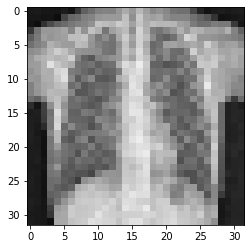

In [ ]:
plt.imshow(x_test[10])

In [ ]:
y_test[10]

0

In [ ]:
model.evaluate(x_test,y_test)[1]

2/2 [==============================] - 0s 11ms/step - loss: 0.3987 - accuracy: 0.8000


0.800000011920929

In [ ]:
model.predict(x_test[10].reshape(1,32,32,3))

array([[0.727493  , 0.27250698]], dtype=float32)

In [ ]:
np.argmax(model.predict(x_test[10].reshape(1,32,32,3)))

0

In [ ]:
epoc=[3,10,15,20]
test_acc=[]
for i in range(0,4):
  model.fit(x_train,y_train,epochs=epoc[i],verbose=0)
  test_acc.append(model.evaluate(x_test,y_test)[1])

2/2 [==============================] - 0s 12ms/step - loss: 0.5665 - accuracy: 0.8200


In [ ]:
test_acc

[0.5, 0.8399999737739563, 0.8600000143051147, 0.8199999928474426]

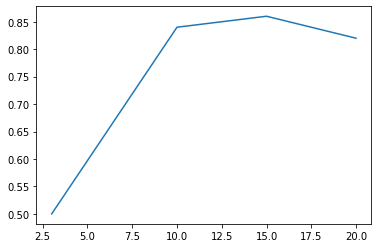

In [ ]:
plt.plot(epoc,test_acc)

In [ ]:
pred=model.predict(x_test)

In [ ]:
conf=[]
for i in pred:
  conf.append(np.argmax(i))

In [ ]:
from sklearn.metrics import confusion_matrix
confusion=confusion_matrix(y_test,conf)

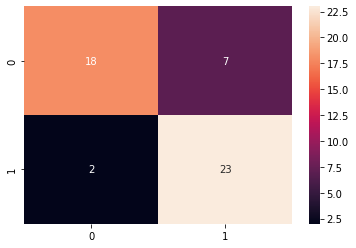

In [ ]:
import seaborn as snNew
snNew.heatmap(confusion,annot=True)